In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from math import gamma
from TLPP_Generation import Logic_Model_Generator
from tqdm import *
import itertools

class LSTM_Encoding_Action(nn.Module):

    '''
    input: [batch_size, num_predicate, seq_length]
    Parameters:
        input_size:
        hidden_size:
        output_size:
        num_layers:
    '''

    def __init__(self, input_size, hidden_size, output_size, batch_size, device, num_layers:int = 1) -> None:
        super().__init__()

        self.device = device
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1 # one-directional LSTM
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x:torch.tensor):
        batch_size, num_predicate, seq_length = x.shape
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(self.device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(self.device)
        x, _  = self.lstm(x, (h_0, c_0)) #NOTE: x:(batch_size, seq_length, num_directions * hidden_size)
        x = self.linear(x)
        x = x.view(batch_size, num_predicate, -1)
        return x


class LSTM_Encoding_History(nn.Module):

    '''
    NOTE:Returns a categorical distribution

    Parameters:
        input_size:
        hidden_size:
        output_size:
        num_layers
    '''

    def __init__(self, input_size, hidden_size, output_size, batch_size, device, num_layers: int = 1) -> None:
        super().__init__()

        self.device = device
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1 # one-directional LSTM
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x:torch.tensor, action_embedding: torch.tensor):
        '''
        Parameters:
            x: mental history
            action_embedding: encoding of action history. This should be the output of LSTM_Encoding_Action
        '''
        batch_size, num_predicate, seq_length = x.shape
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(self.device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(self.device)
        x, _ = self.lstm(x,(h_0,c_0))                              #NOTE: x:(batch_size, seq_length, num_directions * hidden_size)
        x = torch.concat(tensors=[x, action_embedding], dim=1)     #NOTE: concatenate the action info and the mental info
        batch_size, num_predicate, hidden_size = x.shape           #NOTE: num_predicate is changed
        x = self.linear(x)                                         #NOTE: x:(batch_size, seq_length, num_directions * output_size)
        x = x.view(batch_size, num_predicate, -1)
        #TODO: return a vector with dimension (I+1), (I represents the number of types of mental states)
        #TODO: the i-th (i=0,1,2,...,I) component of the output x represents the probability of the i-th mental type
        x = self.softmax(x)
        return x.view(batch_size,-1,self.output_size).mean(axis=1)
        

class Logic_Model_Incomplete_Data:

    def __init__(self, time_horizon:float, action_history:dict, hidden_size:tuple, output_size:tuple, batch_size:int, partition_size:float=0.1, device:str='cuda', num_layers:tuple=(1,1)) -> None:
        self.time_horizon = time_horizon
        self.partition_size = partition_size            # num of small time intervals
        self.action_history = action_history
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.device = device
        self.num_layers = num_layers                    # num_layers of LSTMs
        #TODO:
        ### the following parameters are used to manually define the logic rules
        self.num_predicate = 7                  # num_predicate is same as num_node
        self.num_formula = 8                    # num of prespecified logic rules
        self.BEFORE = 'BEFORE'
        self.EQUAL = 'EQUAL'
        self.AFTER = 'AFTER'
        self.Time_tolerance = 0.3               
        self.body_predicate_set = []                        # the index set of all body predicates
        self.mental_predicate_set = [0, 1, 2]
        self.action_predicate_set = [3, 4, 5, 6]
        self.head_predicate_set = [0, 1, 2, 3, 4, 5, 6]     # the index set of all head predicates
        self.decay_rate = 1                                 # decay kernel
        self.integral_resolution = 0.03

        #TODO: convert the action_history:dict to a numpy array 'processed_data':np.array to put in the LSTMs
        self.processed_data = self.process_data(action_history=self.action_history).to(device)
        self.INPUT_SIZE_A = self.processed_data.shape[-1]
        #self.INPUT_SIZE_M = int(self.time_horizon / self.partition_size)

        #TODO: construct two LSTMs to encode the past history
        #NOTE: encoding action history
        self.LSTM_Action = LSTM_Encoding_Action(input_size=self.INPUT_SIZE_A,hidden_size=hidden_size[0],output_size=output_size[0],batch_size=batch_size,device=device,num_layers=self.num_layers[0])
        self.LSTM_Action.to(device)
        #NOTE: encoding whole history
        self.LSTM_History = LSTM_Encoding_History(input_size=len(self.mental_predicate_set),hidden_size=hidden_size[1],output_size=output_size[1],batch_size=batch_size ,device=device,num_layers=self.num_layers[1])
        self.LSTM_History.to(device)


        ### the following parameters are used to generate synthetic data
        ### for the learning part, the following is used to claim variables
        ### self.model_parameter = {0:{},1:{},...,6:{}}
        self.model_parameter = {}


        '''
        mental
        '''

        head_predicate_idx = 0
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.3).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.01).double(), requires_grad=True)
        formula_idx = 1
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.01).double(), requires_grad=True)

        head_predicate_idx = 1
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.3).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.02).double(), requires_grad=True)
        formula_idx = 1
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.01).double(), requires_grad=True)

        head_predicate_idx = 2
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.2).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.1).double(), requires_grad=True)


        '''
        action
        '''
        head_predicate_idx = 3
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.1).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.01).double(), requires_grad=True)

        head_predicate_idx = 4
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.25).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.05).double(), requires_grad=True)

        head_predicate_idx = 5
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.6).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.8).double(), requires_grad=True)

        head_predicate_idx = 6
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.1).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.05).double(), requires_grad=True)




        #NOTE: set the content of logic rules
        self.logic_template = self.logic_rule()
    
    def logic_rule(self):
        #TODO: the logic rules encode the prior knowledge
        # encode rule information
        '''
        This function encodes the content of logic rules
        logic_template = {0:{},1:{},...,6:{}}
        '''
        logic_template = {}


        '''
        Mental (0-2)
        '''

        head_predicate_idx = 0
        logic_template[head_predicate_idx] = {} # here 0 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (2 and 3 and 4) and before(2,0) and before(3,0) and before(4,0) \to 0
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [2,3,4]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, 1, 1]  # use 1 to indicate True; use -1 to indicate False
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[2, 0], [3, 0], [4, 0]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE, self.BEFORE, self.BEFORE]


        #NOTE: rule content: ((\neg 0 and (2 and 6)) and after(6,0) and equal(2,0) \to \neg 0)
        formula_idx = 1
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [0, 2, 6]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [-1, 1, 1]  # use 1 to indicate True; use -1 to indicate False
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [-1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[6, 0], [2, 0]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.AFTER, self.EQUAL]

        head_predicate_idx = 1
        logic_template[head_predicate_idx] = {}  # here 1 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: 5 and before(5,1) to 1
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [5]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[5, 1]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE]

        #NOTE: rule content: (4 and 6) and before(6,1) to \neg 1
        formula_idx = 1
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [4, 6]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, 1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [-1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[6, 1]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE]


        head_predicate_idx = 2
        logic_template[head_predicate_idx] = {}  # here 2 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (\neg 1 and 6) and after(1,2) to 2
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [1, 6]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [-1, 1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[1, 2]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.AFTER]



        '''
        Action (3-6)
        '''
        head_predicate_idx = 3
        logic_template[head_predicate_idx] = {}  # here 3 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (0 and \neg 1) and before(0,1) and before(1,3) \to 3
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [0, 1]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, -1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[0, 1], [1, 3]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE, self.BEFORE]


        head_predicate_idx = 4
        logic_template[head_predicate_idx] = {}  # here 4 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (2) and before(2,4) \to 4
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [2]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[2, 4]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE]

        
        head_predicate_idx = 5
        logic_template[head_predicate_idx] = {}  # here 5 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (0 and \neg 1) and before(0,5) and after(1,5) \to 5
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [0, 1]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, -1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[0, 5], [1, 5]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE, self.AFTER]


        head_predicate_idx = 6
        logic_template[head_predicate_idx] = {}  # here 6 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (1 and 2) and before(1,6) and before(2,6) \to \neg 6
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [1, 2]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, 1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [-1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[1, 6], [2, 6]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE, self.BEFORE]


        return logic_template

    def intensity(self, cur_time, head_predicate_idx, history)->torch.tensor:
        feature_formula = []
        weight_formula = []
        effect_formula = []
        #TODO: Check if the head_prediate is a mental predicate
        if head_predicate_idx in self.mental_predicate_set: flag = 0
        else: flag = 1  #NOTE: action

        for formula_idx in list(self.logic_template[head_predicate_idx].keys()):
            weight_formula.append(self.model_parameter[head_predicate_idx][formula_idx]['weight'])

            feature_formula.append(self.get_feature(cur_time=cur_time, head_predicate_idx=head_predicate_idx,
                                                    history=history, template=self.logic_template[head_predicate_idx][formula_idx], flag=flag))
            effect_formula.append(self.get_formula_effect(cur_time=cur_time, head_predicate_idx=head_predicate_idx,
                                                       history=history, template=self.logic_template[head_predicate_idx][formula_idx]))
        intensity = torch.exp(torch.cat(weight_formula, dim=0))/torch.sum(torch.exp(torch.cat(weight_formula, dim=0)), dim=0) * torch.cat(feature_formula, dim=0) * torch.cat(effect_formula, dim=0)
        intensity = self.model_parameter[head_predicate_idx]['base'] + torch.sum(intensity)
        intensity = torch.exp(intensity)

        return intensity

    def get_feature(self, cur_time, head_predicate_idx, history, template, flag:int):
        #NOTE: flag: 0 or 1, denotes the head_predicate_idx is a mental or an action
        #NOTE: 0 for mental and 1 for action
        #NOTE: since for mental, we need to go through all the history information
        #NOTE: while for action, we only care about the current time information
        
        transition_time_dic = {}
        feature = torch.tensor([0], dtype=torch.float64)
        for idx, body_predicate_idx in enumerate(template['body_predicate_idx']):
            transition_time = np.array(history[body_predicate_idx]['time'])
            transition_state = np.array(history[body_predicate_idx]['state'])
            mask = (transition_time <= cur_time) * (transition_state == template['body_predicate_sign'][idx])
            transition_time_dic[body_predicate_idx] = transition_time[mask]
        transition_time_dic[head_predicate_idx] = [cur_time]
        ### get weights
        # compute features whenever any item of the transition_item_dic is nonempty
        history_transition_len = [len(i) for i in transition_time_dic.values()]
        if min(history_transition_len) > 0:
            # need to compute feature using logic rules
            time_combination = np.array(list(itertools.product(*transition_time_dic.values())))
            time_combination_dic = {}
            for i, idx in enumerate(list(transition_time_dic.keys())):
                #TODO: this is where we distinguish mental and action
                time_combination_dic[idx] = time_combination[:, i] if flag == 0 else time_combination[-1, i]
            temporal_kernel = np.ones(len(time_combination))
            for idx, temporal_relation_idx in enumerate(template['temporal_relation_idx']):       
                #TODO: checkpoint
                #print('head_predicate_idx: {}; temporal_relation_idx[0]: {}, temporal_relation_idx[1]: {}'.format(head_predicate_idx, temporal_relation_idx[0], temporal_relation_idx[1]))
                #print('temporal combination dict: {}'.format(time_combination_dic))
         
                time_difference = time_combination_dic[temporal_relation_idx[0]] - time_combination_dic[temporal_relation_idx[1]]
                if template['temporal_relation_type'][idx] == 'BEFORE':
                    temporal_kernel *= (time_difference < - self.Time_tolerance) * np.exp(-self.decay_rate *(cur_time - time_combination_dic[temporal_relation_idx[0]]))
                if template['temporal_relation_type'][idx] == 'EQUAL':
                    temporal_kernel *= (abs(time_difference) <= self.Time_tolerance) * np.exp(-self.decay_rate*(cur_time - time_combination_dic[temporal_relation_idx[0]]))
                if template['temporal_relation_type'][idx] == 'AFTER':
                    temporal_kernel *= (time_difference > self.Time_tolerance) * np.exp(-self.decay_rate*(cur_time - time_combination_dic[temporal_relation_idx[1]]))
            feature = torch.tensor([np.sum(temporal_kernel)], dtype=torch.float64)
        return feature

    def get_formula_effect(self, cur_time, head_predicate_idx, history, template):
        ## Note this part is very important!! For generator, this should be np.sum(cur_time > head_transition_time) - 1
        ## Since at the transition times, choose the intensity function right before the transition time
        head_transition_time = np.array(history[head_predicate_idx]['time'])
        head_transition_state = np.array(history[head_predicate_idx]['state'])
        if len(head_transition_time) == 0:
            cur_state = 0
            counter_state = 1 - cur_state
        else:
            idx = np.sum(cur_time > head_transition_time) - 1
            cur_state = head_transition_state[idx]
            counter_state = 1 - cur_state
        if counter_state == template['head_predicate_sign']:
            formula_effect = torch.tensor([1], dtype=torch.float64)
        else:
            formula_effect = torch.tensor([-1], dtype=torch.float64)
        return formula_effect

    def log_likelihood(self, dataset, sample_ID_batch, T_max)->torch.tensor:
        '''
        This function calculates the log-likehood given the dataset
        log-likelihood = \sum log(intensity(transition_time)) + int_0^T intensity dt

        Parameters:
            dataset: 
            sample_ID_batch: list
            T_max:
        '''
        log_likelihood = torch.tensor([0], dtype=torch.float64)
        # iterate over samples
        for sample_ID in sample_ID_batch:
            # iterate over head predicates; each predicate corresponds to one intensity
            data_sample = dataset[sample_ID]
            for head_predicate_idx in self.head_predicate_set:
                #NOTE: compute the summation of log intensities at the transition times
                intensity_log_sum = self.intensity_log_sum(head_predicate_idx, data_sample)
                #NOTE: compute the integration of intensity function over the time horizon
                intensity_integral = self.intensity_integral(head_predicate_idx, data_sample, T_max)
                log_likelihood += (intensity_log_sum - intensity_integral)
        return log_likelihood

    def intensity_log_sum(self, head_predicate_idx, data_sample):
        intensity_transition = []
        for t in data_sample[head_predicate_idx]['time'][1:]:
            #NOTE: compute the intensity at transition times
            cur_intensity:torch.tensor = self.intensity(t, head_predicate_idx, data_sample)
            intensity_transition.append(cur_intensity)
        if len(intensity_transition) == 0: # only survival term, no event happens
            log_sum = torch.tensor([0], dtype=torch.float64)
        else:
            log_sum = torch.sum(torch.log(torch.cat(intensity_transition, dim=0)))
        return log_sum

    def intensity_integral(self, head_predicate_idx, data_sample, T_max):
        start_time = 0
        end_time = T_max
        intensity_grid = []
        for t in np.arange(start_time, end_time, self.integral_resolution):
            #NOTE: evaluate the intensity values at the chosen time points
            cur_intensity:torch.Tensor = self.intensity(t, head_predicate_idx, data_sample)
            intensity_grid.append(cur_intensity)
        #NOTE: approximately calculate the integral
        integral = torch.sum(torch.cat(intensity_grid, dim=0) * self.integral_resolution)
        return integral

    def process_data(self, action_history:dict)->torch.tensor:
        '''
        Parameters:
            action_history: dict
        '''
        #TODO: convert the action sequences into a numpy array
        #NOTE: action_history = {
        #                       3: {...}
        #                       4: {...}
        #                       5: {...}
        #                       6: {...}
        #                       }
        # "..." stands for transition times for predicate 3,4,5,6. Recall that 3,4,5,6 are all action predicates
        result = []
        max_action_transition_time_length = 0       #NOTE: record the length of the transition time
        for sample_id in action_history:            #NOTE: batch
            for action_predicate_idx in self.action_predicate_set:
                #print(sample_id, action_predicate_idx)
                time = action_history[sample_id][action_predicate_idx]['time'][1:]
                tmp = len(time)
                if tmp > max_action_transition_time_length: max_action_transition_time_length = tmp
                result.append(time)
        #print(result)
        #NOTE: shape (batch_size:len(action_history), num_predicate:len(self.action_predicate_set), seq_length:max_action_transition_time_length)
        data = np.zeros(shape=(len(action_history),len(self.action_predicate_set),max_action_transition_time_length))
        #TODO: store the action history in a tensor
        for batch in range(data.shape[0]):
            for row in range(data.shape[1]): 
                data[batch, row, :len(result[(batch+1)*row])] = result[(batch+1)*row]
        return torch.tensor(data).float()

    def ELBO(self, sample_ID_batch:list, temperature:float=1.0, device='cuda')->torch.tensor:
        #TODO: compute the ELBO. 
        #TODO: Maximize the ELBO is equivalent to minimize the KL divergence between the variational posterior and the true posterior
        #NOTE: in order to compute the ELBO, we need to 1. be able to sample from the variational posterior; 2. compute the entropy of q
        
        '''
        compute the ELBO (MC estimate)

        Parameters:
            sample_ID_batch: the collection of batch indices
            action_history: action information
            temperature: 
        '''
        #NOTE: we add a small time shift 1e-4 so that we can include the end time point in 'time_intervals'
        time_intervals = np.arange(0,self.time_horizon+1e-4,step=self.partition_size)
        #print(time_intervals) #NOTE: checkpoint

        #TODO: initialize. Store the complete data
        complete_history = dict([(sample_id, self.action_history[sample_id]) for sample_id in sample_ID_batch])
        for sample_id in complete_history:
            for mental_predicate_idx in self.mental_predicate_set:
                complete_history[sample_id][mental_predicate_idx] = {}
                complete_history[sample_id][mental_predicate_idx]['time'] = [0]
                complete_history[sample_id][mental_predicate_idx]['state'] = [0]
        #print(complete_history) #NOTE: checkpoint
        #TODO: initilize, store mental history, this will be fed into the LSTM
        mental_history = torch.zeros(size=(len(sample_ID_batch),1,len(self.mental_predicate_set))).to(device)

        ELBO = (torch.zeros(size=(1,self.batch_size))).to(device)    #NOTE: initialize ELBO
        
        #TODO: encode the mental history
        h_a = self.LSTM_Action.forward(self.processed_data[sample_ID_batch,:,:]) #h_a (batch_size, num_predicate, output_size=hidden_size_m)
        for i in range(len(time_intervals)-1):
            #TODO: encode the mental history before the i-th time interval (LSTMs) -> categorical distribution -> prob
            # prob (batch_size, 1, num_mental_predicate+1)
            prob:torch.tensor = self.LSTM_History.forward(x=mental_history,action_embedding=h_a)
            # logits (batch_size, 1, num_mental_predicate+1)
            logits:torch.tensor = torch.log(prob)
            #TODO: ELBO = ELBO + self.entropy_variational posterior
            ELBO += self.entropy_variational_posterior(logits,temperature,device=device)
            #TODO: draw hard samples. post_samples = self.sample_variational_posterior_hard(size = sample_size, prob = prob)
            post_samples:torch.tensor = self.sample_variational_posterior(size=len(sample_ID_batch),logits=logits,temperature=temperature,hard=True)
            #TODO: after sampling the mental transition time, update the history information
            event_time = (time_intervals[i] + time_intervals[i+1])/2
            _, indices = post_samples.max(dim=2)
            indices = indices.detach().cpu().numpy()
            new_mental_information = torch.zeros(size=(len(sample_ID_batch),1,len(self.mental_predicate_set))).to(device)
            
            #print(indices[0,:])
            for batch_idx in range(indices.shape[0]):
                for idx in indices[batch_idx,:]:
                    if idx == 0: continue
                    #TODO: update the mental history
                    new_mental_information[batch_idx,0,idx-1] = event_time
                    #TODO: update the complete history, which is a dict
                    sample_id = sample_ID_batch[batch_idx]
                    complete_history[sample_id][idx-1]['time'].append(event_time)
                    if complete_history[sample_id][idx-1]['state'][-1] == 0: complete_history[sample_id][idx-1]['state'].append(1)
                    else: complete_history[sample_id][idx-1]['state'].append(0)
            #print(new_mental_information) #NOTE:checkpoint
            #TODO: update mental_history
            mental_history = torch.concat([mental_history,new_mental_information],dim=1)
            
            #TODO: calculate mean of those ELBOs
            ELBO = torch.mean(ELBO).view(-1,)

            #TODO: ELBO += 1/L * (\sum log likelihood)
            ELBO += (self.log_likelihood(dataset=complete_history,sample_ID_batch=sample_ID_batch,T_max=self.time_horizon)).to(device)
            #print(ELBO) #NOTE: checkpoint
            #TODO: return ELBO
            return ELBO*len(self.action_history) #NOTE: \mathcal{L} * N


    def sample_variational_posterior(self, size:int, logits: torch.tensor, temperature:float=1.0, hard=False)->torch.tensor:
        #TODO: use gumbel-max trick to explicitly sample from the variational posterior defined by LSTMs, which is a categorical distribution
        '''
        draw explicit samples from variational posterior

        Parameters:
            size: number of samples
            logits: 
            hard: boolean
        '''
    
        result = []
        for i in range(size):
            tmp = self.gumbel_softmax(logits,temperature,hard)
            result.append(tmp)
        #NOTE: return one-hot vectors.
        #print(result)
        result = torch.stack(result,dim=0)
        return result

    def sample_Gumble(self, shape, eps:float=1e-20):
        #TODO: sample from Gumbel(0,1). This is needed when we want to explicitly sample from the variational posterior
        '''
        Sample from Gumbel(0,1) with shape = 'shape'

        Parameters:
            shape: 
            eps: small perturbation to avoid log(0)
            tens_type: 
        '''

        U = torch.rand(shape)
        U = U.cuda()
        return -torch.log(-torch.log(U+eps)+eps)

    def sample_Gumble_softmax(self, logits:torch.tensor, temperature=1.0):
        #TODO: sample from the gumbel-softmax distribution
        '''
        Parameters:
            prob: 
            temperature:
        '''
        y = logits + self.sample_Gumble(logits.shape)
        return F.softmax(y/temperature,dim=-1)

    def gumbel_softmax(self, logits:torch.tensor, temperature:float=1.0, hard=False):
        #TODO: ST-gumbel-softmax
        """
        ST-gumple-softmax
        input: [*, n_class]
        return: flatten --> [*, n_class] an one-hot vector
        """

        y = self.sample_Gumble_softmax(logits,temperature)
        if not hard: return y
        shape = y.size()
        _, idx = y.max(dim=-1)
        y_hard = torch.zeros_like(y).view(-1,shape[-1])
        y_hard.scatter_(1, idx.view(-1,1), 1)
        y_hard = y_hard.view(*shape)
        y_hard = (y_hard - y).detach() + y
        return y_hard

    def entropy_variational_posterior(self, logits:torch.tensor, temperature:float=1.0, MC_size:int=100, device='cuda')->float:
        #TODO: approximately calculate the entropy of the variational posterior
        #TODO: the true variational posterior (categorical) is approximated by a Gumbel-softmax distribution, controlled by 'tau' (temperature)
        '''
        Parameters:
            temperature: temperature parameter
            prob: probabilities for each category
        '''
        #TODO: draw 'MC_size' samples from gumble softmax distribution
        gumbel_softmax_samples = self.sample_variational_posterior(size=MC_size,logits=logits,temperature=temperature).to(device)
        #TODO: compute the log-densities
        log_densities = torch.log(self.Gumbel_softmax_density(gumbel_softmax_samples,temperature,logits)).to(device)
        #TODO: this is the Monte-Carlo estimate of the entropy
        result = torch.mean(-log_densities,dim=[0,-1])
        return result

    def Gumbel_softmax_density(self, y:torch.tensor, temperature:float, logits:torch.tensor)->torch.tensor:
        #TODO: return the probability density of Gumbel softmax distribution at y
        '''
        Parameters:
            y: input
            temperature: temperature parameter
            prob: probabilities for each category
        '''
        k = logits.size()[-1]
        prob = torch.exp(logits)
        #NOTE: compute the probability density. RHS is the density of gumbel softmax distribution
        result = gamma(k) * (temperature)**(k-1) * (torch.multiply(prob,1/(y)**temperature))**(-k) * torch.sum(prob/y**(temperature+1))
        return result

    def optimize_ELBO(self, temperature, device, sample_ID_batch, optimizer_psi, optimizer_theta):
        optimizer_theta.zero_grad()  # set gradient zero at the start of a new mini-batch
        optimizer_psi.zero_grad()
        #TODO: the loss function is just the -ELBO, since minimize the loss is equivalent to minimize the KL-divergence
        loss = -self.ELBO(sample_ID_batch, temperature, device)
        loss.backward()
        optimizer_theta.step()
        optimizer_psi.step()
        return loss

    def train_model(self, temperature:float=1.0, num_iter:int=10, lr:tuple=(0.01,0.02)):
        #TODO: train the model from incomplete data by gradient descent
        #TODO: 1. draw a minibatch ('batch_size') from the data, compute ELBO
        #TODO: 2. compute gradient of ELBO w.r.t. to \theta (model parameter) and \psi (variational parameter, i.e. LSTM param)
        #TODO: 3. gradient ascent, alternatively optimize \theta and \psi

        model_parameters = [self.model_parameter[0]['base'],
                    self.model_parameter[0][0]['weight'],
                    self.model_parameter[0][1]['weight'],
                    self.model_parameter[1]['base'],
                    self.model_parameter[1][0]['weight'],
                    self.model_parameter[1][1]['weight'],
                    self.model_parameter[2]['base'],
                    self.model_parameter[2][0]['weight'],
                    self.model_parameter[3]['base'],
                    self.model_parameter[3][0]['weight'],
                    self.model_parameter[4]['base'],
                    self.model_parameter[4][0]['weight'],
                    self.model_parameter[5]['base'],
                    self.model_parameter[5][0]['weight'],
                    self.model_parameter[6]['base'],
                    self.model_parameter[6][0]['weight']
                    ]

        num_batch = len(self.action_history) // self.batch_size
        #print(num_batch)
        losses = []
        optimizer_theta = optim.Adam(params=model_parameters,lr=lr[0])
        optimizer_psi = optim.Adam(params=[list(self.LSTM_Action.parameters())[0], list(self.LSTM_History.parameters())[0]], lr=lr[1], eps=1e-8)

        for iter in tqdm(range(num_iter)):
            for batch_idx in tqdm(np.arange(0, num_batch, 1)):
                indices = np.arange(batch_idx*self.batch_size, (batch_idx+1)*self.batch_size, 1)
                #NOTE: we want to minimize negative ELBO
                loss = self.optimize_ELBO(temperature,self.device,indices,optimizer_psi,optimizer_theta) #NOTE:-ELBO, want to see it decreases
            losses.append(loss.detach().cpu().numpy())
            print('iter >> {}; loss >> {}'.format(iter+1, loss.detach().cpu().numpy()))
            #print('model parameter $\\theta$ >> {}'.format(model_parameters))
            #print('LSTM parameters $\psi$ >> {}'.format([list(self.LSTM_Action.parameters())[0], list(self.LSTM_History.parameters())[0]]))
        return losses

    def plot_loss(self,losses:list):
        #TODO: plot the losses
        plt.figure(figsize=(9,3),dpi=150)
        X = np.arange(1,len(losses)+1,1)
        plt.plot(X,losses,label='$-\mathcal{L}(\\theta,\psi,\mathcal{H}_a(T))$')
        plt.legend(bbox_to_anchor=(1,1))
        plt.xlabel('iter')
        plt.ylabel('negative ELBO')
        plt.show()

f:\Anaconda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
gen = Logic_Model_Generator()
num_sample = 48

data = gen.generate_data(num_sample=num_sample, time_horizon=3)
#print(data)
action_history = {}
for i in range(num_sample):
    action_history_ = dict([(key, data[i][key]) for key in [3,4,5,6]])
    action_history[i] = action_history_
#print(data)
learn = Logic_Model_Incomplete_Data(time_horizon=1,action_history=action_history,hidden_size=(15,10),output_size=(10,4),batch_size=16)
num_iter = 50
losses = learn.train_model(temperature=0.8,num_iter=num_iter,lr=(0.01,0.01))

X = np.arange(1,num_iter+1,1)
plt.figure(figsize=(9,2),dpi=150)
plt.plot(X, losses, c='green',label='-$\mathcal{L}$')
plt.xlabel('iter')
plt.ylabel('-$\mathcal{L}$')
plt.legend(bbox_to_anchor=(1,1))

[INFO] data has been generated!!!


  0%|          | 1/300 [00:01<08:44,  1.76s/it]

iter >> 1; loss >> [5801.1016]


  1%|          | 2/300 [00:03<08:41,  1.75s/it]

iter >> 2; loss >> [5418.9043]


  1%|          | 3/300 [00:05<08:26,  1.70s/it]

iter >> 3; loss >> [5051.1006]


  1%|▏         | 4/300 [00:06<08:12,  1.66s/it]

iter >> 4; loss >> [5530.718]


  2%|▏         | 5/300 [00:08<08:20,  1.70s/it]

iter >> 5; loss >> [5261.8135]


  2%|▏         | 6/300 [00:10<08:08,  1.66s/it]

iter >> 6; loss >> [5166.3926]


  2%|▏         | 7/300 [00:11<08:10,  1.68s/it]

iter >> 7; loss >> [5124.023]


  3%|▎         | 8/300 [00:13<08:05,  1.66s/it]

iter >> 8; loss >> [4970.98]


  3%|▎         | 9/300 [00:15<08:00,  1.65s/it]

iter >> 9; loss >> [4854.004]


  3%|▎         | 10/300 [00:16<07:59,  1.65s/it]

iter >> 10; loss >> [4630.537]


  4%|▎         | 11/300 [00:18<07:51,  1.63s/it]

iter >> 11; loss >> [4706.7925]


  4%|▍         | 12/300 [00:20<08:03,  1.68s/it]

iter >> 12; loss >> [4550.203]


  4%|▍         | 13/300 [00:21<07:56,  1.66s/it]

iter >> 13; loss >> [4544.9707]


  5%|▍         | 14/300 [00:23<07:49,  1.64s/it]

iter >> 14; loss >> [4727.6816]


  5%|▌         | 15/300 [00:24<07:48,  1.64s/it]

iter >> 15; loss >> [4334.7466]


  5%|▌         | 16/300 [00:26<07:47,  1.65s/it]

iter >> 16; loss >> [4679.773]


  6%|▌         | 17/300 [00:28<07:45,  1.64s/it]

iter >> 17; loss >> [4668.209]


  6%|▌         | 18/300 [00:29<07:39,  1.63s/it]

iter >> 18; loss >> [4567.112]


  6%|▋         | 19/300 [00:31<07:36,  1.62s/it]

iter >> 19; loss >> [4341.5483]


  7%|▋         | 20/300 [00:33<07:46,  1.67s/it]

iter >> 20; loss >> [4119.736]


  7%|▋         | 21/300 [00:34<07:39,  1.65s/it]

iter >> 21; loss >> [4038.4468]


  7%|▋         | 22/300 [00:36<07:38,  1.65s/it]

iter >> 22; loss >> [3930.5347]


  8%|▊         | 23/300 [00:38<07:31,  1.63s/it]

iter >> 23; loss >> [3843.1655]


  8%|▊         | 24/300 [00:39<07:28,  1.63s/it]

iter >> 24; loss >> [4169.5137]


  8%|▊         | 25/300 [00:41<07:33,  1.65s/it]

iter >> 25; loss >> [4019.4736]


  9%|▊         | 26/300 [00:43<07:30,  1.64s/it]

iter >> 26; loss >> [3910.4272]


  9%|▉         | 27/300 [00:44<07:30,  1.65s/it]

iter >> 27; loss >> [3826.8638]


  9%|▉         | 28/300 [00:46<07:24,  1.63s/it]

iter >> 28; loss >> [3664.8027]


 10%|▉         | 29/300 [00:47<07:29,  1.66s/it]

iter >> 29; loss >> [3635.5806]


 10%|█         | 30/300 [00:49<07:25,  1.65s/it]

iter >> 30; loss >> [3562.7578]


 10%|█         | 31/300 [00:51<07:18,  1.63s/it]

iter >> 31; loss >> [3558.9014]


 11%|█         | 32/300 [00:52<07:19,  1.64s/it]

iter >> 32; loss >> [3264.3467]


 11%|█         | 33/300 [00:54<07:13,  1.62s/it]

iter >> 33; loss >> [3505.546]


 11%|█▏        | 34/300 [00:56<07:19,  1.65s/it]

iter >> 34; loss >> [3492.8567]


 12%|█▏        | 35/300 [00:58<07:33,  1.71s/it]

iter >> 35; loss >> [3360.0403]


 12%|█▏        | 36/300 [01:00<08:22,  1.90s/it]

iter >> 36; loss >> [3146.745]


 12%|█▏        | 37/300 [01:02<08:17,  1.89s/it]

iter >> 37; loss >> [3142.6392]


 13%|█▎        | 38/300 [01:03<08:02,  1.84s/it]

iter >> 38; loss >> [3178.185]


 13%|█▎        | 39/300 [01:05<07:54,  1.82s/it]

iter >> 39; loss >> [3047.285]


 13%|█▎        | 40/300 [01:07<08:12,  1.90s/it]

iter >> 40; loss >> [3023.523]


 14%|█▎        | 41/300 [01:09<08:14,  1.91s/it]

iter >> 41; loss >> [2966.7803]


 14%|█▍        | 42/300 [01:11<07:41,  1.79s/it]

iter >> 42; loss >> [2895.2646]


 14%|█▍        | 43/300 [01:12<07:23,  1.72s/it]

iter >> 43; loss >> [2828.496]


 15%|█▍        | 44/300 [01:14<07:05,  1.66s/it]

iter >> 44; loss >> [2947.9941]


 15%|█▌        | 45/300 [01:15<06:52,  1.62s/it]

iter >> 45; loss >> [3039.678]


 15%|█▌        | 46/300 [01:17<06:41,  1.58s/it]

iter >> 46; loss >> [2677.6528]


 16%|█▌        | 47/300 [01:18<06:43,  1.60s/it]

iter >> 47; loss >> [2756.6958]


 16%|█▌        | 48/300 [01:20<06:36,  1.57s/it]

iter >> 48; loss >> [2578.0845]


 16%|█▋        | 49/300 [01:22<06:29,  1.55s/it]

iter >> 49; loss >> [2639.8586]


 17%|█▋        | 50/300 [01:23<06:24,  1.54s/it]

iter >> 50; loss >> [2527.5981]


 17%|█▋        | 51/300 [01:25<06:30,  1.57s/it]

iter >> 51; loss >> [2515.373]


 17%|█▋        | 52/300 [01:26<06:28,  1.57s/it]

iter >> 52; loss >> [2525.9192]


 18%|█▊        | 53/300 [01:28<06:23,  1.55s/it]

iter >> 53; loss >> [2540.4375]


 18%|█▊        | 54/300 [01:29<06:17,  1.54s/it]

iter >> 54; loss >> [2356.8809]


 18%|█▊        | 55/300 [01:31<06:19,  1.55s/it]

iter >> 55; loss >> [2462.8328]


 19%|█▊        | 56/300 [01:32<06:21,  1.56s/it]

iter >> 56; loss >> [2331.3254]


 19%|█▉        | 57/300 [01:34<06:17,  1.56s/it]

iter >> 57; loss >> [2330.3013]


 19%|█▉        | 58/300 [01:35<06:13,  1.54s/it]

iter >> 58; loss >> [2270.69]


 20%|█▉        | 59/300 [01:37<06:10,  1.54s/it]

iter >> 59; loss >> [2193.2854]


 20%|██        | 60/300 [01:39<06:11,  1.55s/it]

iter >> 60; loss >> [2249.9705]


 20%|██        | 61/300 [01:40<06:07,  1.54s/it]

iter >> 61; loss >> [2049.6965]


 21%|██        | 62/300 [01:42<06:06,  1.54s/it]

iter >> 62; loss >> [2183.293]


 21%|██        | 63/300 [01:43<06:06,  1.55s/it]

iter >> 63; loss >> [2229.0845]


 21%|██▏       | 64/300 [01:45<06:01,  1.53s/it]

iter >> 64; loss >> [2222.4849]


 22%|██▏       | 65/300 [01:46<06:03,  1.54s/it]

iter >> 65; loss >> [2022.7003]


 22%|██▏       | 66/300 [01:48<05:58,  1.53s/it]

iter >> 66; loss >> [1938.2721]


 22%|██▏       | 67/300 [01:49<05:58,  1.54s/it]

iter >> 67; loss >> [1988.147]


 23%|██▎       | 68/300 [01:51<05:57,  1.54s/it]

iter >> 68; loss >> [1765.4329]


 23%|██▎       | 69/300 [01:52<05:57,  1.55s/it]

iter >> 69; loss >> [1870.5774]


 23%|██▎       | 70/300 [01:54<05:52,  1.53s/it]

iter >> 70; loss >> [1751.7551]


 24%|██▎       | 71/300 [01:55<05:49,  1.53s/it]

iter >> 71; loss >> [2001.1218]


 24%|██▍       | 72/300 [01:57<05:47,  1.52s/it]

iter >> 72; loss >> [1461.7198]


 24%|██▍       | 73/300 [01:58<05:44,  1.52s/it]

iter >> 73; loss >> [1713.9285]


 25%|██▍       | 74/300 [02:00<05:48,  1.54s/it]

iter >> 74; loss >> [1715.8848]


 25%|██▌       | 75/300 [02:02<05:44,  1.53s/it]

iter >> 75; loss >> [1506.7396]


 25%|██▌       | 76/300 [02:03<05:40,  1.52s/it]

iter >> 76; loss >> [1467.0103]


 26%|██▌       | 77/300 [02:05<05:37,  1.51s/it]

iter >> 77; loss >> [1531.0853]


 26%|██▌       | 78/300 [02:06<05:39,  1.53s/it]

iter >> 78; loss >> [1515.8132]


 26%|██▋       | 79/300 [02:08<05:37,  1.53s/it]

iter >> 79; loss >> [1280.6481]


 27%|██▋       | 80/300 [02:09<05:35,  1.52s/it]

iter >> 80; loss >> [1529.0681]


 27%|██▋       | 81/300 [02:11<05:32,  1.52s/it]

iter >> 81; loss >> [1359.5298]


 27%|██▋       | 82/300 [02:12<05:33,  1.53s/it]

iter >> 82; loss >> [1366.48]


 28%|██▊       | 83/300 [02:14<05:37,  1.56s/it]

iter >> 83; loss >> [1349.3352]


 28%|██▊       | 84/300 [02:15<05:33,  1.54s/it]

iter >> 84; loss >> [1415.7594]


 28%|██▊       | 85/300 [02:17<05:32,  1.55s/it]

iter >> 85; loss >> [1176.281]


 29%|██▊       | 86/300 [02:18<05:27,  1.53s/it]

iter >> 86; loss >> [1471.438]


 29%|██▉       | 87/300 [02:20<05:29,  1.55s/it]

iter >> 87; loss >> [1222.9623]


 29%|██▉       | 88/300 [02:22<05:28,  1.55s/it]

iter >> 88; loss >> [1076.3778]


 30%|██▉       | 89/300 [02:23<05:27,  1.55s/it]

iter >> 89; loss >> [1124.2025]


 30%|███       | 90/300 [02:25<05:22,  1.54s/it]

iter >> 90; loss >> [1214.7891]


 30%|███       | 91/300 [02:26<05:23,  1.55s/it]

iter >> 91; loss >> [895.36426]


 31%|███       | 92/300 [02:28<05:19,  1.54s/it]

iter >> 92; loss >> [1026.0463]


 31%|███       | 93/300 [02:29<05:20,  1.55s/it]

iter >> 93; loss >> [825.6058]


 31%|███▏      | 94/300 [02:31<05:17,  1.54s/it]

iter >> 94; loss >> [928.72614]


 32%|███▏      | 95/300 [02:32<05:16,  1.54s/it]

iter >> 95; loss >> [826.3427]


 32%|███▏      | 96/300 [02:34<05:17,  1.55s/it]

iter >> 96; loss >> [828.50977]


 32%|███▏      | 97/300 [02:35<05:12,  1.54s/it]

iter >> 97; loss >> [873.744]


 33%|███▎      | 98/300 [02:37<05:08,  1.53s/it]

iter >> 98; loss >> [914.0459]


 33%|███▎      | 99/300 [02:38<05:08,  1.54s/it]

iter >> 99; loss >> [742.73315]


 33%|███▎      | 100/300 [02:40<05:14,  1.57s/it]

iter >> 100; loss >> [619.447]


 34%|███▎      | 101/300 [02:42<05:09,  1.55s/it]

iter >> 101; loss >> [638.9367]


 34%|███▍      | 102/300 [02:43<05:04,  1.54s/it]

iter >> 102; loss >> [786.9447]


 34%|███▍      | 103/300 [02:45<05:03,  1.54s/it]

iter >> 103; loss >> [744.4347]


 35%|███▍      | 104/300 [02:46<05:00,  1.53s/it]

iter >> 104; loss >> [653.80225]


 35%|███▌      | 105/300 [02:48<05:01,  1.55s/it]

iter >> 105; loss >> [826.26276]


 35%|███▌      | 106/300 [02:49<04:57,  1.54s/it]

iter >> 106; loss >> [585.26807]


 36%|███▌      | 107/300 [02:51<04:54,  1.52s/it]

iter >> 107; loss >> [780.20905]


 36%|███▌      | 108/300 [02:52<04:51,  1.52s/it]

iter >> 108; loss >> [566.31665]


 36%|███▋      | 109/300 [02:54<04:51,  1.53s/it]

iter >> 109; loss >> [632.829]


 37%|███▋      | 110/300 [02:55<04:50,  1.53s/it]

iter >> 110; loss >> [370.5525]


 37%|███▋      | 111/300 [02:57<04:50,  1.53s/it]

iter >> 111; loss >> [306.7675]


 37%|███▋      | 112/300 [02:58<04:49,  1.54s/it]

iter >> 112; loss >> [520.1992]


 38%|███▊      | 113/300 [03:00<04:48,  1.54s/it]

iter >> 113; loss >> [404.24332]


 38%|███▊      | 114/300 [03:02<04:48,  1.55s/it]

iter >> 114; loss >> [476.5918]


 38%|███▊      | 115/300 [03:03<04:44,  1.54s/it]

iter >> 115; loss >> [158.14473]


 39%|███▊      | 116/300 [03:05<04:41,  1.53s/it]

iter >> 116; loss >> [293.65717]


 39%|███▉      | 117/300 [03:06<04:38,  1.52s/it]

iter >> 117; loss >> [558.6283]


 39%|███▉      | 118/300 [03:08<04:40,  1.54s/it]

iter >> 118; loss >> [212.17787]


 40%|███▉      | 119/300 [03:09<04:37,  1.53s/it]

iter >> 119; loss >> [240.78555]


 40%|████      | 120/300 [03:11<04:34,  1.52s/it]

iter >> 120; loss >> [218.95705]


 40%|████      | 121/300 [03:12<04:31,  1.51s/it]

iter >> 121; loss >> [372.425]


 41%|████      | 122/300 [03:14<04:29,  1.51s/it]

iter >> 122; loss >> [133.4689]


 41%|████      | 123/300 [03:15<04:34,  1.55s/it]

iter >> 123; loss >> [222.41905]


 41%|████▏     | 124/300 [03:17<04:30,  1.54s/it]

iter >> 124; loss >> [413.6599]


 42%|████▏     | 125/300 [03:18<04:27,  1.53s/it]

iter >> 125; loss >> [36.289646]


 42%|████▏     | 126/300 [03:20<04:26,  1.53s/it]

iter >> 126; loss >> [12.89132]


 42%|████▏     | 127/300 [03:22<04:29,  1.56s/it]

iter >> 127; loss >> [89.21059]


 43%|████▎     | 128/300 [03:23<04:27,  1.55s/it]

iter >> 128; loss >> [289.4931]


 43%|████▎     | 129/300 [03:25<04:24,  1.55s/it]

iter >> 129; loss >> [-290.45444]


 43%|████▎     | 130/300 [03:26<04:20,  1.53s/it]

iter >> 130; loss >> [178.97774]


 44%|████▎     | 131/300 [03:28<04:17,  1.53s/it]

iter >> 131; loss >> [-31.545355]


 44%|████▍     | 132/300 [03:29<04:19,  1.55s/it]

iter >> 132; loss >> [98.00987]


 44%|████▍     | 133/300 [03:31<04:16,  1.54s/it]

iter >> 133; loss >> [-29.391685]


 45%|████▍     | 134/300 [03:32<04:13,  1.53s/it]

iter >> 134; loss >> [-253.88588]


 45%|████▌     | 135/300 [03:34<04:10,  1.52s/it]

iter >> 135; loss >> [-286.7478]


 45%|████▌     | 136/300 [03:35<04:12,  1.54s/it]

iter >> 136; loss >> [-133.63081]


 46%|████▌     | 137/300 [03:37<04:08,  1.52s/it]

iter >> 137; loss >> [35.713505]


 46%|████▌     | 138/300 [03:38<04:06,  1.52s/it]

iter >> 138; loss >> [-269.63037]


 46%|████▋     | 139/300 [03:40<04:04,  1.52s/it]

iter >> 139; loss >> [-148.5703]


 47%|████▋     | 140/300 [03:41<04:03,  1.52s/it]

iter >> 140; loss >> [-259.8868]


 47%|████▋     | 141/300 [03:43<04:04,  1.54s/it]

iter >> 141; loss >> [-179.10138]


 47%|████▋     | 142/300 [03:44<04:01,  1.53s/it]

iter >> 142; loss >> [-129.59096]


 48%|████▊     | 143/300 [03:46<03:58,  1.52s/it]

iter >> 143; loss >> [-395.05713]


 48%|████▊     | 144/300 [03:47<03:56,  1.52s/it]

iter >> 144; loss >> [-335.7277]


 48%|████▊     | 145/300 [03:49<03:57,  1.53s/it]

iter >> 145; loss >> [-95.46822]


 49%|████▊     | 146/300 [03:51<03:56,  1.54s/it]

iter >> 146; loss >> [-142.56122]


 49%|████▉     | 147/300 [03:52<04:07,  1.62s/it]

iter >> 147; loss >> [-426.10632]


 49%|████▉     | 148/300 [03:55<04:30,  1.78s/it]

iter >> 148; loss >> [-391.6141]


 50%|████▉     | 149/300 [03:56<04:34,  1.82s/it]

iter >> 149; loss >> [-287.22046]


 50%|█████     | 150/300 [03:59<04:45,  1.91s/it]

iter >> 150; loss >> [-146.21953]


 50%|█████     | 151/300 [04:01<04:49,  1.95s/it]

iter >> 151; loss >> [-552.35925]


 51%|█████     | 152/300 [04:03<04:50,  1.96s/it]

iter >> 152; loss >> [-637.20715]


 51%|█████     | 153/300 [04:05<04:52,  1.99s/it]

iter >> 153; loss >> [-150.5887]


 51%|█████▏    | 154/300 [04:07<04:53,  2.01s/it]

iter >> 154; loss >> [-865.66595]


 52%|█████▏    | 155/300 [04:09<04:46,  1.98s/it]

iter >> 155; loss >> [-560.5939]


 52%|█████▏    | 156/300 [04:10<04:41,  1.95s/it]

iter >> 156; loss >> [-203.37218]


 52%|█████▏    | 157/300 [04:12<04:37,  1.94s/it]

iter >> 157; loss >> [-379.59814]


 53%|█████▎    | 158/300 [04:14<04:41,  1.98s/it]

iter >> 158; loss >> [-370.33014]


 53%|█████▎    | 159/300 [04:17<04:44,  2.02s/it]

iter >> 159; loss >> [-578.85126]


 53%|█████▎    | 160/300 [04:18<04:37,  1.98s/it]

iter >> 160; loss >> [-561.4417]


 54%|█████▎    | 161/300 [04:20<04:27,  1.93s/it]

iter >> 161; loss >> [-728.4353]


 54%|█████▍    | 162/300 [04:22<04:14,  1.85s/it]

iter >> 162; loss >> [-717.82324]


 54%|█████▍    | 163/300 [04:24<04:12,  1.84s/it]

iter >> 163; loss >> [-447.43073]


 55%|█████▍    | 164/300 [04:25<04:01,  1.77s/it]

iter >> 164; loss >> [-516.27203]


 55%|█████▌    | 165/300 [04:27<03:54,  1.74s/it]

iter >> 165; loss >> [-898.2097]


 55%|█████▌    | 166/300 [04:29<03:49,  1.71s/it]

iter >> 166; loss >> [-362.5267]


 56%|█████▌    | 167/300 [04:30<03:44,  1.69s/it]

iter >> 167; loss >> [-560.1771]


 56%|█████▌    | 168/300 [04:32<03:46,  1.71s/it]

iter >> 168; loss >> [-534.4248]


 56%|█████▋    | 169/300 [04:34<03:41,  1.69s/it]

iter >> 169; loss >> [-712.92633]


 57%|█████▋    | 170/300 [04:35<03:36,  1.67s/it]

iter >> 170; loss >> [-759.4154]


 57%|█████▋    | 171/300 [04:37<03:33,  1.65s/it]

iter >> 171; loss >> [-503.53284]


 57%|█████▋    | 172/300 [04:39<03:33,  1.66s/it]

iter >> 172; loss >> [-619.7627]


 58%|█████▊    | 173/300 [04:40<03:35,  1.70s/it]

iter >> 173; loss >> [-586.1245]


 58%|█████▊    | 174/300 [04:42<03:30,  1.67s/it]

iter >> 174; loss >> [-713.4567]


 58%|█████▊    | 175/300 [04:44<03:51,  1.85s/it]

iter >> 175; loss >> [-590.1541]


 59%|█████▊    | 176/300 [04:46<03:58,  1.92s/it]

iter >> 176; loss >> [-845.06134]


 59%|█████▉    | 177/300 [04:48<03:48,  1.86s/it]

iter >> 177; loss >> [-660.958]


 59%|█████▉    | 178/300 [04:50<03:32,  1.74s/it]

iter >> 178; loss >> [-804.8996]


 60%|█████▉    | 179/300 [04:51<03:22,  1.67s/it]

iter >> 179; loss >> [-1116.083]


 60%|██████    | 180/300 [04:53<03:20,  1.67s/it]

iter >> 180; loss >> [-751.94836]


 60%|██████    | 181/300 [04:54<03:13,  1.63s/it]

iter >> 181; loss >> [-905.94476]


 61%|██████    | 182/300 [04:56<03:05,  1.57s/it]

iter >> 182; loss >> [-1011.9809]


 61%|██████    | 183/300 [04:57<02:58,  1.53s/it]

iter >> 183; loss >> [-771.9138]


 61%|██████▏   | 184/300 [04:59<02:54,  1.50s/it]

iter >> 184; loss >> [-907.1985]


 62%|██████▏   | 185/300 [05:00<02:50,  1.48s/it]

iter >> 185; loss >> [-1046.9271]


 62%|██████▏   | 186/300 [05:01<02:48,  1.48s/it]

iter >> 186; loss >> [-611.8444]


 62%|██████▏   | 187/300 [05:03<02:45,  1.47s/it]

iter >> 187; loss >> [-802.09875]


 63%|██████▎   | 188/300 [05:04<02:43,  1.46s/it]

iter >> 188; loss >> [-894.01373]


 63%|██████▎   | 189/300 [05:06<02:40,  1.45s/it]

iter >> 189; loss >> [-876.8879]


 63%|██████▎   | 190/300 [05:07<02:43,  1.49s/it]

iter >> 190; loss >> [-336.4703]


 64%|██████▎   | 191/300 [05:09<02:53,  1.59s/it]

iter >> 191; loss >> [-1115.7213]


 64%|██████▍   | 192/300 [05:11<03:09,  1.76s/it]

iter >> 192; loss >> [-738.08966]


 64%|██████▍   | 193/300 [05:13<03:08,  1.76s/it]

iter >> 193; loss >> [-829.5391]


 65%|██████▍   | 194/300 [05:15<03:04,  1.74s/it]

iter >> 194; loss >> [-790.48914]


 65%|██████▌   | 195/300 [05:17<03:02,  1.74s/it]

iter >> 195; loss >> [-664.1403]


 65%|██████▌   | 196/300 [05:18<03:00,  1.73s/it]

iter >> 196; loss >> [-953.8854]


 66%|██████▌   | 197/300 [05:20<02:56,  1.71s/it]

iter >> 197; loss >> [-761.7825]


 66%|██████▌   | 198/300 [05:22<02:53,  1.70s/it]

iter >> 198; loss >> [-923.89575]


 66%|██████▋   | 199/300 [05:23<02:52,  1.71s/it]

iter >> 199; loss >> [-920.19885]


 67%|██████▋   | 200/300 [05:25<02:48,  1.69s/it]

iter >> 200; loss >> [-1070.2328]


 67%|██████▋   | 201/300 [05:27<02:45,  1.67s/it]

iter >> 201; loss >> [-1007.8991]


 67%|██████▋   | 202/300 [05:28<02:43,  1.67s/it]

iter >> 202; loss >> [-1110.1475]


 68%|██████▊   | 203/300 [05:30<02:41,  1.66s/it]

iter >> 203; loss >> [-1363.1704]


 68%|██████▊   | 204/300 [05:32<02:42,  1.70s/it]

iter >> 204; loss >> [-812.4159]


 68%|██████▊   | 205/300 [05:33<02:39,  1.68s/it]

iter >> 205; loss >> [-1047.2722]


 69%|██████▊   | 206/300 [05:35<02:37,  1.67s/it]

iter >> 206; loss >> [-926.8817]


 69%|██████▉   | 207/300 [05:37<02:35,  1.67s/it]

iter >> 207; loss >> [-933.3695]


 69%|██████▉   | 208/300 [05:38<02:35,  1.69s/it]

iter >> 208; loss >> [-964.51843]


 70%|██████▉   | 209/300 [05:40<02:32,  1.68s/it]

iter >> 209; loss >> [-858.9985]


 70%|███████   | 210/300 [05:42<02:30,  1.67s/it]

iter >> 210; loss >> [-1117.7565]


 70%|███████   | 211/300 [05:43<02:27,  1.66s/it]

iter >> 211; loss >> [-1566.5074]


 71%|███████   | 212/300 [05:45<02:25,  1.66s/it]

iter >> 212; loss >> [-1079.5054]


 71%|███████   | 213/300 [05:47<02:25,  1.67s/it]

iter >> 213; loss >> [-702.6901]


 71%|███████▏  | 214/300 [05:48<02:23,  1.67s/it]

iter >> 214; loss >> [-1316.3765]


 72%|███████▏  | 215/300 [05:50<02:21,  1.66s/it]

iter >> 215; loss >> [-1078.5503]


 72%|███████▏  | 216/300 [05:52<02:19,  1.66s/it]

iter >> 216; loss >> [-1245.5906]


 72%|███████▏  | 217/300 [05:53<02:19,  1.68s/it]

iter >> 217; loss >> [-828.1957]


 73%|███████▎  | 218/300 [05:55<02:17,  1.68s/it]

iter >> 218; loss >> [-1256.8647]


 73%|███████▎  | 219/300 [05:57<02:15,  1.67s/it]

iter >> 219; loss >> [-1100.7163]


 73%|███████▎  | 220/300 [05:58<02:12,  1.66s/it]

iter >> 220; loss >> [-1074.2202]


 74%|███████▎  | 221/300 [06:00<02:10,  1.66s/it]

iter >> 221; loss >> [-578.7231]


 74%|███████▍  | 222/300 [06:02<02:11,  1.68s/it]

iter >> 222; loss >> [-1265.3331]


 74%|███████▍  | 223/300 [06:03<02:08,  1.67s/it]

iter >> 223; loss >> [-824.12317]


 75%|███████▍  | 224/300 [06:05<02:06,  1.67s/it]

iter >> 224; loss >> [-954.926]


 75%|███████▌  | 225/300 [06:07<02:04,  1.66s/it]

iter >> 225; loss >> [-671.18164]


 75%|███████▌  | 226/300 [06:08<02:04,  1.68s/it]

iter >> 226; loss >> [-712.3929]


 76%|███████▌  | 227/300 [06:10<02:01,  1.67s/it]

iter >> 227; loss >> [-887.6846]


 76%|███████▌  | 228/300 [06:12<01:59,  1.66s/it]

iter >> 228; loss >> [-853.5148]


 76%|███████▋  | 229/300 [06:13<01:57,  1.65s/it]

iter >> 229; loss >> [-1315.4279]


 77%|███████▋  | 230/300 [06:15<01:55,  1.66s/it]

iter >> 230; loss >> [-1027.637]


 77%|███████▋  | 231/300 [06:17<01:55,  1.68s/it]

iter >> 231; loss >> [-1290.1002]


 77%|███████▋  | 232/300 [06:18<01:53,  1.67s/it]

iter >> 232; loss >> [-948.7513]


 78%|███████▊  | 233/300 [06:20<01:51,  1.67s/it]

iter >> 233; loss >> [-1062.2747]


 78%|███████▊  | 234/300 [06:22<01:49,  1.66s/it]

iter >> 234; loss >> [-1245.4393]


 78%|███████▊  | 235/300 [06:23<01:49,  1.68s/it]

iter >> 235; loss >> [-937.1392]


 79%|███████▊  | 236/300 [06:25<01:46,  1.67s/it]

iter >> 236; loss >> [-974.5899]


 79%|███████▉  | 237/300 [06:27<01:44,  1.66s/it]

iter >> 237; loss >> [-989.60425]


 79%|███████▉  | 238/300 [06:29<01:47,  1.74s/it]

iter >> 238; loss >> [-979.29395]


 80%|███████▉  | 239/300 [06:31<01:57,  1.93s/it]

iter >> 239; loss >> [-1114.7029]


 80%|████████  | 240/300 [06:33<01:55,  1.92s/it]

iter >> 240; loss >> [-1379.466]


 80%|████████  | 241/300 [06:35<01:59,  2.02s/it]

iter >> 241; loss >> [-693.0928]


 81%|████████  | 242/300 [06:37<01:57,  2.02s/it]

iter >> 242; loss >> [-1267.6526]


 81%|████████  | 243/300 [06:39<01:59,  2.09s/it]

iter >> 243; loss >> [-726.7236]


 81%|████████▏ | 244/300 [06:42<01:58,  2.11s/it]

iter >> 244; loss >> [-1049.4506]


 82%|████████▏ | 245/300 [06:43<01:52,  2.04s/it]

iter >> 245; loss >> [-1237.5796]


 82%|████████▏ | 246/300 [06:45<01:48,  2.01s/it]

iter >> 246; loss >> [-945.35767]


 82%|████████▏ | 247/300 [06:47<01:44,  1.98s/it]

iter >> 247; loss >> [-1175.4135]


 83%|████████▎ | 248/300 [06:49<01:43,  1.99s/it]

iter >> 248; loss >> [-749.0381]


 83%|████████▎ | 249/300 [06:51<01:44,  2.05s/it]

iter >> 249; loss >> [-1275.5677]


 83%|████████▎ | 250/300 [06:54<01:42,  2.04s/it]

iter >> 250; loss >> [-966.73303]


 84%|████████▎ | 251/300 [06:56<01:40,  2.05s/it]

iter >> 251; loss >> [-1097.1556]


 84%|████████▍ | 252/300 [06:57<01:35,  1.99s/it]

iter >> 252; loss >> [-1115.13]


 84%|████████▍ | 253/300 [06:59<01:30,  1.94s/it]

iter >> 253; loss >> [-1199.2977]


 85%|████████▍ | 254/300 [07:01<01:26,  1.88s/it]

iter >> 254; loss >> [-997.0239]


 85%|████████▌ | 255/300 [07:03<01:21,  1.81s/it]

iter >> 255; loss >> [-1180.5333]


 85%|████████▌ | 256/300 [07:04<01:16,  1.75s/it]

iter >> 256; loss >> [-1515.5345]


 86%|████████▌ | 257/300 [07:06<01:16,  1.77s/it]

iter >> 257; loss >> [-1306.8093]


 86%|████████▌ | 258/300 [07:08<01:12,  1.73s/it]

iter >> 258; loss >> [-1462.0115]


 86%|████████▋ | 259/300 [07:09<01:08,  1.67s/it]

iter >> 259; loss >> [-1047.5072]


 87%|████████▋ | 260/300 [07:11<01:05,  1.64s/it]

iter >> 260; loss >> [-1098.5626]


 87%|████████▋ | 261/300 [07:12<01:01,  1.59s/it]

iter >> 261; loss >> [-1345.5151]


 87%|████████▋ | 262/300 [07:14<00:59,  1.57s/it]

iter >> 262; loss >> [-1195.9956]


 88%|████████▊ | 263/300 [07:15<00:57,  1.54s/it]

iter >> 263; loss >> [-1147.8185]


 88%|████████▊ | 264/300 [07:17<00:54,  1.52s/it]

iter >> 264; loss >> [-855.8745]


 88%|████████▊ | 265/300 [07:18<00:52,  1.51s/it]

iter >> 265; loss >> [-1089.221]


 89%|████████▊ | 266/300 [07:20<00:50,  1.50s/it]

iter >> 266; loss >> [-1043.4595]


 89%|████████▉ | 267/300 [07:21<00:50,  1.53s/it]

iter >> 267; loss >> [-1559.8546]


 89%|████████▉ | 268/300 [07:23<00:49,  1.54s/it]

iter >> 268; loss >> [-943.6377]


 90%|████████▉ | 269/300 [07:24<00:47,  1.54s/it]

iter >> 269; loss >> [-1064.3027]


 90%|█████████ | 270/300 [07:26<00:45,  1.52s/it]

iter >> 270; loss >> [-1255.3145]


 90%|█████████ | 271/300 [07:27<00:45,  1.55s/it]

iter >> 271; loss >> [-1018.33057]


 91%|█████████ | 272/300 [07:29<00:43,  1.57s/it]

iter >> 272; loss >> [-1058.5507]


 91%|█████████ | 273/300 [07:31<00:42,  1.56s/it]

iter >> 273; loss >> [-1498.6913]


 91%|█████████▏| 274/300 [07:32<00:39,  1.53s/it]

iter >> 274; loss >> [-1151.3744]


 92%|█████████▏| 275/300 [07:34<00:39,  1.56s/it]

iter >> 275; loss >> [-1543.6917]


 92%|█████████▏| 276/300 [07:36<00:40,  1.71s/it]

iter >> 276; loss >> [-724.1633]


 92%|█████████▏| 277/300 [07:38<00:40,  1.76s/it]

iter >> 277; loss >> [-1306.9824]


 93%|█████████▎| 278/300 [07:39<00:38,  1.74s/it]

iter >> 278; loss >> [-1306.6542]


 93%|█████████▎| 279/300 [07:41<00:36,  1.73s/it]

iter >> 279; loss >> [-1914.5322]


 93%|█████████▎| 280/300 [07:43<00:34,  1.74s/it]

iter >> 280; loss >> [-1158.7719]


 94%|█████████▎| 281/300 [07:45<00:33,  1.74s/it]

iter >> 281; loss >> [-993.48315]


 94%|█████████▍| 282/300 [07:47<00:33,  1.87s/it]

iter >> 282; loss >> [-1234.3365]


 94%|█████████▍| 283/300 [07:48<00:31,  1.84s/it]

iter >> 283; loss >> [-1203.69]


 95%|█████████▍| 284/300 [07:50<00:29,  1.85s/it]

iter >> 284; loss >> [-830.0403]


 95%|█████████▌| 285/300 [07:52<00:28,  1.88s/it]

iter >> 285; loss >> [-1195.2781]


 95%|█████████▌| 286/300 [07:54<00:27,  1.94s/it]

iter >> 286; loss >> [-1062.7622]


 96%|█████████▌| 287/300 [07:56<00:25,  1.96s/it]

iter >> 287; loss >> [-1197.0459]


 96%|█████████▌| 288/300 [07:59<00:24,  2.01s/it]

iter >> 288; loss >> [-1264.3369]


 96%|█████████▋| 289/300 [08:01<00:22,  2.01s/it]

iter >> 289; loss >> [-1224.1299]


 97%|█████████▋| 290/300 [08:02<00:18,  1.89s/it]

iter >> 290; loss >> [-1324.9279]


 97%|█████████▋| 291/300 [08:04<00:16,  1.81s/it]

iter >> 291; loss >> [-1465.5256]


 97%|█████████▋| 292/300 [08:05<00:14,  1.75s/it]

iter >> 292; loss >> [-1480.6488]


 98%|█████████▊| 293/300 [08:07<00:12,  1.72s/it]

iter >> 293; loss >> [-1046.0745]


 98%|█████████▊| 294/300 [08:09<00:10,  1.71s/it]

iter >> 294; loss >> [-1273.9109]


 98%|█████████▊| 295/300 [08:10<00:08,  1.68s/it]

iter >> 295; loss >> [-1472.759]


 99%|█████████▊| 296/300 [08:12<00:06,  1.67s/it]

iter >> 296; loss >> [-1182.1569]


 99%|█████████▉| 297/300 [08:14<00:04,  1.65s/it]

iter >> 297; loss >> [-1323.8434]


 99%|█████████▉| 298/300 [08:15<00:03,  1.66s/it]

iter >> 298; loss >> [-757.4517]


100%|█████████▉| 299/300 [08:17<00:01,  1.66s/it]

iter >> 299; loss >> [-1195.4519]


100%|██████████| 300/300 [08:19<00:00,  1.66s/it]


iter >> 300; loss >> [-1242.0111]


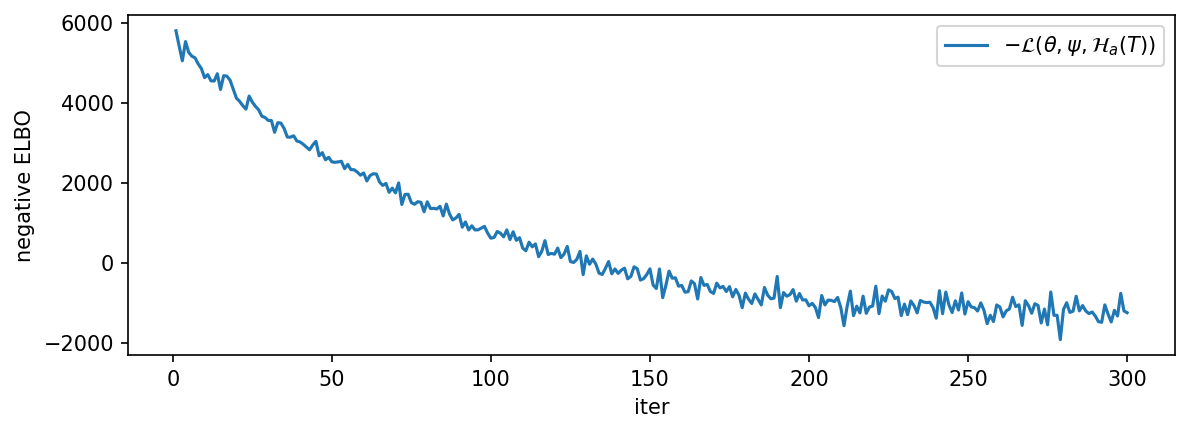

In [22]:
def generate_incomplete_data(num_sample:int=10, time_horizon:float=5.0):
        gen = Logic_Model_Generator()
        data = gen.generate_data(num_sample=num_sample, time_horizon=time_horizon)
        action_history = {}
        for i in range(num_sample):
            action_history_ = dict([(key, data[i][key]) for key in [3,4,5,6]])
            action_history[i] = action_history_
        #NOTE: info
        print('[INFO] data has been generated!!!')
        return action_history

action_history = generate_incomplete_data(num_sample=20,time_horizon=1.0)
learn = Logic_Model_Incomplete_Data(time_horizon=1.0,action_history=action_history,hidden_size=(15,20),output_size=(20,4),batch_size=20,num_layers=(2,6))
losses = learn.train_model(num_iter=300,lr=(0.01,0.01))
learn.plot_loss(losses)

In [78]:
def generate_incomplete_data(num_sample:int=10, time_horizon:float=5.0):
        gen = Logic_Model_Generator()
        data = gen.generate_data(num_sample=num_sample, time_horizon=time_horizon)
        action_history = {}
        for i in range(num_sample):
            action_history_ = dict([(key, data[i][key]) for key in [3,4,5,6]])
            action_history[i] = action_history_
        #NOTE: info
        print('[INFO] data has been generated!!!')
        return action_history

info = []
times = 5
for time in range(times):
    action_history = generate_incomplete_data(num_sample=20,time_horizon=0.5)
    learn = Logic_Model_Incomplete_Data(time_horizon=0.5,action_history=action_history,hidden_size=(15,20),output_size=(20,4),batch_size=20,num_layers=(2,6))
    losses = learn.train_model(num_iter=50,lr=(0.01,0.01))
    info.append(losses)


[INFO] data has been generated!!!


  2%|▏         | 1/50 [00:01<00:58,  1.19s/it]

iter >> 1; loss >> [3734.191]


  4%|▍         | 2/50 [00:02<00:50,  1.06s/it]

iter >> 2; loss >> [3988.2375]


  6%|▌         | 3/50 [00:03<00:46,  1.00it/s]

iter >> 3; loss >> [3527.2349]


  8%|▊         | 4/50 [00:04<00:50,  1.09s/it]

iter >> 4; loss >> [3556.7722]


 10%|█         | 5/50 [00:05<00:47,  1.06s/it]

iter >> 5; loss >> [3505.1035]


 12%|█▏        | 6/50 [00:06<00:46,  1.06s/it]

iter >> 6; loss >> [3634.3064]


 14%|█▍        | 7/50 [00:07<00:42,  1.01it/s]

iter >> 7; loss >> [3436.7075]


 16%|█▌        | 8/50 [00:08<00:39,  1.06it/s]

iter >> 8; loss >> [3469.5925]


 18%|█▊        | 9/50 [00:08<00:38,  1.07it/s]

iter >> 9; loss >> [3521.0813]


 20%|██        | 10/50 [00:09<00:36,  1.10it/s]

iter >> 10; loss >> [3201.121]


 22%|██▏       | 11/50 [00:10<00:34,  1.12it/s]

iter >> 11; loss >> [3217.6055]


 24%|██▍       | 12/50 [00:11<00:33,  1.14it/s]

iter >> 12; loss >> [3070.9219]


 26%|██▌       | 13/50 [00:12<00:32,  1.15it/s]

iter >> 13; loss >> [3004.7288]


 28%|██▊       | 14/50 [00:13<00:31,  1.16it/s]

iter >> 14; loss >> [3091.5198]


 30%|███       | 15/50 [00:14<00:29,  1.17it/s]

iter >> 15; loss >> [2789.4702]


 32%|███▏      | 16/50 [00:14<00:28,  1.18it/s]

iter >> 16; loss >> [3079.905]


 34%|███▍      | 17/50 [00:15<00:27,  1.18it/s]

iter >> 17; loss >> [2885.753]


 36%|███▌      | 18/50 [00:16<00:26,  1.19it/s]

iter >> 18; loss >> [2817.4766]


 38%|███▊      | 19/50 [00:17<00:26,  1.16it/s]

iter >> 19; loss >> [2564.8865]


 40%|████      | 20/50 [00:18<00:25,  1.17it/s]

iter >> 20; loss >> [2863.544]


 42%|████▏     | 21/50 [00:19<00:24,  1.17it/s]

iter >> 21; loss >> [2619.1963]


 44%|████▍     | 22/50 [00:19<00:23,  1.18it/s]

iter >> 22; loss >> [2449.5168]


 46%|████▌     | 23/50 [00:20<00:22,  1.18it/s]

iter >> 23; loss >> [2358.7869]


 48%|████▊     | 24/50 [00:21<00:22,  1.18it/s]

iter >> 24; loss >> [2400.4282]


 50%|█████     | 25/50 [00:22<00:21,  1.19it/s]

iter >> 25; loss >> [2343.8032]


 52%|█████▏    | 26/50 [00:23<00:20,  1.19it/s]

iter >> 26; loss >> [2054.5747]


 54%|█████▍    | 27/50 [00:24<00:19,  1.19it/s]

iter >> 27; loss >> [2153.958]


 56%|█████▌    | 28/50 [00:25<00:18,  1.19it/s]

iter >> 28; loss >> [2064.4688]


 58%|█████▊    | 29/50 [00:25<00:18,  1.16it/s]

iter >> 29; loss >> [2081.567]


 60%|██████    | 30/50 [00:26<00:17,  1.17it/s]

iter >> 30; loss >> [1980.5112]


 62%|██████▏   | 31/50 [00:27<00:16,  1.17it/s]

iter >> 31; loss >> [1883.6791]


 64%|██████▍   | 32/50 [00:28<00:15,  1.18it/s]

iter >> 32; loss >> [1842.8319]


 66%|██████▌   | 33/50 [00:29<00:14,  1.17it/s]

iter >> 33; loss >> [1799.0034]


 68%|██████▊   | 34/50 [00:30<00:13,  1.18it/s]

iter >> 34; loss >> [1751.5774]


 70%|███████   | 35/50 [00:31<00:12,  1.18it/s]

iter >> 35; loss >> [1748.7255]


 72%|███████▏  | 36/50 [00:31<00:11,  1.19it/s]

iter >> 36; loss >> [1597.6213]


 74%|███████▍  | 37/50 [00:32<00:10,  1.19it/s]

iter >> 37; loss >> [1409.2668]


 76%|███████▌  | 38/50 [00:33<00:10,  1.19it/s]

iter >> 38; loss >> [1533.6261]


 78%|███████▊  | 39/50 [00:34<00:09,  1.19it/s]

iter >> 39; loss >> [1612.3264]


 80%|████████  | 40/50 [00:35<00:08,  1.16it/s]

iter >> 40; loss >> [1350.168]


 82%|████████▏ | 41/50 [00:36<00:07,  1.17it/s]

iter >> 41; loss >> [1384.2487]


 84%|████████▍ | 42/50 [00:36<00:06,  1.18it/s]

iter >> 42; loss >> [1229.9408]


 86%|████████▌ | 43/50 [00:37<00:05,  1.19it/s]

iter >> 43; loss >> [1316.0541]


 88%|████████▊ | 44/50 [00:38<00:05,  1.19it/s]

iter >> 44; loss >> [1119.7635]


 90%|█████████ | 45/50 [00:39<00:04,  1.19it/s]

iter >> 45; loss >> [1226.0142]


 92%|█████████▏| 46/50 [00:40<00:03,  1.19it/s]

iter >> 46; loss >> [1169.5984]


 94%|█████████▍| 47/50 [00:41<00:02,  1.19it/s]

iter >> 47; loss >> [1090.034]


 96%|█████████▌| 48/50 [00:42<00:01,  1.15it/s]

iter >> 48; loss >> [1001.87994]


 98%|█████████▊| 49/50 [00:42<00:00,  1.17it/s]

iter >> 49; loss >> [1008.3696]


100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


iter >> 50; loss >> [956.2751]
[INFO] data has been generated!!!


  2%|▏         | 1/50 [00:00<00:39,  1.23it/s]

iter >> 1; loss >> [3645.6807]


  4%|▍         | 2/50 [00:01<00:39,  1.21it/s]

iter >> 2; loss >> [3357.0283]


  6%|▌         | 3/50 [00:02<00:38,  1.21it/s]

iter >> 3; loss >> [3394.1907]


  8%|▊         | 4/50 [00:03<00:38,  1.21it/s]

iter >> 4; loss >> [3302.496]


 10%|█         | 5/50 [00:04<00:37,  1.21it/s]

iter >> 5; loss >> [3220.9897]


 12%|█▏        | 6/50 [00:05<00:37,  1.17it/s]

iter >> 6; loss >> [3256.9739]


 14%|█▍        | 7/50 [00:05<00:36,  1.18it/s]

iter >> 7; loss >> [3210.6729]


 16%|█▌        | 8/50 [00:06<00:35,  1.19it/s]

iter >> 8; loss >> [3065.7288]


 18%|█▊        | 9/50 [00:07<00:36,  1.12it/s]

iter >> 9; loss >> [2930.0198]


 20%|██        | 10/50 [00:08<00:37,  1.07it/s]

iter >> 10; loss >> [3126.98]


 22%|██▏       | 11/50 [00:09<00:39,  1.01s/it]

iter >> 11; loss >> [2955.1582]


 24%|██▍       | 12/50 [00:11<00:41,  1.09s/it]

iter >> 12; loss >> [2909.5635]


 26%|██▌       | 13/50 [00:12<00:40,  1.08s/it]

iter >> 13; loss >> [2665.476]


 28%|██▊       | 14/50 [00:13<00:37,  1.05s/it]

iter >> 14; loss >> [2863.105]


 30%|███       | 15/50 [00:14<00:35,  1.01s/it]

iter >> 15; loss >> [2772.2515]


 32%|███▏      | 16/50 [00:15<00:33,  1.01it/s]

iter >> 16; loss >> [2697.2646]


 34%|███▍      | 17/50 [00:16<00:32,  1.02it/s]

iter >> 17; loss >> [2821.9653]


 36%|███▌      | 18/50 [00:17<00:32,  1.01s/it]

iter >> 18; loss >> [2458.2888]


 38%|███▊      | 19/50 [00:18<00:32,  1.05s/it]

iter >> 19; loss >> [2495.726]


 40%|████      | 20/50 [00:19<00:30,  1.03s/it]

iter >> 20; loss >> [2449.4497]


 42%|████▏     | 21/50 [00:20<00:29,  1.01s/it]

iter >> 21; loss >> [2443.2468]


 44%|████▍     | 22/50 [00:21<00:27,  1.01it/s]

iter >> 22; loss >> [2263.0288]


 46%|████▌     | 23/50 [00:22<00:26,  1.04it/s]

iter >> 23; loss >> [2309.5]


 48%|████▊     | 24/50 [00:22<00:24,  1.07it/s]

iter >> 24; loss >> [2306.8071]


 50%|█████     | 25/50 [00:23<00:23,  1.09it/s]

iter >> 25; loss >> [2153.7625]


 52%|█████▏    | 26/50 [00:24<00:21,  1.10it/s]

iter >> 26; loss >> [2066.6343]


 54%|█████▍    | 27/50 [00:25<00:21,  1.09it/s]

iter >> 27; loss >> [2101.4043]


 56%|█████▌    | 28/50 [00:26<00:20,  1.06it/s]

iter >> 28; loss >> [1934.481]


 58%|█████▊    | 29/50 [00:27<00:19,  1.08it/s]

iter >> 29; loss >> [1967.47]


 60%|██████    | 30/50 [00:28<00:18,  1.09it/s]

iter >> 30; loss >> [1903.3647]


 62%|██████▏   | 31/50 [00:29<00:17,  1.10it/s]

iter >> 31; loss >> [1773.3987]


 64%|██████▍   | 32/50 [00:30<00:17,  1.05it/s]

iter >> 32; loss >> [1772.5801]


 66%|██████▌   | 33/50 [00:31<00:16,  1.02it/s]

iter >> 33; loss >> [1790.1959]


 68%|██████▊   | 34/50 [00:32<00:15,  1.06it/s]

iter >> 34; loss >> [1690.5181]


 70%|███████   | 35/50 [00:33<00:13,  1.11it/s]

iter >> 35; loss >> [1658.9613]


 72%|███████▏  | 36/50 [00:33<00:12,  1.13it/s]

iter >> 36; loss >> [1485.3492]


 74%|███████▍  | 37/50 [00:34<00:11,  1.13it/s]

iter >> 37; loss >> [1487.8076]


 76%|███████▌  | 38/50 [00:35<00:10,  1.16it/s]

iter >> 38; loss >> [1582.4287]


 78%|███████▊  | 39/50 [00:36<00:09,  1.15it/s]

iter >> 39; loss >> [1379.8944]


 80%|████████  | 40/50 [00:37<00:08,  1.16it/s]

iter >> 40; loss >> [1344.3052]


 82%|████████▏ | 41/50 [00:38<00:07,  1.18it/s]

iter >> 41; loss >> [1318.452]


 84%|████████▍ | 42/50 [00:38<00:06,  1.20it/s]

iter >> 42; loss >> [1351.7896]


 86%|████████▌ | 43/50 [00:39<00:05,  1.22it/s]

iter >> 43; loss >> [1082.9738]


 88%|████████▊ | 44/50 [00:40<00:04,  1.23it/s]

iter >> 44; loss >> [1098.1455]


 90%|█████████ | 45/50 [00:41<00:04,  1.23it/s]

iter >> 45; loss >> [1115.3494]


 92%|█████████▏| 46/50 [00:42<00:03,  1.21it/s]

iter >> 46; loss >> [1069.9899]


 94%|█████████▍| 47/50 [00:43<00:02,  1.22it/s]

iter >> 47; loss >> [1043.8804]


 96%|█████████▌| 48/50 [00:43<00:01,  1.23it/s]

iter >> 48; loss >> [975.2333]


 98%|█████████▊| 49/50 [00:44<00:00,  1.24it/s]

iter >> 49; loss >> [755.3986]


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


iter >> 50; loss >> [915.94434]
[INFO] data has been generated!!!


  2%|▏         | 1/50 [00:00<00:38,  1.26it/s]

iter >> 1; loss >> [3971.7188]


  4%|▍         | 2/50 [00:01<00:38,  1.25it/s]

iter >> 2; loss >> [3702.1877]


  6%|▌         | 3/50 [00:02<00:37,  1.24it/s]

iter >> 3; loss >> [3676.61]


  8%|▊         | 4/50 [00:03<00:37,  1.24it/s]

iter >> 4; loss >> [3768.159]


 10%|█         | 5/50 [00:04<00:36,  1.24it/s]

iter >> 5; loss >> [3827.3438]


 12%|█▏        | 6/50 [00:04<00:35,  1.25it/s]

iter >> 6; loss >> [3369.7026]


 14%|█▍        | 7/50 [00:05<00:34,  1.25it/s]

iter >> 7; loss >> [3359.0195]


 16%|█▌        | 8/50 [00:06<00:34,  1.21it/s]

iter >> 8; loss >> [3488.1943]


 18%|█▊        | 9/50 [00:07<00:33,  1.22it/s]

iter >> 9; loss >> [3395.088]


 20%|██        | 10/50 [00:08<00:32,  1.23it/s]

iter >> 10; loss >> [3075.514]


 22%|██▏       | 11/50 [00:08<00:31,  1.23it/s]

iter >> 11; loss >> [3179.6162]


 24%|██▍       | 12/50 [00:09<00:30,  1.23it/s]

iter >> 12; loss >> [3112.4268]


 26%|██▌       | 13/50 [00:10<00:30,  1.23it/s]

iter >> 13; loss >> [3201.6338]


 28%|██▊       | 14/50 [00:11<00:29,  1.24it/s]

iter >> 14; loss >> [2930.351]


 30%|███       | 15/50 [00:12<00:28,  1.24it/s]

iter >> 15; loss >> [2883.6462]


 32%|███▏      | 16/50 [00:12<00:27,  1.23it/s]

iter >> 16; loss >> [2807.6077]


 34%|███▍      | 17/50 [00:13<00:27,  1.20it/s]

iter >> 17; loss >> [2808.6462]


 36%|███▌      | 18/50 [00:14<00:26,  1.21it/s]

iter >> 18; loss >> [2828.5215]


 38%|███▊      | 19/50 [00:15<00:25,  1.22it/s]

iter >> 19; loss >> [2728.4663]


 40%|████      | 20/50 [00:16<00:24,  1.23it/s]

iter >> 20; loss >> [2699.8872]


 42%|████▏     | 21/50 [00:17<00:23,  1.23it/s]

iter >> 21; loss >> [2664.4712]


 44%|████▍     | 22/50 [00:17<00:22,  1.24it/s]

iter >> 22; loss >> [2531.7954]


 46%|████▌     | 23/50 [00:18<00:21,  1.24it/s]

iter >> 23; loss >> [2404.0872]


 48%|████▊     | 24/50 [00:19<00:20,  1.24it/s]

iter >> 24; loss >> [2521.0078]


 50%|█████     | 25/50 [00:20<00:20,  1.24it/s]

iter >> 25; loss >> [2398.0952]


 52%|█████▏    | 26/50 [00:21<00:19,  1.21it/s]

iter >> 26; loss >> [2436.1829]


 54%|█████▍    | 27/50 [00:21<00:18,  1.22it/s]

iter >> 27; loss >> [2253.9673]


 56%|█████▌    | 28/50 [00:22<00:17,  1.23it/s]

iter >> 28; loss >> [2218.3555]


 58%|█████▊    | 29/50 [00:23<00:17,  1.18it/s]

iter >> 29; loss >> [2165.9653]


 60%|██████    | 30/50 [00:24<00:17,  1.15it/s]

iter >> 30; loss >> [1990.8917]


 62%|██████▏   | 31/50 [00:25<00:16,  1.13it/s]

iter >> 31; loss >> [2077.438]


 64%|██████▍   | 32/50 [00:26<00:15,  1.16it/s]

iter >> 32; loss >> [1990.1195]


 66%|██████▌   | 33/50 [00:27<00:14,  1.16it/s]

iter >> 33; loss >> [1792.2329]


 68%|██████▊   | 34/50 [00:28<00:13,  1.17it/s]

iter >> 34; loss >> [1942.1572]


 70%|███████   | 35/50 [00:28<00:12,  1.16it/s]

iter >> 35; loss >> [1770.3667]


 72%|███████▏  | 36/50 [00:29<00:12,  1.15it/s]

iter >> 36; loss >> [1746.92]


 74%|███████▍  | 37/50 [00:30<00:11,  1.18it/s]

iter >> 37; loss >> [1627.9028]


 76%|███████▌  | 38/50 [00:31<00:10,  1.20it/s]

iter >> 38; loss >> [1632.3132]


 78%|███████▊  | 39/50 [00:32<00:09,  1.21it/s]

iter >> 39; loss >> [1575.9645]


 80%|████████  | 40/50 [00:33<00:08,  1.21it/s]

iter >> 40; loss >> [1540.145]


 82%|████████▏ | 41/50 [00:33<00:07,  1.23it/s]

iter >> 41; loss >> [1501.811]


 84%|████████▍ | 42/50 [00:34<00:06,  1.23it/s]

iter >> 42; loss >> [1775.7815]


 86%|████████▌ | 43/50 [00:35<00:05,  1.23it/s]

iter >> 43; loss >> [1363.06]


 88%|████████▊ | 44/50 [00:36<00:04,  1.23it/s]

iter >> 44; loss >> [1259.2324]


 90%|█████████ | 45/50 [00:37<00:04,  1.23it/s]

iter >> 45; loss >> [1094.2562]


 92%|█████████▏| 46/50 [00:37<00:03,  1.20it/s]

iter >> 46; loss >> [1077.4689]


 94%|█████████▍| 47/50 [00:38<00:02,  1.21it/s]

iter >> 47; loss >> [1095.375]


 96%|█████████▌| 48/50 [00:39<00:01,  1.22it/s]

iter >> 48; loss >> [1076.0012]


 98%|█████████▊| 49/50 [00:40<00:00,  1.22it/s]

iter >> 49; loss >> [845.3617]


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


iter >> 50; loss >> [870.9884]
[INFO] data has been generated!!!


  2%|▏         | 1/50 [00:00<00:38,  1.28it/s]

iter >> 1; loss >> [3233.6968]


  4%|▍         | 2/50 [00:01<00:38,  1.26it/s]

iter >> 2; loss >> [3363.5095]


  6%|▌         | 3/50 [00:02<00:37,  1.26it/s]

iter >> 3; loss >> [3151.6418]


  8%|▊         | 4/50 [00:03<00:36,  1.25it/s]

iter >> 4; loss >> [3105.4404]


 10%|█         | 5/50 [00:03<00:35,  1.25it/s]

iter >> 5; loss >> [3018.6924]


 12%|█▏        | 6/50 [00:04<00:36,  1.22it/s]

iter >> 6; loss >> [3158.3774]


 14%|█▍        | 7/50 [00:05<00:34,  1.23it/s]

iter >> 7; loss >> [3043.8057]


 16%|█▌        | 8/50 [00:06<00:33,  1.24it/s]

iter >> 8; loss >> [2921.8862]


 18%|█▊        | 9/50 [00:07<00:32,  1.25it/s]

iter >> 9; loss >> [2894.017]


 20%|██        | 10/50 [00:08<00:31,  1.26it/s]

iter >> 10; loss >> [2686.6792]


 22%|██▏       | 11/50 [00:08<00:31,  1.26it/s]

iter >> 11; loss >> [2813.153]


 24%|██▍       | 12/50 [00:09<00:30,  1.26it/s]

iter >> 12; loss >> [2706.5305]


 26%|██▌       | 13/50 [00:10<00:29,  1.26it/s]

iter >> 13; loss >> [2668.5525]


 28%|██▊       | 14/50 [00:11<00:28,  1.26it/s]

iter >> 14; loss >> [2535.4043]


 30%|███       | 15/50 [00:12<00:28,  1.23it/s]

iter >> 15; loss >> [2543.5427]


 32%|███▏      | 16/50 [00:12<00:27,  1.24it/s]

iter >> 16; loss >> [2531.7366]


 34%|███▍      | 17/50 [00:13<00:26,  1.24it/s]

iter >> 17; loss >> [2386.938]


 36%|███▌      | 18/50 [00:14<00:25,  1.25it/s]

iter >> 18; loss >> [2287.0322]


 38%|███▊      | 19/50 [00:15<00:24,  1.25it/s]

iter >> 19; loss >> [2266.7378]


 40%|████      | 20/50 [00:16<00:23,  1.25it/s]

iter >> 20; loss >> [2193.8594]


 42%|████▏     | 21/50 [00:16<00:23,  1.25it/s]

iter >> 21; loss >> [2286.9253]


 44%|████▍     | 22/50 [00:17<00:22,  1.25it/s]

iter >> 22; loss >> [2090.8242]


 46%|████▌     | 23/50 [00:18<00:22,  1.22it/s]

iter >> 23; loss >> [2104.6992]


 48%|████▊     | 24/50 [00:19<00:21,  1.23it/s]

iter >> 24; loss >> [2067.2996]


 50%|█████     | 25/50 [00:20<00:20,  1.25it/s]

iter >> 25; loss >> [1977.3591]


 52%|█████▏    | 26/50 [00:20<00:19,  1.25it/s]

iter >> 26; loss >> [1986.1011]


 54%|█████▍    | 27/50 [00:21<00:18,  1.25it/s]

iter >> 27; loss >> [1909.9167]


 56%|█████▌    | 28/50 [00:22<00:17,  1.26it/s]

iter >> 28; loss >> [1820.5175]


 58%|█████▊    | 29/50 [00:23<00:16,  1.26it/s]

iter >> 29; loss >> [1808.2457]


 60%|██████    | 30/50 [00:24<00:15,  1.26it/s]

iter >> 30; loss >> [1660.3555]


 62%|██████▏   | 31/50 [00:24<00:15,  1.26it/s]

iter >> 31; loss >> [1629.6544]


 64%|██████▍   | 32/50 [00:25<00:14,  1.27it/s]

iter >> 32; loss >> [1644.5392]


 66%|██████▌   | 33/50 [00:26<00:13,  1.26it/s]

iter >> 33; loss >> [1642.8938]


 68%|██████▊   | 34/50 [00:27<00:12,  1.27it/s]

iter >> 34; loss >> [1430.6514]


 70%|███████   | 35/50 [00:28<00:12,  1.23it/s]

iter >> 35; loss >> [1553.6632]


 72%|███████▏  | 36/50 [00:28<00:11,  1.24it/s]

iter >> 36; loss >> [1377.4122]


 74%|███████▍  | 37/50 [00:29<00:10,  1.24it/s]

iter >> 37; loss >> [1367.3827]


 76%|███████▌  | 38/50 [00:30<00:09,  1.25it/s]

iter >> 38; loss >> [1325.6993]


 78%|███████▊  | 39/50 [00:31<00:08,  1.25it/s]

iter >> 39; loss >> [1197.5679]


 80%|████████  | 40/50 [00:32<00:07,  1.25it/s]

iter >> 40; loss >> [1178.009]


 82%|████████▏ | 41/50 [00:32<00:07,  1.25it/s]

iter >> 41; loss >> [1118.5187]


 84%|████████▍ | 42/50 [00:33<00:06,  1.25it/s]

iter >> 42; loss >> [1062.7974]


 86%|████████▌ | 43/50 [00:34<00:05,  1.25it/s]

iter >> 43; loss >> [1042.9048]


 88%|████████▊ | 44/50 [00:35<00:04,  1.26it/s]

iter >> 44; loss >> [997.73224]


 90%|█████████ | 45/50 [00:36<00:04,  1.23it/s]

iter >> 45; loss >> [932.058]


 92%|█████████▏| 46/50 [00:36<00:03,  1.24it/s]

iter >> 46; loss >> [852.4452]


 94%|█████████▍| 47/50 [00:37<00:02,  1.25it/s]

iter >> 47; loss >> [924.01]


 96%|█████████▌| 48/50 [00:38<00:01,  1.24it/s]

iter >> 48; loss >> [893.487]


 98%|█████████▊| 49/50 [00:39<00:00,  1.25it/s]

iter >> 49; loss >> [878.3094]


100%|██████████| 50/50 [00:40<00:00,  1.25it/s]


iter >> 50; loss >> [825.53674]
[INFO] data has been generated!!!


  2%|▏         | 1/50 [00:00<00:37,  1.31it/s]

iter >> 1; loss >> [3347.5674]


  4%|▍         | 2/50 [00:01<00:37,  1.28it/s]

iter >> 2; loss >> [3274.5996]


  6%|▌         | 3/50 [00:02<00:36,  1.28it/s]

iter >> 3; loss >> [3269.1]


  8%|▊         | 4/50 [00:03<00:37,  1.24it/s]

iter >> 4; loss >> [3004.0894]


 10%|█         | 5/50 [00:03<00:35,  1.25it/s]

iter >> 5; loss >> [2891.0059]


 12%|█▏        | 6/50 [00:04<00:35,  1.23it/s]

iter >> 6; loss >> [2994.3909]


 14%|█▍        | 7/50 [00:05<00:34,  1.23it/s]

iter >> 7; loss >> [3124.9158]


 16%|█▌        | 8/50 [00:06<00:33,  1.24it/s]

iter >> 8; loss >> [2940.2224]


 18%|█▊        | 9/50 [00:07<00:32,  1.25it/s]

iter >> 9; loss >> [2919.7742]


 20%|██        | 10/50 [00:07<00:31,  1.26it/s]

iter >> 10; loss >> [2961.7568]


 22%|██▏       | 11/50 [00:08<00:31,  1.26it/s]

iter >> 11; loss >> [3015.6782]


 24%|██▍       | 12/50 [00:09<00:30,  1.26it/s]

iter >> 12; loss >> [2795.2]


 26%|██▌       | 13/50 [00:10<00:29,  1.26it/s]

iter >> 13; loss >> [2631.212]


 28%|██▊       | 14/50 [00:11<00:29,  1.22it/s]

iter >> 14; loss >> [2670.995]


 30%|███       | 15/50 [00:12<00:28,  1.24it/s]

iter >> 15; loss >> [2576.398]


 32%|███▏      | 16/50 [00:12<00:27,  1.24it/s]

iter >> 16; loss >> [2677.1753]


 34%|███▍      | 17/50 [00:13<00:26,  1.25it/s]

iter >> 17; loss >> [2425.5046]


 36%|███▌      | 18/50 [00:14<00:25,  1.26it/s]

iter >> 18; loss >> [2459.7834]


 38%|███▊      | 19/50 [00:15<00:24,  1.26it/s]

iter >> 19; loss >> [2337.1523]


 40%|████      | 20/50 [00:15<00:23,  1.26it/s]

iter >> 20; loss >> [2265.4597]


 42%|████▏     | 21/50 [00:16<00:22,  1.26it/s]

iter >> 21; loss >> [2251.1484]


 44%|████▍     | 22/50 [00:17<00:22,  1.27it/s]

iter >> 22; loss >> [2082.8728]


 46%|████▌     | 23/50 [00:18<00:21,  1.27it/s]

iter >> 23; loss >> [2282.7402]


 48%|████▊     | 24/50 [00:19<00:20,  1.24it/s]

iter >> 24; loss >> [2168.751]


 50%|█████     | 25/50 [00:19<00:20,  1.25it/s]

iter >> 25; loss >> [1982.3352]


 52%|█████▏    | 26/50 [00:20<00:19,  1.25it/s]

iter >> 26; loss >> [1986.2672]


 54%|█████▍    | 27/50 [00:21<00:18,  1.26it/s]

iter >> 27; loss >> [1934.4436]


 56%|█████▌    | 28/50 [00:22<00:17,  1.27it/s]

iter >> 28; loss >> [1954.9729]


 58%|█████▊    | 29/50 [00:23<00:16,  1.27it/s]

iter >> 29; loss >> [1811.1964]


 60%|██████    | 30/50 [00:23<00:15,  1.27it/s]

iter >> 30; loss >> [1825.3098]


 62%|██████▏   | 31/50 [00:24<00:14,  1.27it/s]

iter >> 31; loss >> [1769.2723]


 64%|██████▍   | 32/50 [00:25<00:14,  1.27it/s]

iter >> 32; loss >> [1793.601]


 66%|██████▌   | 33/50 [00:26<00:13,  1.23it/s]

iter >> 33; loss >> [1748.7269]


 68%|██████▊   | 34/50 [00:27<00:12,  1.25it/s]

iter >> 34; loss >> [1617.1213]


 70%|███████   | 35/50 [00:27<00:11,  1.26it/s]

iter >> 35; loss >> [1571.8899]


 72%|███████▏  | 36/50 [00:28<00:11,  1.26it/s]

iter >> 36; loss >> [1525.1483]


 74%|███████▍  | 37/50 [00:29<00:10,  1.26it/s]

iter >> 37; loss >> [1415.6459]


 76%|███████▌  | 38/50 [00:30<00:09,  1.26it/s]

iter >> 38; loss >> [1379.6677]


 78%|███████▊  | 39/50 [00:31<00:08,  1.27it/s]

iter >> 39; loss >> [1440.7253]


 80%|████████  | 40/50 [00:31<00:08,  1.24it/s]

iter >> 40; loss >> [1401.2587]


 82%|████████▏ | 41/50 [00:32<00:07,  1.25it/s]

iter >> 41; loss >> [1321.4796]


 84%|████████▍ | 42/50 [00:33<00:06,  1.25it/s]

iter >> 42; loss >> [1224.6531]


 86%|████████▌ | 43/50 [00:34<00:05,  1.26it/s]

iter >> 43; loss >> [1168.3065]


 88%|████████▊ | 44/50 [00:35<00:04,  1.26it/s]

iter >> 44; loss >> [1088.5662]


 90%|█████████ | 45/50 [00:35<00:04,  1.23it/s]

iter >> 45; loss >> [1047.4248]


 92%|█████████▏| 46/50 [00:36<00:03,  1.24it/s]

iter >> 46; loss >> [997.6325]


 94%|█████████▍| 47/50 [00:37<00:02,  1.25it/s]

iter >> 47; loss >> [1020.08966]


 96%|█████████▌| 48/50 [00:38<00:01,  1.26it/s]

iter >> 48; loss >> [1027.6017]


 98%|█████████▊| 49/50 [00:39<00:00,  1.26it/s]

iter >> 49; loss >> [830.9594]


100%|██████████| 50/50 [00:39<00:00,  1.25it/s]

iter >> 50; loss >> [787.9015]


f:\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  import sys


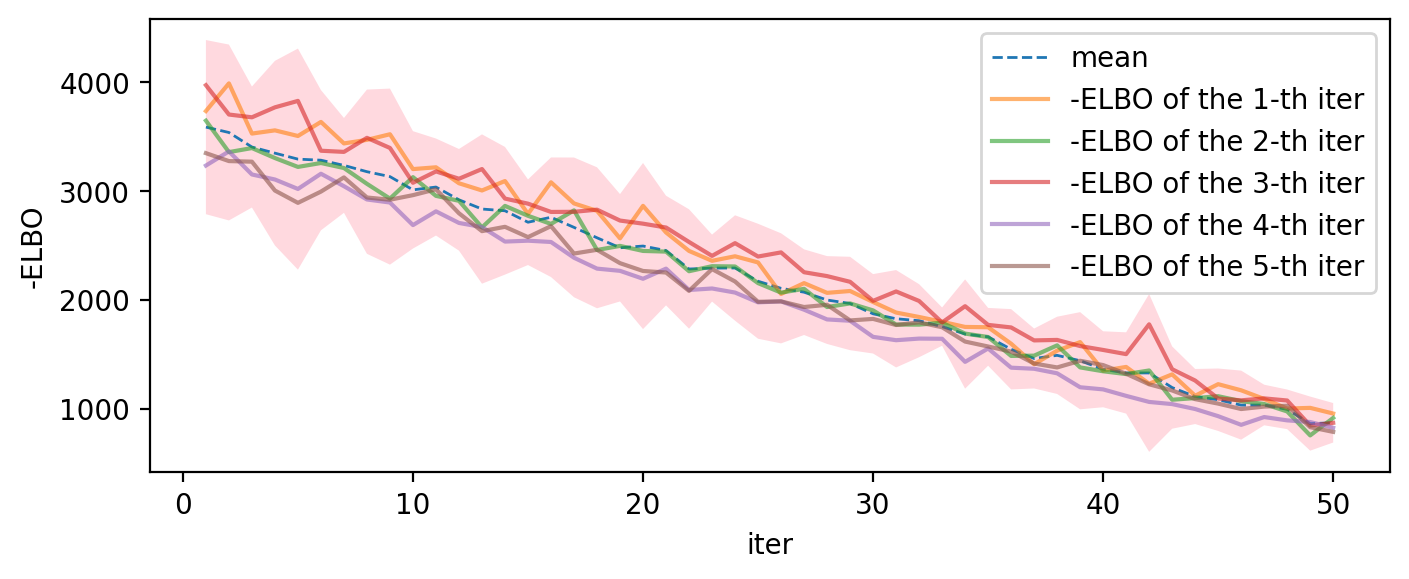

In [80]:
plt.figure(figsize=(8,3),dpi=200)
X = np.arange(1,len(info[0])+1,1)
mean = np.array(info).mean(axis=0).ravel()
mean = np.ones(shape=mean.shape)*mean
std = np.array(info).std(axis=0).ravel()
std = np.ones(shape=std.shape)*std
plt.plot(X,mean,'--',label='mean',lineWidth=1)
plt.fill_between(X,y1=mean+3*std,y2=mean-3*std,alpha=0.6,facecolor='pink')

for i in range(len(info)):
    plt.plot(X,info[i],label='-ELBO of the {}-th iter'.format(i+1),alpha=0.6)
plt.xlabel('iter')
plt.ylabel('-ELBO')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [2]:
def generate_incomplete_data(num_sample:int=10, time_horizon:float=5.0):
        gen = Logic_Model_Generator()
        data = gen.generate_data(num_sample=num_sample, time_horizon=time_horizon)
        action_history = {}
        for i in range(num_sample):
            action_history_ = dict([(key, data[i][key]) for key in [3,4,5,6]])
            action_history[i] = action_history_
        #NOTE: info
        print('[INFO] data has been generated!!!')
        return action_history

info = []
times = 8
for time in range(times):
    action_history = generate_incomplete_data(num_sample=20,time_horizon=0.5)
    learn = Logic_Model_Incomplete_Data(time_horizon=0.5,action_history=action_history,hidden_size=(15,20),output_size=(20,4),batch_size=20,num_layers=(2,6))
    losses = learn.train_model(num_iter=150,lr=(0.01,0.01))
    info.append(losses)

[INFO] data has been generated!!!


  1%|          | 1/150 [00:05<13:33,  5.46s/it]

iter >> 1; loss >> [3661.6836]


  1%|▏         | 2/150 [00:06<06:54,  2.80s/it]

iter >> 2; loss >> [3592.9194]


  2%|▏         | 3/150 [00:07<04:51,  1.98s/it]

iter >> 3; loss >> [3521.9336]


  3%|▎         | 4/150 [00:08<03:49,  1.57s/it]

iter >> 4; loss >> [3629.795]


  3%|▎         | 5/150 [00:09<03:13,  1.33s/it]

iter >> 5; loss >> [3446.0327]


  4%|▍         | 6/150 [00:10<02:51,  1.19s/it]

iter >> 6; loss >> [3326.9802]


  5%|▍         | 7/150 [00:11<02:44,  1.15s/it]

iter >> 7; loss >> [3196.218]


  5%|▌         | 8/150 [00:12<02:39,  1.12s/it]

iter >> 8; loss >> [3241.4663]


  6%|▌         | 9/150 [00:13<02:39,  1.13s/it]

iter >> 9; loss >> [3196.2844]


  7%|▋         | 10/150 [00:14<02:28,  1.06s/it]

iter >> 10; loss >> [3201.3018]


  7%|▋         | 11/150 [00:15<02:20,  1.01s/it]

iter >> 11; loss >> [3121.019]


  8%|▊         | 12/150 [00:16<02:20,  1.02s/it]

iter >> 12; loss >> [2936.2993]


  9%|▊         | 13/150 [00:17<02:20,  1.02s/it]

iter >> 13; loss >> [3003.521]


  9%|▉         | 14/150 [00:18<02:12,  1.03it/s]

iter >> 14; loss >> [2930.304]


 10%|█         | 15/150 [00:19<02:07,  1.06it/s]

iter >> 15; loss >> [2865.2542]


 11%|█         | 16/150 [00:19<02:05,  1.07it/s]

iter >> 16; loss >> [2808.86]


 11%|█▏        | 17/150 [00:20<02:03,  1.07it/s]

iter >> 17; loss >> [2731.852]


 12%|█▏        | 18/150 [00:21<02:02,  1.08it/s]

iter >> 18; loss >> [2625.6296]


 13%|█▎        | 19/150 [00:22<02:08,  1.02it/s]

iter >> 19; loss >> [2798.0317]


 13%|█▎        | 20/150 [00:23<02:08,  1.01it/s]

iter >> 20; loss >> [2503.0366]


 14%|█▍        | 21/150 [00:24<02:09,  1.01s/it]

iter >> 21; loss >> [2505.749]


 15%|█▍        | 22/150 [00:25<02:05,  1.02it/s]

iter >> 22; loss >> [2447.2993]


 15%|█▌        | 23/150 [00:26<02:04,  1.02it/s]

iter >> 23; loss >> [2590.5781]


 16%|█▌        | 24/150 [00:27<02:02,  1.03it/s]

iter >> 24; loss >> [2294.5356]


 17%|█▋        | 25/150 [00:28<02:00,  1.04it/s]

iter >> 25; loss >> [2239.0474]


 17%|█▋        | 26/150 [00:29<01:57,  1.06it/s]

iter >> 26; loss >> [2219.5872]


 18%|█▊        | 27/150 [00:30<01:55,  1.07it/s]

iter >> 27; loss >> [2210.8845]


 19%|█▊        | 28/150 [00:31<01:53,  1.07it/s]

iter >> 28; loss >> [2164.51]


 19%|█▉        | 29/150 [00:32<01:56,  1.04it/s]

iter >> 29; loss >> [2006.1279]


 20%|██        | 30/150 [00:33<01:53,  1.06it/s]

iter >> 30; loss >> [1907.7784]


 21%|██        | 31/150 [00:34<01:52,  1.06it/s]

iter >> 31; loss >> [1985.3572]


 21%|██▏       | 32/150 [00:35<01:52,  1.05it/s]

iter >> 32; loss >> [1820.334]


 22%|██▏       | 33/150 [00:36<01:51,  1.05it/s]

iter >> 33; loss >> [1911.3213]


 23%|██▎       | 34/150 [00:37<01:49,  1.06it/s]

iter >> 34; loss >> [1806.1481]


 23%|██▎       | 35/150 [00:38<01:47,  1.07it/s]

iter >> 35; loss >> [1759.6228]


 24%|██▍       | 36/150 [00:39<01:47,  1.06it/s]

iter >> 36; loss >> [1800.813]


 25%|██▍       | 37/150 [00:40<01:47,  1.05it/s]

iter >> 37; loss >> [1718.5199]


 25%|██▌       | 38/150 [00:40<01:44,  1.08it/s]

iter >> 38; loss >> [1547.0779]


 26%|██▌       | 39/150 [00:41<01:44,  1.06it/s]

iter >> 39; loss >> [1495.7095]


 27%|██▋       | 40/150 [00:42<01:42,  1.07it/s]

iter >> 40; loss >> [1524.596]


 27%|██▋       | 41/150 [00:43<01:43,  1.05it/s]

iter >> 41; loss >> [1488.6865]


 28%|██▊       | 42/150 [00:44<01:42,  1.05it/s]

iter >> 42; loss >> [1360.5435]


 29%|██▊       | 43/150 [00:45<01:40,  1.06it/s]

iter >> 43; loss >> [1235.9939]


 29%|██▉       | 44/150 [00:46<01:39,  1.06it/s]

iter >> 44; loss >> [1233.3887]


 30%|███       | 45/150 [00:47<01:38,  1.06it/s]

iter >> 45; loss >> [1235.0552]


 31%|███       | 46/150 [00:48<01:38,  1.06it/s]

iter >> 46; loss >> [1127.7028]


 31%|███▏      | 47/150 [00:49<01:37,  1.06it/s]

iter >> 47; loss >> [1200.1869]


 32%|███▏      | 48/150 [00:50<01:38,  1.03it/s]

iter >> 48; loss >> [1036.6014]


 33%|███▎      | 49/150 [00:51<01:38,  1.03it/s]

iter >> 49; loss >> [982.10767]


 33%|███▎      | 50/150 [00:52<01:36,  1.04it/s]

iter >> 50; loss >> [975.06903]


 34%|███▍      | 51/150 [00:53<01:33,  1.06it/s]

iter >> 51; loss >> [797.6584]


 35%|███▍      | 52/150 [00:54<01:31,  1.07it/s]

iter >> 52; loss >> [807.8939]


 35%|███▌      | 53/150 [00:55<01:31,  1.06it/s]

iter >> 53; loss >> [695.6063]


 36%|███▌      | 54/150 [00:56<01:31,  1.05it/s]

iter >> 54; loss >> [862.27527]


 37%|███▋      | 55/150 [00:57<01:28,  1.07it/s]

iter >> 55; loss >> [668.1398]


 37%|███▋      | 56/150 [00:58<01:30,  1.04it/s]

iter >> 56; loss >> [562.6984]


 38%|███▊      | 57/150 [00:59<01:29,  1.04it/s]

iter >> 57; loss >> [621.89923]


 39%|███▊      | 58/150 [01:00<01:29,  1.03it/s]

iter >> 58; loss >> [453.32074]


 39%|███▉      | 59/150 [01:00<01:26,  1.06it/s]

iter >> 59; loss >> [477.07874]


 40%|████      | 60/150 [01:01<01:24,  1.07it/s]

iter >> 60; loss >> [396.70703]


 41%|████      | 61/150 [01:02<01:22,  1.07it/s]

iter >> 61; loss >> [468.64532]


 41%|████▏     | 62/150 [01:03<01:21,  1.07it/s]

iter >> 62; loss >> [335.30334]


 42%|████▏     | 63/150 [01:04<01:22,  1.06it/s]

iter >> 63; loss >> [297.54602]


 43%|████▎     | 64/150 [01:05<01:21,  1.06it/s]

iter >> 64; loss >> [285.638]


 43%|████▎     | 65/150 [01:06<01:21,  1.04it/s]

iter >> 65; loss >> [228.60182]


 44%|████▍     | 66/150 [01:07<01:20,  1.04it/s]

iter >> 66; loss >> [172.26831]


 45%|████▍     | 67/150 [01:08<01:18,  1.05it/s]

iter >> 67; loss >> [-14.921755]


 45%|████▌     | 68/150 [01:09<01:16,  1.08it/s]

iter >> 68; loss >> [-58.922848]


 46%|████▌     | 69/150 [01:10<01:15,  1.07it/s]

iter >> 69; loss >> [2.0906374]


 47%|████▋     | 70/150 [01:11<01:14,  1.08it/s]

iter >> 70; loss >> [96.68099]


 47%|████▋     | 71/150 [01:12<01:14,  1.06it/s]

iter >> 71; loss >> [-69.43419]


 48%|████▊     | 72/150 [01:13<01:12,  1.07it/s]

iter >> 72; loss >> [-213.28758]


 49%|████▊     | 73/150 [01:14<01:10,  1.09it/s]

iter >> 73; loss >> [-142.0011]


 49%|████▉     | 74/150 [01:15<01:12,  1.05it/s]

iter >> 74; loss >> [-484.0021]


 50%|█████     | 75/150 [01:16<01:12,  1.04it/s]

iter >> 75; loss >> [-216.62613]


 51%|█████     | 76/150 [01:16<01:09,  1.06it/s]

iter >> 76; loss >> [-346.6344]


 51%|█████▏    | 77/150 [01:17<01:08,  1.07it/s]

iter >> 77; loss >> [-375.88904]


 52%|█████▏    | 78/150 [01:18<01:08,  1.06it/s]

iter >> 78; loss >> [-491.4812]


 53%|█████▎    | 79/150 [01:19<01:07,  1.05it/s]

iter >> 79; loss >> [-542.0315]


 53%|█████▎    | 80/150 [01:20<01:05,  1.06it/s]

iter >> 80; loss >> [-522.19324]


 54%|█████▍    | 81/150 [01:21<01:04,  1.07it/s]

iter >> 81; loss >> [-641.8866]


 55%|█████▍    | 82/150 [01:22<01:02,  1.08it/s]

iter >> 82; loss >> [-760.71844]


 55%|█████▌    | 83/150 [01:23<01:04,  1.04it/s]

iter >> 83; loss >> [-706.7606]


 56%|█████▌    | 84/150 [01:24<01:03,  1.04it/s]

iter >> 84; loss >> [-648.367]


 57%|█████▋    | 85/150 [01:25<01:01,  1.05it/s]

iter >> 85; loss >> [-796.3816]


 57%|█████▋    | 86/150 [01:26<01:00,  1.05it/s]

iter >> 86; loss >> [-744.47235]


 58%|█████▊    | 87/150 [01:27<00:59,  1.06it/s]

iter >> 87; loss >> [-982.74316]


 59%|█████▊    | 88/150 [01:28<00:58,  1.06it/s]

iter >> 88; loss >> [-1039.3812]


 59%|█████▉    | 89/150 [01:29<00:57,  1.07it/s]

iter >> 89; loss >> [-1132.7734]


 60%|██████    | 90/150 [01:30<00:55,  1.08it/s]

iter >> 90; loss >> [-756.2851]


 61%|██████    | 91/150 [01:31<00:55,  1.07it/s]

iter >> 91; loss >> [-980.39624]


 61%|██████▏   | 92/150 [01:32<00:55,  1.04it/s]

iter >> 92; loss >> [-1130.537]


 62%|██████▏   | 93/150 [01:32<00:53,  1.07it/s]

iter >> 93; loss >> [-1221.2999]


 63%|██████▎   | 94/150 [01:33<00:52,  1.07it/s]

iter >> 94; loss >> [-1215.953]


 63%|██████▎   | 95/150 [01:34<00:51,  1.07it/s]

iter >> 95; loss >> [-1361.3057]


 64%|██████▍   | 96/150 [01:35<00:50,  1.06it/s]

iter >> 96; loss >> [-1208.3412]


 65%|██████▍   | 97/150 [01:36<00:50,  1.06it/s]

iter >> 97; loss >> [-1359.7148]


 65%|██████▌   | 98/150 [01:37<00:49,  1.06it/s]

iter >> 98; loss >> [-1500.9524]


 66%|██████▌   | 99/150 [01:38<00:47,  1.07it/s]

iter >> 99; loss >> [-1407.6973]


 67%|██████▋   | 100/150 [01:39<00:48,  1.04it/s]

iter >> 100; loss >> [-1469.3113]


 67%|██████▋   | 101/150 [01:40<00:46,  1.04it/s]

iter >> 101; loss >> [-1574.5259]


 68%|██████▊   | 102/150 [01:41<00:45,  1.06it/s]

iter >> 102; loss >> [-1586.0511]


 69%|██████▊   | 103/150 [01:42<00:44,  1.05it/s]

iter >> 103; loss >> [-1751.9053]


 69%|██████▉   | 104/150 [01:43<00:44,  1.04it/s]

iter >> 104; loss >> [-1531.7274]


 70%|███████   | 105/150 [01:44<00:43,  1.04it/s]

iter >> 105; loss >> [-1595.9686]


 71%|███████   | 106/150 [01:45<00:41,  1.05it/s]

iter >> 106; loss >> [-2021.3328]


 71%|███████▏  | 107/150 [01:46<00:40,  1.05it/s]

iter >> 107; loss >> [-1660.5508]


 72%|███████▏  | 108/150 [01:47<00:40,  1.05it/s]

iter >> 108; loss >> [-1797.0636]


 73%|███████▎  | 109/150 [01:48<00:39,  1.04it/s]

iter >> 109; loss >> [-2038.0579]


 73%|███████▎  | 110/150 [01:49<00:38,  1.03it/s]

iter >> 110; loss >> [-1983.0865]


 74%|███████▍  | 111/150 [01:50<00:37,  1.04it/s]

iter >> 111; loss >> [-1963.4735]


 75%|███████▍  | 112/150 [01:51<00:36,  1.05it/s]

iter >> 112; loss >> [-1874.8582]


 75%|███████▌  | 113/150 [01:52<00:35,  1.04it/s]

iter >> 113; loss >> [-1968.3682]


 76%|███████▌  | 114/150 [01:52<00:34,  1.05it/s]

iter >> 114; loss >> [-2236.2856]


 77%|███████▋  | 115/150 [01:53<00:33,  1.06it/s]

iter >> 115; loss >> [-2206.864]


 77%|███████▋  | 116/150 [01:54<00:31,  1.06it/s]

iter >> 116; loss >> [-2335.0068]


 78%|███████▊  | 117/150 [01:55<00:31,  1.05it/s]

iter >> 117; loss >> [-2173.866]


 79%|███████▊  | 118/150 [01:56<00:30,  1.05it/s]

iter >> 118; loss >> [-2543.6382]


 79%|███████▉  | 119/150 [01:57<00:29,  1.04it/s]

iter >> 119; loss >> [-2125.703]


 80%|████████  | 120/150 [01:58<00:28,  1.04it/s]

iter >> 120; loss >> [-2217.0051]


 81%|████████  | 121/150 [01:59<00:27,  1.04it/s]

iter >> 121; loss >> [-2409.5376]


 81%|████████▏ | 122/150 [02:00<00:26,  1.05it/s]

iter >> 122; loss >> [-2305.8926]


 82%|████████▏ | 123/150 [02:01<00:25,  1.06it/s]

iter >> 123; loss >> [-2518.2056]


 83%|████████▎ | 124/150 [02:02<00:24,  1.06it/s]

iter >> 124; loss >> [-2403.2002]


 83%|████████▎ | 125/150 [02:03<00:23,  1.06it/s]

iter >> 125; loss >> [-2282.915]


 84%|████████▍ | 126/150 [02:04<00:22,  1.05it/s]

iter >> 126; loss >> [-2421.8555]


 85%|████████▍ | 127/150 [02:05<00:21,  1.05it/s]

iter >> 127; loss >> [-2449.7183]


 85%|████████▌ | 128/150 [02:06<00:20,  1.06it/s]

iter >> 128; loss >> [-2426.6328]


 86%|████████▌ | 129/150 [02:07<00:19,  1.06it/s]

iter >> 129; loss >> [-2524.2974]


 87%|████████▋ | 130/150 [02:08<00:18,  1.06it/s]

iter >> 130; loss >> [-2629.5103]


 87%|████████▋ | 131/150 [02:09<00:17,  1.06it/s]

iter >> 131; loss >> [-2704.452]


 88%|████████▊ | 132/150 [02:10<00:16,  1.07it/s]

iter >> 132; loss >> [-2747.6704]


 89%|████████▊ | 133/150 [02:10<00:15,  1.07it/s]

iter >> 133; loss >> [-2882.314]


 89%|████████▉ | 134/150 [02:11<00:15,  1.06it/s]

iter >> 134; loss >> [-3296.6494]


 90%|█████████ | 135/150 [02:12<00:14,  1.06it/s]

iter >> 135; loss >> [-3037.6926]


 91%|█████████ | 136/150 [02:13<00:13,  1.05it/s]

iter >> 136; loss >> [-3168.476]


 91%|█████████▏| 137/150 [02:14<00:12,  1.05it/s]

iter >> 137; loss >> [-3187.2495]


 92%|█████████▏| 138/150 [02:15<00:11,  1.03it/s]

iter >> 138; loss >> [-3232.6636]


 93%|█████████▎| 139/150 [02:16<00:10,  1.04it/s]

iter >> 139; loss >> [-3120.1208]


 93%|█████████▎| 140/150 [02:17<00:09,  1.05it/s]

iter >> 140; loss >> [-3085.4563]


 94%|█████████▍| 141/150 [02:18<00:08,  1.06it/s]

iter >> 141; loss >> [-2912.8086]


 95%|█████████▍| 142/150 [02:19<00:07,  1.05it/s]

iter >> 142; loss >> [-3110.2258]


 95%|█████████▌| 143/150 [02:20<00:06,  1.05it/s]

iter >> 143; loss >> [-3251.886]


 96%|█████████▌| 144/150 [02:21<00:05,  1.05it/s]

iter >> 144; loss >> [-3474.304]


 97%|█████████▋| 145/150 [02:22<00:04,  1.04it/s]

iter >> 145; loss >> [-3119.6553]


 97%|█████████▋| 146/150 [02:23<00:03,  1.05it/s]

iter >> 146; loss >> [-3449.7441]


 98%|█████████▊| 147/150 [02:24<00:02,  1.05it/s]

iter >> 147; loss >> [-3675.6565]


 99%|█████████▊| 148/150 [02:25<00:01,  1.07it/s]

iter >> 148; loss >> [-3505.422]


 99%|█████████▉| 149/150 [02:26<00:00,  1.08it/s]

iter >> 149; loss >> [-3506.9434]


100%|██████████| 150/150 [02:27<00:00,  1.02it/s]


iter >> 150; loss >> [-3378.6396]
[INFO] data has been generated!!!


  1%|          | 1/150 [00:00<02:21,  1.05it/s]

iter >> 1; loss >> [3661.3025]


  1%|▏         | 2/150 [00:01<02:15,  1.10it/s]

iter >> 2; loss >> [3671.2332]


  2%|▏         | 3/150 [00:02<02:14,  1.09it/s]

iter >> 3; loss >> [3426.7168]


  3%|▎         | 4/150 [00:03<02:18,  1.06it/s]

iter >> 4; loss >> [3620.2856]


  3%|▎         | 5/150 [00:04<02:18,  1.05it/s]

iter >> 5; loss >> [3231.2986]


  4%|▍         | 6/150 [00:05<02:15,  1.07it/s]

iter >> 6; loss >> [3694.4683]


  5%|▍         | 7/150 [00:06<02:13,  1.07it/s]

iter >> 7; loss >> [3307.2998]


  5%|▌         | 8/150 [00:07<02:13,  1.06it/s]

iter >> 8; loss >> [3370.6938]


  6%|▌         | 9/150 [00:08<02:15,  1.04it/s]

iter >> 9; loss >> [3315.781]


  7%|▋         | 10/150 [00:09<02:14,  1.04it/s]

iter >> 10; loss >> [3074.0728]


  7%|▋         | 11/150 [00:10<02:10,  1.06it/s]

iter >> 11; loss >> [3285.1304]


  8%|▊         | 12/150 [00:11<02:08,  1.07it/s]

iter >> 12; loss >> [3024.4673]


  9%|▊         | 13/150 [00:12<02:12,  1.04it/s]

iter >> 13; loss >> [2893.3997]


  9%|▉         | 14/150 [00:13<02:10,  1.04it/s]

iter >> 14; loss >> [3155.348]


 10%|█         | 15/150 [00:14<02:06,  1.07it/s]

iter >> 15; loss >> [2811.4224]


 11%|█         | 16/150 [00:15<02:04,  1.07it/s]

iter >> 16; loss >> [2763.3303]


 11%|█▏        | 17/150 [00:16<02:04,  1.07it/s]

iter >> 17; loss >> [2660.9175]


 12%|█▏        | 18/150 [00:16<02:04,  1.06it/s]

iter >> 18; loss >> [2595.8494]


 13%|█▎        | 19/150 [00:17<02:02,  1.07it/s]

iter >> 19; loss >> [2510.6882]


 13%|█▎        | 20/150 [00:18<02:00,  1.08it/s]

iter >> 20; loss >> [2761.0923]


 14%|█▍        | 21/150 [00:19<02:02,  1.05it/s]

iter >> 21; loss >> [2407.0078]


 15%|█▍        | 22/150 [00:20<02:01,  1.05it/s]

iter >> 22; loss >> [2472.765]


 15%|█▌        | 23/150 [00:21<01:58,  1.07it/s]

iter >> 23; loss >> [2329.7961]


 16%|█▌        | 24/150 [00:22<01:57,  1.08it/s]

iter >> 24; loss >> [2236.1277]


 17%|█▋        | 25/150 [00:23<01:55,  1.08it/s]

iter >> 25; loss >> [2127.5193]


 17%|█▋        | 26/150 [00:24<01:55,  1.07it/s]

iter >> 26; loss >> [2244.4883]


 18%|█▊        | 27/150 [00:25<01:56,  1.05it/s]

iter >> 27; loss >> [2076.248]


 19%|█▊        | 28/150 [00:26<01:53,  1.07it/s]

iter >> 28; loss >> [1993.2277]


 19%|█▉        | 29/150 [00:27<01:53,  1.07it/s]

iter >> 29; loss >> [1893.5505]


 20%|██        | 30/150 [00:28<01:52,  1.06it/s]

iter >> 30; loss >> [1971.4724]


 21%|██        | 31/150 [00:29<01:54,  1.04it/s]

iter >> 31; loss >> [1885.0604]


 21%|██▏       | 32/150 [00:30<01:50,  1.07it/s]

iter >> 32; loss >> [1840.0807]


 22%|██▏       | 33/150 [00:31<01:48,  1.08it/s]

iter >> 33; loss >> [1701.6716]


 23%|██▎       | 34/150 [00:31<01:47,  1.08it/s]

iter >> 34; loss >> [1567.9906]


 23%|██▎       | 35/150 [00:32<01:47,  1.07it/s]

iter >> 35; loss >> [1667.2251]


 24%|██▍       | 36/150 [00:33<01:45,  1.08it/s]

iter >> 36; loss >> [1743.2465]


 25%|██▍       | 37/150 [00:34<01:44,  1.08it/s]

iter >> 37; loss >> [1581.9117]


 25%|██▌       | 38/150 [00:35<01:44,  1.07it/s]

iter >> 38; loss >> [1472.9482]


 26%|██▌       | 39/150 [00:36<01:44,  1.06it/s]

iter >> 39; loss >> [1354.0526]


 27%|██▋       | 40/150 [00:37<01:45,  1.04it/s]

iter >> 40; loss >> [1306.4447]


 27%|██▋       | 41/150 [00:38<01:42,  1.06it/s]

iter >> 41; loss >> [1191.6362]


 28%|██▊       | 42/150 [00:39<01:41,  1.06it/s]

iter >> 42; loss >> [1141.5436]


 29%|██▊       | 43/150 [00:40<01:41,  1.05it/s]

iter >> 43; loss >> [1180.4568]


 29%|██▉       | 44/150 [00:41<01:39,  1.06it/s]

iter >> 44; loss >> [1239.0579]


 30%|███       | 45/150 [00:42<01:37,  1.08it/s]

iter >> 45; loss >> [1226.5378]


 31%|███       | 46/150 [00:43<01:35,  1.08it/s]

iter >> 46; loss >> [1060.2886]


 31%|███▏      | 47/150 [00:44<01:34,  1.09it/s]

iter >> 47; loss >> [912.3546]


 32%|███▏      | 48/150 [00:45<01:37,  1.05it/s]

iter >> 48; loss >> [870.8546]


 33%|███▎      | 49/150 [00:46<01:34,  1.07it/s]

iter >> 49; loss >> [924.62006]


 33%|███▎      | 50/150 [00:46<01:33,  1.07it/s]

iter >> 50; loss >> [814.65753]


 34%|███▍      | 51/150 [00:47<01:32,  1.08it/s]

iter >> 51; loss >> [731.0153]


 35%|███▍      | 52/150 [00:49<01:38,  1.00s/it]

iter >> 52; loss >> [682.9828]


 35%|███▌      | 53/150 [00:49<01:34,  1.02it/s]

iter >> 53; loss >> [646.0831]


 36%|███▌      | 54/150 [00:50<01:32,  1.04it/s]

iter >> 54; loss >> [570.77795]


 37%|███▋      | 55/150 [00:51<01:31,  1.04it/s]

iter >> 55; loss >> [640.35205]


 37%|███▋      | 56/150 [00:52<01:31,  1.03it/s]

iter >> 56; loss >> [423.04474]


 38%|███▊      | 57/150 [00:53<01:30,  1.03it/s]

iter >> 57; loss >> [418.74295]


 39%|███▊      | 58/150 [00:54<01:28,  1.04it/s]

iter >> 58; loss >> [333.4439]


 39%|███▉      | 59/150 [00:55<01:26,  1.05it/s]

iter >> 59; loss >> [262.87057]


 40%|████      | 60/150 [00:56<01:26,  1.05it/s]

iter >> 60; loss >> [191.5577]


 41%|████      | 61/150 [00:57<01:23,  1.07it/s]

iter >> 61; loss >> [217.1567]


 41%|████▏     | 62/150 [00:58<01:23,  1.05it/s]

iter >> 62; loss >> [281.40704]


 42%|████▏     | 63/150 [00:59<01:21,  1.06it/s]

iter >> 63; loss >> [170.1824]


 43%|████▎     | 64/150 [01:00<01:21,  1.05it/s]

iter >> 64; loss >> [95.40221]


 43%|████▎     | 65/150 [01:01<01:20,  1.05it/s]

iter >> 65; loss >> [176.8996]


 44%|████▍     | 66/150 [01:02<01:20,  1.05it/s]

iter >> 66; loss >> [-98.29526]


 45%|████▍     | 67/150 [01:03<01:18,  1.05it/s]

iter >> 67; loss >> [-146.17618]


 45%|████▌     | 68/150 [01:04<01:17,  1.06it/s]

iter >> 68; loss >> [-68.19333]


 46%|████▌     | 69/150 [01:05<01:16,  1.06it/s]

iter >> 69; loss >> [-188.20671]


 47%|████▋     | 70/150 [01:06<01:14,  1.08it/s]

iter >> 70; loss >> [-224.29276]


 47%|████▋     | 71/150 [01:06<01:12,  1.09it/s]

iter >> 71; loss >> [-362.2987]


 48%|████▊     | 72/150 [01:07<01:12,  1.08it/s]

iter >> 72; loss >> [-321.96945]


 49%|████▊     | 73/150 [01:08<01:11,  1.07it/s]

iter >> 73; loss >> [-388.23334]


 49%|████▉     | 74/150 [01:09<01:10,  1.08it/s]

iter >> 74; loss >> [-357.99136]


 50%|█████     | 75/150 [01:10<01:10,  1.06it/s]

iter >> 75; loss >> [-628.05145]


 51%|█████     | 76/150 [01:11<01:09,  1.06it/s]

iter >> 76; loss >> [-442.41928]


 51%|█████▏    | 77/150 [01:12<01:08,  1.06it/s]

iter >> 77; loss >> [-529.83777]


 52%|█████▏    | 78/150 [01:13<01:07,  1.07it/s]

iter >> 78; loss >> [-817.23706]


 53%|█████▎    | 79/150 [01:14<01:05,  1.08it/s]

iter >> 79; loss >> [-895.16296]


 53%|█████▎    | 80/150 [01:15<01:06,  1.06it/s]

iter >> 80; loss >> [-869.38684]


 54%|█████▍    | 81/150 [01:16<01:04,  1.06it/s]

iter >> 81; loss >> [-907.6794]


 55%|█████▍    | 82/150 [01:17<01:04,  1.06it/s]

iter >> 82; loss >> [-887.704]


 55%|█████▌    | 83/150 [01:18<01:02,  1.07it/s]

iter >> 83; loss >> [-1068.2616]


 56%|█████▌    | 84/150 [01:19<01:06,  1.01s/it]

iter >> 84; loss >> [-1186.8601]


 57%|█████▋    | 85/150 [01:20<01:05,  1.01s/it]

iter >> 85; loss >> [-1075.4572]


 57%|█████▋    | 86/150 [01:21<01:06,  1.04s/it]

iter >> 86; loss >> [-1260.6375]


 58%|█████▊    | 87/150 [01:22<01:03,  1.00s/it]

iter >> 87; loss >> [-1052.5334]


 59%|█████▊    | 88/150 [01:23<01:00,  1.03it/s]

iter >> 88; loss >> [-1112.5466]


 59%|█████▉    | 89/150 [01:24<00:58,  1.04it/s]

iter >> 89; loss >> [-1053.9307]


 60%|██████    | 90/150 [01:25<00:57,  1.05it/s]

iter >> 90; loss >> [-1310.1415]


 61%|██████    | 91/150 [01:26<00:55,  1.07it/s]

iter >> 91; loss >> [-1064.1096]


 61%|██████▏   | 92/150 [01:27<00:55,  1.05it/s]

iter >> 92; loss >> [-1557.3248]


 62%|██████▏   | 93/150 [01:27<00:53,  1.06it/s]

iter >> 93; loss >> [-1451.0454]


 63%|██████▎   | 94/150 [01:28<00:53,  1.05it/s]

iter >> 94; loss >> [-1437.6328]


 63%|██████▎   | 95/150 [01:29<00:51,  1.07it/s]

iter >> 95; loss >> [-1585.137]


 64%|██████▍   | 96/150 [01:30<00:50,  1.07it/s]

iter >> 96; loss >> [-1718.1285]


 65%|██████▍   | 97/150 [01:31<00:49,  1.07it/s]

iter >> 97; loss >> [-1536.723]


 65%|██████▌   | 98/150 [01:32<00:49,  1.06it/s]

iter >> 98; loss >> [-1721.2653]


 66%|██████▌   | 99/150 [01:33<00:47,  1.06it/s]

iter >> 99; loss >> [-1807.0006]


 67%|██████▋   | 100/150 [01:34<00:46,  1.07it/s]

iter >> 100; loss >> [-1592.1559]


 67%|██████▋   | 101/150 [01:35<00:45,  1.08it/s]

iter >> 101; loss >> [-1957.4847]


 68%|██████▊   | 102/150 [01:36<00:45,  1.06it/s]

iter >> 102; loss >> [-1690.3461]


 69%|██████▊   | 103/150 [01:37<00:43,  1.07it/s]

iter >> 103; loss >> [-1859.3752]


 69%|██████▉   | 104/150 [01:38<00:41,  1.10it/s]

iter >> 104; loss >> [-1976.2047]


 70%|███████   | 105/150 [01:39<00:40,  1.11it/s]

iter >> 105; loss >> [-1993.2261]


 71%|███████   | 106/150 [01:39<00:39,  1.11it/s]

iter >> 106; loss >> [-2217.4001]


 71%|███████▏  | 107/150 [01:40<00:38,  1.10it/s]

iter >> 107; loss >> [-1954.0033]


 72%|███████▏  | 108/150 [01:41<00:37,  1.11it/s]

iter >> 108; loss >> [-2376.069]


 73%|███████▎  | 109/150 [01:42<00:36,  1.12it/s]

iter >> 109; loss >> [-2146.708]


 73%|███████▎  | 110/150 [01:43<00:35,  1.12it/s]

iter >> 110; loss >> [-2008.8162]


 74%|███████▍  | 111/150 [01:44<00:35,  1.08it/s]

iter >> 111; loss >> [-2382.834]


 75%|███████▍  | 112/150 [01:45<00:34,  1.10it/s]

iter >> 112; loss >> [-2457.9756]


 75%|███████▌  | 113/150 [01:46<00:33,  1.11it/s]

iter >> 113; loss >> [-2460.2085]


 76%|███████▌  | 114/150 [01:47<00:32,  1.12it/s]

iter >> 114; loss >> [-2427.2373]


 77%|███████▋  | 115/150 [01:48<00:31,  1.12it/s]

iter >> 115; loss >> [-2439.5881]


 77%|███████▋  | 116/150 [01:49<00:31,  1.09it/s]

iter >> 116; loss >> [-2716.232]


 78%|███████▊  | 117/150 [01:50<00:32,  1.03it/s]

iter >> 117; loss >> [-2547.123]


 79%|███████▊  | 118/150 [01:51<00:31,  1.01it/s]

iter >> 118; loss >> [-2473.1538]


 79%|███████▉  | 119/150 [01:52<00:30,  1.01it/s]

iter >> 119; loss >> [-2778.259]


 80%|████████  | 120/150 [01:53<00:29,  1.00it/s]

iter >> 120; loss >> [-2647.6377]


 81%|████████  | 121/150 [01:54<00:28,  1.02it/s]

iter >> 121; loss >> [-2804.8293]


 81%|████████▏ | 122/150 [01:55<00:27,  1.00it/s]

iter >> 122; loss >> [-2820.41]


 82%|████████▏ | 123/150 [01:56<00:27,  1.01s/it]

iter >> 123; loss >> [-2941.841]


 83%|████████▎ | 124/150 [01:57<00:26,  1.01s/it]

iter >> 124; loss >> [-2888.5303]


 83%|████████▎ | 125/150 [01:58<00:24,  1.00it/s]

iter >> 125; loss >> [-2907.1814]


 84%|████████▍ | 126/150 [01:59<00:23,  1.02it/s]

iter >> 126; loss >> [-3079.6829]


 85%|████████▍ | 127/150 [02:00<00:22,  1.02it/s]

iter >> 127; loss >> [-2938.4795]


 85%|████████▌ | 128/150 [02:01<00:22,  1.01s/it]

iter >> 128; loss >> [-3254.639]


 86%|████████▌ | 129/150 [02:02<00:21,  1.01s/it]

iter >> 129; loss >> [-3033.439]


 87%|████████▋ | 130/150 [02:03<00:20,  1.02s/it]

iter >> 130; loss >> [-3040.4202]


 87%|████████▋ | 131/150 [02:04<00:19,  1.01s/it]

iter >> 131; loss >> [-3380.1023]


 88%|████████▊ | 132/150 [02:05<00:18,  1.01s/it]

iter >> 132; loss >> [-3216.8628]


 89%|████████▊ | 133/150 [02:06<00:16,  1.01it/s]

iter >> 133; loss >> [-3263.8096]


 89%|████████▉ | 134/150 [02:07<00:15,  1.01it/s]

iter >> 134; loss >> [-3115.5293]


 90%|█████████ | 135/150 [02:08<00:14,  1.02it/s]

iter >> 135; loss >> [-3135.853]


 91%|█████████ | 136/150 [02:09<00:13,  1.02it/s]

iter >> 136; loss >> [-3156.791]


 91%|█████████▏| 137/150 [02:10<00:13,  1.01s/it]

iter >> 137; loss >> [-3517.3442]


 92%|█████████▏| 138/150 [02:11<00:12,  1.02s/it]

iter >> 138; loss >> [-3487.0066]


 93%|█████████▎| 139/150 [02:12<00:11,  1.01s/it]

iter >> 139; loss >> [-3577.539]


 93%|█████████▎| 140/150 [02:13<00:10,  1.01s/it]

iter >> 140; loss >> [-3591.583]


 94%|█████████▍| 141/150 [02:14<00:09,  1.04s/it]

iter >> 141; loss >> [-3476.6467]


 95%|█████████▍| 142/150 [02:15<00:08,  1.04s/it]

iter >> 142; loss >> [-3544.1123]


 95%|█████████▌| 143/150 [02:16<00:07,  1.02s/it]

iter >> 143; loss >> [-3490.9348]


 96%|█████████▌| 144/150 [02:17<00:06,  1.01s/it]

iter >> 144; loss >> [-3480.8506]


 97%|█████████▋| 145/150 [02:18<00:05,  1.00s/it]

iter >> 145; loss >> [-3817.2866]


 97%|█████████▋| 146/150 [02:19<00:04,  1.02s/it]

iter >> 146; loss >> [-3717.1487]


 98%|█████████▊| 147/150 [02:20<00:03,  1.05s/it]

iter >> 147; loss >> [-3869.0825]


 99%|█████████▊| 148/150 [02:21<00:02,  1.07s/it]

iter >> 148; loss >> [-3633.125]


 99%|█████████▉| 149/150 [02:22<00:01,  1.09s/it]

iter >> 149; loss >> [-4099.543]


100%|██████████| 150/150 [02:23<00:00,  1.04it/s]


iter >> 150; loss >> [-3851.5322]
[INFO] data has been generated!!!


  1%|          | 1/150 [00:01<02:43,  1.10s/it]

iter >> 1; loss >> [3793.0667]


  1%|▏         | 2/150 [00:02<02:35,  1.05s/it]

iter >> 2; loss >> [3638.063]


  2%|▏         | 3/150 [00:03<02:37,  1.07s/it]

iter >> 3; loss >> [3609.5972]


  3%|▎         | 4/150 [00:04<02:23,  1.02it/s]

iter >> 4; loss >> [3523.9695]


  3%|▎         | 5/150 [00:05<02:22,  1.02it/s]

iter >> 5; loss >> [3356.8408]


  4%|▍         | 6/150 [00:05<02:18,  1.04it/s]

iter >> 6; loss >> [3493.721]


  5%|▍         | 7/150 [00:06<02:17,  1.04it/s]

iter >> 7; loss >> [3615.5986]


  5%|▌         | 8/150 [00:07<02:16,  1.04it/s]

iter >> 8; loss >> [3176.5024]


  6%|▌         | 9/150 [00:08<02:15,  1.04it/s]

iter >> 9; loss >> [3048.5947]


  7%|▋         | 10/150 [00:09<02:16,  1.02it/s]

iter >> 10; loss >> [3157.706]


  7%|▋         | 11/150 [00:10<02:17,  1.01it/s]

iter >> 11; loss >> [2983.5586]


  8%|▊         | 12/150 [00:11<02:17,  1.01it/s]

iter >> 12; loss >> [2982.5103]


  9%|▊         | 13/150 [00:12<02:17,  1.00s/it]

iter >> 13; loss >> [2876.686]


  9%|▉         | 14/150 [00:13<02:13,  1.02it/s]

iter >> 14; loss >> [2867.5525]


 10%|█         | 15/150 [00:14<02:05,  1.07it/s]

iter >> 15; loss >> [2804.4321]


 11%|█         | 16/150 [00:15<02:01,  1.11it/s]

iter >> 16; loss >> [2666.9336]


 11%|█▏        | 17/150 [00:16<02:04,  1.07it/s]

iter >> 17; loss >> [2637.473]


 12%|█▏        | 18/150 [00:17<02:00,  1.10it/s]

iter >> 18; loss >> [2645.8643]


 13%|█▎        | 19/150 [00:18<02:03,  1.06it/s]

iter >> 19; loss >> [2529.5361]


 13%|█▎        | 20/150 [00:19<01:58,  1.10it/s]

iter >> 20; loss >> [2362.466]


 14%|█▍        | 21/150 [00:20<01:53,  1.13it/s]

iter >> 21; loss >> [2616.223]


 15%|█▍        | 22/150 [00:20<01:53,  1.13it/s]

iter >> 22; loss >> [2313.1953]


 15%|█▌        | 23/150 [00:21<01:52,  1.12it/s]

iter >> 23; loss >> [2424.6287]


 16%|█▌        | 24/150 [00:22<01:49,  1.15it/s]

iter >> 24; loss >> [2366.7893]


 17%|█▋        | 25/150 [00:23<01:47,  1.16it/s]

iter >> 25; loss >> [2228.8672]


 17%|█▋        | 26/150 [00:24<01:45,  1.18it/s]

iter >> 26; loss >> [2106.4211]


 18%|█▊        | 27/150 [00:25<01:43,  1.19it/s]

iter >> 27; loss >> [1984.01]


 19%|█▊        | 28/150 [00:25<01:42,  1.19it/s]

iter >> 28; loss >> [2389.4338]


 19%|█▉        | 29/150 [00:26<01:40,  1.20it/s]

iter >> 29; loss >> [1989.5676]


 20%|██        | 30/150 [00:27<01:40,  1.20it/s]

iter >> 30; loss >> [1939.053]


 21%|██        | 31/150 [00:28<01:39,  1.20it/s]

iter >> 31; loss >> [1969.6721]


 21%|██▏       | 32/150 [00:29<01:40,  1.17it/s]

iter >> 32; loss >> [1963.9623]


 22%|██▏       | 33/150 [00:30<01:38,  1.18it/s]

iter >> 33; loss >> [1592.0079]


 23%|██▎       | 34/150 [00:31<01:37,  1.19it/s]

iter >> 34; loss >> [1537.2188]


 23%|██▎       | 35/150 [00:31<01:36,  1.19it/s]

iter >> 35; loss >> [1592.2112]


 24%|██▍       | 36/150 [00:32<01:35,  1.19it/s]

iter >> 36; loss >> [1512.9956]


 25%|██▍       | 37/150 [00:33<01:34,  1.20it/s]

iter >> 37; loss >> [1392.2485]


 25%|██▌       | 38/150 [00:34<01:33,  1.20it/s]

iter >> 38; loss >> [1415.856]


 26%|██▌       | 39/150 [00:35<01:33,  1.19it/s]

iter >> 39; loss >> [1348.4543]


 27%|██▋       | 40/150 [00:36<01:36,  1.14it/s]

iter >> 40; loss >> [1270.3864]


 27%|██▋       | 41/150 [00:37<01:38,  1.11it/s]

iter >> 41; loss >> [1269.462]


 28%|██▊       | 42/150 [00:37<01:35,  1.13it/s]

iter >> 42; loss >> [1137.241]


 29%|██▊       | 43/150 [00:38<01:33,  1.15it/s]

iter >> 43; loss >> [1087.8079]


 29%|██▉       | 44/150 [00:39<01:31,  1.16it/s]

iter >> 44; loss >> [1013.65485]


 30%|███       | 45/150 [00:40<01:29,  1.18it/s]

iter >> 45; loss >> [971.68085]


 31%|███       | 46/150 [00:41<01:27,  1.19it/s]

iter >> 46; loss >> [1000.8959]


 31%|███▏      | 47/150 [00:42<01:26,  1.19it/s]

iter >> 47; loss >> [869.8933]


 32%|███▏      | 48/150 [00:42<01:25,  1.20it/s]

iter >> 48; loss >> [833.0486]


 33%|███▎      | 49/150 [00:43<01:26,  1.17it/s]

iter >> 49; loss >> [785.23096]


 33%|███▎      | 50/150 [00:44<01:24,  1.19it/s]

iter >> 50; loss >> [736.1647]


 34%|███▍      | 51/150 [00:45<01:22,  1.19it/s]

iter >> 51; loss >> [710.2961]


 35%|███▍      | 52/150 [00:46<01:21,  1.20it/s]

iter >> 52; loss >> [765.7023]


 35%|███▌      | 53/150 [00:47<01:20,  1.20it/s]

iter >> 53; loss >> [630.9922]


 36%|███▌      | 54/150 [00:47<01:19,  1.20it/s]

iter >> 54; loss >> [533.00854]


 37%|███▋      | 55/150 [00:48<01:18,  1.21it/s]

iter >> 55; loss >> [418.35242]


 37%|███▋      | 56/150 [00:49<01:18,  1.20it/s]

iter >> 56; loss >> [467.98962]


 38%|███▊      | 57/150 [00:50<01:17,  1.20it/s]

iter >> 57; loss >> [275.9945]


 39%|███▊      | 58/150 [00:51<01:18,  1.18it/s]

iter >> 58; loss >> [267.94803]


 39%|███▉      | 59/150 [00:52<01:16,  1.19it/s]

iter >> 59; loss >> [253.35312]


 40%|████      | 60/150 [00:52<01:15,  1.20it/s]

iter >> 60; loss >> [186.2977]


 41%|████      | 61/150 [00:53<01:14,  1.20it/s]

iter >> 61; loss >> [173.68008]


 41%|████▏     | 62/150 [00:54<01:13,  1.20it/s]

iter >> 62; loss >> [56.088722]


 42%|████▏     | 63/150 [00:55<01:12,  1.21it/s]

iter >> 63; loss >> [35.87162]


 43%|████▎     | 64/150 [00:56<01:11,  1.21it/s]

iter >> 64; loss >> [70.52041]


 43%|████▎     | 65/150 [00:57<01:10,  1.21it/s]

iter >> 65; loss >> [32.48967]


 44%|████▍     | 66/150 [00:57<01:09,  1.21it/s]

iter >> 66; loss >> [-135.76692]


 45%|████▍     | 67/150 [00:58<01:10,  1.18it/s]

iter >> 67; loss >> [-267.94604]


 45%|████▌     | 68/150 [00:59<01:08,  1.19it/s]

iter >> 68; loss >> [-225.30481]


 46%|████▌     | 69/150 [01:00<01:07,  1.20it/s]

iter >> 69; loss >> [-229.73996]


 47%|████▋     | 70/150 [01:01<01:06,  1.20it/s]

iter >> 70; loss >> [-338.5863]


 47%|████▋     | 71/150 [01:02<01:05,  1.20it/s]

iter >> 71; loss >> [-483.01294]


 48%|████▊     | 72/150 [01:02<01:04,  1.20it/s]

iter >> 72; loss >> [-605.8558]


 49%|████▊     | 73/150 [01:03<01:03,  1.20it/s]

iter >> 73; loss >> [-564.3429]


 49%|████▉     | 74/150 [01:04<01:03,  1.20it/s]

iter >> 74; loss >> [-711.44836]


 50%|█████     | 75/150 [01:05<01:02,  1.20it/s]

iter >> 75; loss >> [-768.0164]


 51%|█████     | 76/150 [01:06<01:03,  1.17it/s]

iter >> 76; loss >> [-610.1393]


 51%|█████▏    | 77/150 [01:07<01:01,  1.19it/s]

iter >> 77; loss >> [-913.98065]


 52%|█████▏    | 78/150 [01:07<01:00,  1.19it/s]

iter >> 78; loss >> [-623.6125]


 53%|█████▎    | 79/150 [01:08<00:59,  1.18it/s]

iter >> 79; loss >> [-848.1457]


 53%|█████▎    | 80/150 [01:09<00:58,  1.19it/s]

iter >> 80; loss >> [-893.41766]


 54%|█████▍    | 81/150 [01:10<00:57,  1.19it/s]

iter >> 81; loss >> [-915.16455]


 55%|█████▍    | 82/150 [01:11<00:56,  1.20it/s]

iter >> 82; loss >> [-942.0709]


 55%|█████▌    | 83/150 [01:12<00:55,  1.20it/s]

iter >> 83; loss >> [-1222.8756]


 56%|█████▌    | 84/150 [01:13<00:56,  1.17it/s]

iter >> 84; loss >> [-1184.333]


 57%|█████▋    | 85/150 [01:13<00:55,  1.18it/s]

iter >> 85; loss >> [-1258.895]


 57%|█████▋    | 86/150 [01:14<00:53,  1.19it/s]

iter >> 86; loss >> [-1238.6104]


 58%|█████▊    | 87/150 [01:15<00:52,  1.19it/s]

iter >> 87; loss >> [-1300.1272]


 59%|█████▊    | 88/150 [01:16<00:51,  1.20it/s]

iter >> 88; loss >> [-1245.3224]


 59%|█████▉    | 89/150 [01:17<00:50,  1.21it/s]

iter >> 89; loss >> [-1100.0571]


 60%|██████    | 90/150 [01:18<00:49,  1.20it/s]

iter >> 90; loss >> [-1325.2046]


 61%|██████    | 91/150 [01:18<00:48,  1.21it/s]

iter >> 91; loss >> [-1337.6287]


 61%|██████▏   | 92/150 [01:19<00:48,  1.21it/s]

iter >> 92; loss >> [-1713.5358]


 62%|██████▏   | 93/150 [01:20<00:47,  1.20it/s]

iter >> 93; loss >> [-1689.3489]


 63%|██████▎   | 94/150 [01:21<00:47,  1.18it/s]

iter >> 94; loss >> [-1668.4214]


 63%|██████▎   | 95/150 [01:22<00:46,  1.18it/s]

iter >> 95; loss >> [-1798.2576]


 64%|██████▍   | 96/150 [01:23<00:45,  1.19it/s]

iter >> 96; loss >> [-1795.6409]


 65%|██████▍   | 97/150 [01:23<00:44,  1.20it/s]

iter >> 97; loss >> [-1594.5953]


 65%|██████▌   | 98/150 [01:24<00:43,  1.20it/s]

iter >> 98; loss >> [-1822.2957]


 66%|██████▌   | 99/150 [01:25<00:42,  1.20it/s]

iter >> 99; loss >> [-1917.6971]


 67%|██████▋   | 100/150 [01:26<00:41,  1.21it/s]

iter >> 100; loss >> [-1997.5376]


 67%|██████▋   | 101/150 [01:27<00:40,  1.21it/s]

iter >> 101; loss >> [-2025.2656]


 68%|██████▊   | 102/150 [01:28<00:39,  1.21it/s]

iter >> 102; loss >> [-1997.8851]


 69%|██████▊   | 103/150 [01:28<00:39,  1.18it/s]

iter >> 103; loss >> [-2143.6345]


 69%|██████▉   | 104/150 [01:29<00:38,  1.18it/s]

iter >> 104; loss >> [-2111.4126]


 70%|███████   | 105/150 [01:30<00:37,  1.19it/s]

iter >> 105; loss >> [-1778.9417]


 71%|███████   | 106/150 [01:31<00:37,  1.19it/s]

iter >> 106; loss >> [-2330.674]


 71%|███████▏  | 107/150 [01:32<00:37,  1.15it/s]

iter >> 107; loss >> [-2465.5842]


 72%|███████▏  | 108/150 [01:33<00:36,  1.15it/s]

iter >> 108; loss >> [-2393.9292]


 73%|███████▎  | 109/150 [01:34<00:36,  1.14it/s]

iter >> 109; loss >> [-2651.029]


 73%|███████▎  | 110/150 [01:34<00:34,  1.16it/s]

iter >> 110; loss >> [-2295.7756]


 74%|███████▍  | 111/150 [01:35<00:33,  1.15it/s]

iter >> 111; loss >> [-2490.3237]


 75%|███████▍  | 112/150 [01:36<00:32,  1.16it/s]

iter >> 112; loss >> [-2835.5415]


 75%|███████▌  | 113/150 [01:37<00:31,  1.18it/s]

iter >> 113; loss >> [-2512.3872]


 76%|███████▌  | 114/150 [01:38<00:30,  1.17it/s]

iter >> 114; loss >> [-2629.5168]


 77%|███████▋  | 115/150 [01:39<00:30,  1.16it/s]

iter >> 115; loss >> [-2343.6567]


 77%|███████▋  | 116/150 [01:40<00:29,  1.17it/s]

iter >> 116; loss >> [-2558.723]


 78%|███████▊  | 117/150 [01:40<00:27,  1.18it/s]

iter >> 117; loss >> [-2783.9944]


 79%|███████▊  | 118/150 [01:41<00:27,  1.18it/s]

iter >> 118; loss >> [-2893.257]


 79%|███████▉  | 119/150 [01:42<00:26,  1.19it/s]

iter >> 119; loss >> [-2558.7976]


 80%|████████  | 120/150 [01:43<00:25,  1.17it/s]

iter >> 120; loss >> [-2885.9014]


 81%|████████  | 121/150 [01:44<00:24,  1.17it/s]

iter >> 121; loss >> [-3120.353]


 81%|████████▏ | 122/150 [01:45<00:23,  1.19it/s]

iter >> 122; loss >> [-3071.1284]


 82%|████████▏ | 123/150 [01:46<00:22,  1.19it/s]

iter >> 123; loss >> [-2949.3833]


 83%|████████▎ | 124/150 [01:46<00:21,  1.20it/s]

iter >> 124; loss >> [-3300.4116]


 83%|████████▎ | 125/150 [01:47<00:20,  1.19it/s]

iter >> 125; loss >> [-3159.6582]


 84%|████████▍ | 126/150 [01:48<00:20,  1.20it/s]

iter >> 126; loss >> [-3402.842]


 85%|████████▍ | 127/150 [01:49<00:19,  1.20it/s]

iter >> 127; loss >> [-3188.5667]


 85%|████████▌ | 128/150 [01:50<00:18,  1.20it/s]

iter >> 128; loss >> [-3294.0002]


 86%|████████▌ | 129/150 [01:51<00:17,  1.18it/s]

iter >> 129; loss >> [-3206.7222]


 87%|████████▋ | 130/150 [01:51<00:16,  1.19it/s]

iter >> 130; loss >> [-3624.1516]


 87%|████████▋ | 131/150 [01:52<00:15,  1.19it/s]

iter >> 131; loss >> [-3060.2603]


 88%|████████▊ | 132/150 [01:53<00:15,  1.20it/s]

iter >> 132; loss >> [-3222.673]


 89%|████████▊ | 133/150 [01:54<00:14,  1.20it/s]

iter >> 133; loss >> [-3565.0413]


 89%|████████▉ | 134/150 [01:55<00:13,  1.21it/s]

iter >> 134; loss >> [-3449.024]


 90%|█████████ | 135/150 [01:56<00:12,  1.21it/s]

iter >> 135; loss >> [-3445.8608]


 91%|█████████ | 136/150 [01:56<00:11,  1.20it/s]

iter >> 136; loss >> [-3678.8113]


 91%|█████████▏| 137/150 [01:57<00:11,  1.10it/s]

iter >> 137; loss >> [-3573.679]


 92%|█████████▏| 138/150 [01:59<00:12,  1.03s/it]

iter >> 138; loss >> [-3549.4763]


 93%|█████████▎| 139/150 [02:00<00:11,  1.07s/it]

iter >> 139; loss >> [-3820.243]


 93%|█████████▎| 140/150 [02:01<00:11,  1.10s/it]

iter >> 140; loss >> [-3641.8872]


 94%|█████████▍| 141/150 [02:02<00:10,  1.13s/it]

iter >> 141; loss >> [-3378.477]


 95%|█████████▍| 142/150 [02:03<00:09,  1.14s/it]

iter >> 142; loss >> [-3713.768]


 95%|█████████▌| 143/150 [02:05<00:08,  1.15s/it]

iter >> 143; loss >> [-3748.7488]


 96%|█████████▌| 144/150 [02:06<00:06,  1.15s/it]

iter >> 144; loss >> [-3536.67]


 97%|█████████▋| 145/150 [02:07<00:05,  1.15s/it]

iter >> 145; loss >> [-4137.125]


 97%|█████████▋| 146/150 [02:08<00:04,  1.16s/it]

iter >> 146; loss >> [-3920.0842]


 98%|█████████▊| 147/150 [02:09<00:03,  1.17s/it]

iter >> 147; loss >> [-4290.4575]


 99%|█████████▊| 148/150 [02:10<00:02,  1.11s/it]

iter >> 148; loss >> [-4256.29]


 99%|█████████▉| 149/150 [02:11<00:01,  1.12s/it]

iter >> 149; loss >> [-3904.4663]


100%|██████████| 150/150 [02:12<00:00,  1.13it/s]


iter >> 150; loss >> [-4190.1045]
[INFO] data has been generated!!!


  1%|          | 1/150 [00:00<02:12,  1.13it/s]

iter >> 1; loss >> [3327.8306]


  1%|▏         | 2/150 [00:01<02:12,  1.11it/s]

iter >> 2; loss >> [3239.883]


  2%|▏         | 3/150 [00:02<02:13,  1.10it/s]

iter >> 3; loss >> [3106.509]


  3%|▎         | 4/150 [00:03<02:16,  1.07it/s]

iter >> 4; loss >> [3154.2598]


  3%|▎         | 5/150 [00:04<02:19,  1.04it/s]

iter >> 5; loss >> [3147.6924]


  4%|▍         | 6/150 [00:05<02:15,  1.06it/s]

iter >> 6; loss >> [2983.9927]


  5%|▍         | 7/150 [00:06<02:16,  1.05it/s]

iter >> 7; loss >> [2974.]


  5%|▌         | 8/150 [00:07<02:21,  1.01it/s]

iter >> 8; loss >> [2972.395]


  6%|▌         | 9/150 [00:08<02:22,  1.01s/it]

iter >> 9; loss >> [2827.4004]


  7%|▋         | 10/150 [00:09<02:19,  1.00it/s]

iter >> 10; loss >> [2810.6614]


  7%|▋         | 11/150 [00:10<02:18,  1.00it/s]

iter >> 11; loss >> [2721.7336]


  8%|▊         | 12/150 [00:11<02:19,  1.01s/it]

iter >> 12; loss >> [2611.4114]


  9%|▊         | 13/150 [00:12<02:20,  1.03s/it]

iter >> 13; loss >> [2588.8928]


  9%|▉         | 14/150 [00:13<02:21,  1.04s/it]

iter >> 14; loss >> [2448.476]


 10%|█         | 15/150 [00:14<02:24,  1.07s/it]

iter >> 15; loss >> [2521.0222]


 11%|█         | 16/150 [00:16<02:21,  1.06s/it]

iter >> 16; loss >> [2523.9932]


 11%|█▏        | 17/150 [00:17<02:24,  1.09s/it]

iter >> 17; loss >> [2454.324]


 12%|█▏        | 18/150 [00:18<02:18,  1.05s/it]

iter >> 18; loss >> [2506.0977]


 13%|█▎        | 19/150 [00:19<02:21,  1.08s/it]

iter >> 19; loss >> [2284.526]


 13%|█▎        | 20/150 [00:20<02:23,  1.10s/it]

iter >> 20; loss >> [2281.5288]


 14%|█▍        | 21/150 [00:21<02:26,  1.13s/it]

iter >> 21; loss >> [2121.8738]


 15%|█▍        | 22/150 [00:22<02:26,  1.15s/it]

iter >> 22; loss >> [2148.1504]


 15%|█▌        | 23/150 [00:23<02:23,  1.13s/it]

iter >> 23; loss >> [2249.564]


 16%|█▌        | 24/150 [00:24<02:13,  1.06s/it]

iter >> 24; loss >> [2013.5455]


 17%|█▋        | 25/150 [00:25<02:05,  1.00s/it]

iter >> 25; loss >> [1922.7236]


 17%|█▋        | 26/150 [00:26<02:01,  1.02it/s]

iter >> 26; loss >> [1817.7544]


 18%|█▊        | 27/150 [00:27<02:00,  1.02it/s]

iter >> 27; loss >> [1882.7802]


 19%|█▊        | 28/150 [00:28<01:57,  1.03it/s]

iter >> 28; loss >> [1788.3397]


 19%|█▉        | 29/150 [00:29<01:59,  1.02it/s]

iter >> 29; loss >> [1778.1196]


 20%|██        | 30/150 [00:30<01:59,  1.00it/s]

iter >> 30; loss >> [1858.6833]


 21%|██        | 31/150 [00:31<02:05,  1.06s/it]

iter >> 31; loss >> [1680.448]


 21%|██▏       | 32/150 [00:32<02:03,  1.04s/it]

iter >> 32; loss >> [1574.6608]


 22%|██▏       | 33/150 [00:33<01:59,  1.02s/it]

iter >> 33; loss >> [1538.3837]


 23%|██▎       | 34/150 [00:34<01:51,  1.04it/s]

iter >> 34; loss >> [1583.4406]


 23%|██▎       | 35/150 [00:35<01:46,  1.08it/s]

iter >> 35; loss >> [1647.3047]


 24%|██▍       | 36/150 [00:36<01:41,  1.12it/s]

iter >> 36; loss >> [1406.1724]


 25%|██▍       | 37/150 [00:37<01:38,  1.15it/s]

iter >> 37; loss >> [1463.8232]


 25%|██▌       | 38/150 [00:37<01:35,  1.17it/s]

iter >> 38; loss >> [1506.8712]


 26%|██▌       | 39/150 [00:38<01:33,  1.18it/s]

iter >> 39; loss >> [1182.8966]


 27%|██▋       | 40/150 [00:39<01:32,  1.19it/s]

iter >> 40; loss >> [1108.8348]


 27%|██▋       | 41/150 [00:40<01:33,  1.17it/s]

iter >> 41; loss >> [1139.0176]


 28%|██▊       | 42/150 [00:41<01:31,  1.18it/s]

iter >> 42; loss >> [1075.6914]


 29%|██▊       | 43/150 [00:42<01:29,  1.19it/s]

iter >> 43; loss >> [1015.141]


 29%|██▉       | 44/150 [00:42<01:28,  1.20it/s]

iter >> 44; loss >> [1052.9348]


 30%|███       | 45/150 [00:43<01:27,  1.21it/s]

iter >> 45; loss >> [862.64355]


 31%|███       | 46/150 [00:44<01:25,  1.21it/s]

iter >> 46; loss >> [851.40454]


 31%|███▏      | 47/150 [00:45<01:25,  1.20it/s]

iter >> 47; loss >> [945.7929]


 32%|███▏      | 48/150 [00:46<01:24,  1.21it/s]

iter >> 48; loss >> [761.96216]


 33%|███▎      | 49/150 [00:47<01:23,  1.21it/s]

iter >> 49; loss >> [836.82]


 33%|███▎      | 50/150 [00:47<01:24,  1.18it/s]

iter >> 50; loss >> [664.9543]


 34%|███▍      | 51/150 [00:48<01:22,  1.19it/s]

iter >> 51; loss >> [654.5841]


 35%|███▍      | 52/150 [00:49<01:21,  1.20it/s]

iter >> 52; loss >> [609.4316]


 35%|███▌      | 53/150 [00:50<01:20,  1.21it/s]

iter >> 53; loss >> [633.7294]


 36%|███▌      | 54/150 [00:51<01:19,  1.21it/s]

iter >> 54; loss >> [439.78513]


 37%|███▋      | 55/150 [00:51<01:18,  1.21it/s]

iter >> 55; loss >> [424.53613]


 37%|███▋      | 56/150 [00:52<01:17,  1.21it/s]

iter >> 56; loss >> [513.94995]


 38%|███▊      | 57/150 [00:53<01:16,  1.21it/s]

iter >> 57; loss >> [295.3627]


 39%|███▊      | 58/150 [00:54<01:15,  1.22it/s]

iter >> 58; loss >> [327.51187]


 39%|███▉      | 59/150 [00:55<01:16,  1.19it/s]

iter >> 59; loss >> [426.37292]


 40%|████      | 60/150 [00:56<01:15,  1.20it/s]

iter >> 60; loss >> [241.77866]


 41%|████      | 61/150 [00:56<01:13,  1.20it/s]

iter >> 61; loss >> [200.9929]


 41%|████▏     | 62/150 [00:57<01:12,  1.21it/s]

iter >> 62; loss >> [106.04557]


 42%|████▏     | 63/150 [00:58<01:11,  1.21it/s]

iter >> 63; loss >> [66.26195]


 43%|████▎     | 64/150 [00:59<01:10,  1.22it/s]

iter >> 64; loss >> [-77.375145]


 43%|████▎     | 65/150 [01:00<01:10,  1.21it/s]

iter >> 65; loss >> [-105.832565]


 44%|████▍     | 66/150 [01:01<01:09,  1.22it/s]

iter >> 66; loss >> [-58.351097]


 45%|████▍     | 67/150 [01:01<01:08,  1.22it/s]

iter >> 67; loss >> [-83.41236]


 45%|████▌     | 68/150 [01:02<01:07,  1.22it/s]

iter >> 68; loss >> [-207.17883]


 46%|████▌     | 69/150 [01:03<01:08,  1.18it/s]

iter >> 69; loss >> [-98.988144]


 47%|████▋     | 70/150 [01:04<01:07,  1.19it/s]

iter >> 70; loss >> [-91.7179]


 47%|████▋     | 71/150 [01:05<01:05,  1.20it/s]

iter >> 71; loss >> [-252.0973]


 48%|████▊     | 72/150 [01:06<01:04,  1.20it/s]

iter >> 72; loss >> [-480.82343]


 49%|████▊     | 73/150 [01:06<01:03,  1.21it/s]

iter >> 73; loss >> [-443.0693]


 49%|████▉     | 74/150 [01:07<01:02,  1.21it/s]

iter >> 74; loss >> [-327.21277]


 50%|█████     | 75/150 [01:08<01:01,  1.22it/s]

iter >> 75; loss >> [-356.25677]


 51%|█████     | 76/150 [01:09<01:00,  1.22it/s]

iter >> 76; loss >> [-655.2772]


 51%|█████▏    | 77/150 [01:10<01:00,  1.22it/s]

iter >> 77; loss >> [-576.0958]


 52%|█████▏    | 78/150 [01:11<01:00,  1.19it/s]

iter >> 78; loss >> [-617.6514]


 53%|█████▎    | 79/150 [01:11<00:59,  1.19it/s]

iter >> 79; loss >> [-590.86926]


 53%|█████▎    | 80/150 [01:12<00:58,  1.20it/s]

iter >> 80; loss >> [-612.2632]


 54%|█████▍    | 81/150 [01:13<00:57,  1.20it/s]

iter >> 81; loss >> [-623.02795]


 55%|█████▍    | 82/150 [01:14<00:56,  1.21it/s]

iter >> 82; loss >> [-743.75006]


 55%|█████▌    | 83/150 [01:15<00:55,  1.21it/s]

iter >> 83; loss >> [-885.22485]


 56%|█████▌    | 84/150 [01:16<00:54,  1.21it/s]

iter >> 84; loss >> [-750.61304]


 57%|█████▋    | 85/150 [01:16<00:53,  1.21it/s]

iter >> 85; loss >> [-978.81885]


 57%|█████▋    | 86/150 [01:17<00:53,  1.20it/s]

iter >> 86; loss >> [-811.1063]


 58%|█████▊    | 87/150 [01:18<00:53,  1.18it/s]

iter >> 87; loss >> [-942.3678]


 59%|█████▊    | 88/150 [01:19<00:52,  1.19it/s]

iter >> 88; loss >> [-1031.0315]


 59%|█████▉    | 89/150 [01:20<00:51,  1.19it/s]

iter >> 89; loss >> [-1268.3507]


 60%|██████    | 90/150 [01:21<00:49,  1.20it/s]

iter >> 90; loss >> [-910.3407]


 61%|██████    | 91/150 [01:21<00:49,  1.20it/s]

iter >> 91; loss >> [-1080.4222]


 61%|██████▏   | 92/150 [01:22<00:49,  1.18it/s]

iter >> 92; loss >> [-945.7794]


 62%|██████▏   | 93/150 [01:23<00:47,  1.19it/s]

iter >> 93; loss >> [-1130.4329]


 63%|██████▎   | 94/150 [01:24<00:46,  1.20it/s]

iter >> 94; loss >> [-1171.59]


 63%|██████▎   | 95/150 [01:25<00:46,  1.18it/s]

iter >> 95; loss >> [-1315.8154]


 64%|██████▍   | 96/150 [01:26<00:45,  1.19it/s]

iter >> 96; loss >> [-1432.4464]


 65%|██████▍   | 97/150 [01:26<00:44,  1.19it/s]

iter >> 97; loss >> [-1535.0353]


 65%|██████▌   | 98/150 [01:27<00:43,  1.20it/s]

iter >> 98; loss >> [-1381.8171]


 66%|██████▌   | 99/150 [01:28<00:42,  1.20it/s]

iter >> 99; loss >> [-1592.9854]


 67%|██████▋   | 100/150 [01:29<00:41,  1.20it/s]

iter >> 100; loss >> [-1411.9106]


 67%|██████▋   | 101/150 [01:30<00:40,  1.21it/s]

iter >> 101; loss >> [-1737.1138]


 68%|██████▊   | 102/150 [01:31<00:39,  1.21it/s]

iter >> 102; loss >> [-1517.025]


 69%|██████▊   | 103/150 [01:31<00:38,  1.21it/s]

iter >> 103; loss >> [-1756.5342]


 69%|██████▉   | 104/150 [01:32<00:38,  1.19it/s]

iter >> 104; loss >> [-1743.7703]


 70%|███████   | 105/150 [01:33<00:37,  1.20it/s]

iter >> 105; loss >> [-1801.6656]


 71%|███████   | 106/150 [01:34<00:36,  1.21it/s]

iter >> 106; loss >> [-1791.0927]


 71%|███████▏  | 107/150 [01:35<00:35,  1.21it/s]

iter >> 107; loss >> [-1964.3353]


 72%|███████▏  | 108/150 [01:36<00:34,  1.21it/s]

iter >> 108; loss >> [-1913.5796]


 73%|███████▎  | 109/150 [01:36<00:33,  1.21it/s]

iter >> 109; loss >> [-1926.0756]


 73%|███████▎  | 110/150 [01:37<00:32,  1.22it/s]

iter >> 110; loss >> [-1996.9365]


 74%|███████▍  | 111/150 [01:38<00:31,  1.22it/s]

iter >> 111; loss >> [-2052.0452]


 75%|███████▍  | 112/150 [01:39<00:31,  1.20it/s]

iter >> 112; loss >> [-1910.84]


 75%|███████▌  | 113/150 [01:40<00:30,  1.20it/s]

iter >> 113; loss >> [-2188.1257]


 76%|███████▌  | 114/150 [01:41<00:29,  1.20it/s]

iter >> 114; loss >> [-2193.6084]


 77%|███████▋  | 115/150 [01:41<00:28,  1.21it/s]

iter >> 115; loss >> [-2157.4336]


 77%|███████▋  | 116/150 [01:42<00:27,  1.22it/s]

iter >> 116; loss >> [-1958.6676]


 78%|███████▊  | 117/150 [01:43<00:27,  1.22it/s]

iter >> 117; loss >> [-2038.5687]


 79%|███████▊  | 118/150 [01:44<00:26,  1.22it/s]

iter >> 118; loss >> [-2224.871]


 79%|███████▉  | 119/150 [01:45<00:25,  1.21it/s]

iter >> 119; loss >> [-2537.075]


 80%|████████  | 120/150 [01:45<00:24,  1.22it/s]

iter >> 120; loss >> [-2170.2795]


 81%|████████  | 121/150 [01:46<00:24,  1.19it/s]

iter >> 121; loss >> [-2248.9124]


 81%|████████▏ | 122/150 [01:47<00:23,  1.18it/s]

iter >> 122; loss >> [-2240.6125]


 82%|████████▏ | 123/150 [01:48<00:22,  1.20it/s]

iter >> 123; loss >> [-2587.9014]


 83%|████████▎ | 124/150 [01:49<00:21,  1.20it/s]

iter >> 124; loss >> [-2495.5288]


 83%|████████▎ | 125/150 [01:50<00:20,  1.21it/s]

iter >> 125; loss >> [-2555.1943]


 84%|████████▍ | 126/150 [01:50<00:19,  1.21it/s]

iter >> 126; loss >> [-3015.321]


 85%|████████▍ | 127/150 [01:51<00:18,  1.21it/s]

iter >> 127; loss >> [-2634.9631]


 85%|████████▌ | 128/150 [01:52<00:18,  1.21it/s]

iter >> 128; loss >> [-2757.496]


 86%|████████▌ | 129/150 [01:53<00:17,  1.22it/s]

iter >> 129; loss >> [-2466.6465]


 87%|████████▋ | 130/150 [01:54<00:16,  1.22it/s]

iter >> 130; loss >> [-2839.6545]


 87%|████████▋ | 131/150 [01:55<00:16,  1.12it/s]

iter >> 131; loss >> [-2874.5825]


 88%|████████▊ | 132/150 [01:56<00:15,  1.13it/s]

iter >> 132; loss >> [-2901.398]


 89%|████████▊ | 133/150 [01:57<00:15,  1.13it/s]

iter >> 133; loss >> [-2738.7375]


 89%|████████▉ | 134/150 [01:57<00:14,  1.12it/s]

iter >> 134; loss >> [-2995.7227]


 90%|█████████ | 135/150 [01:59<00:14,  1.06it/s]

iter >> 135; loss >> [-3064.8418]


 91%|█████████ | 136/150 [01:59<00:13,  1.08it/s]

iter >> 136; loss >> [-2684.1697]


 91%|█████████▏| 137/150 [02:00<00:11,  1.10it/s]

iter >> 137; loss >> [-2846.0703]


 92%|█████████▏| 138/150 [02:01<00:10,  1.14it/s]

iter >> 138; loss >> [-3241.9316]


 93%|█████████▎| 139/150 [02:02<00:09,  1.16it/s]

iter >> 139; loss >> [-2934.5054]


 93%|█████████▎| 140/150 [02:03<00:08,  1.15it/s]

iter >> 140; loss >> [-3269.5986]


 94%|█████████▍| 141/150 [02:04<00:07,  1.17it/s]

iter >> 141; loss >> [-3269.4492]


 95%|█████████▍| 142/150 [02:04<00:06,  1.18it/s]

iter >> 142; loss >> [-3200.5288]


 95%|█████████▌| 143/150 [02:05<00:05,  1.19it/s]

iter >> 143; loss >> [-3258.9058]


 96%|█████████▌| 144/150 [02:06<00:04,  1.20it/s]

iter >> 144; loss >> [-2954.5886]


 97%|█████████▋| 145/150 [02:07<00:04,  1.21it/s]

iter >> 145; loss >> [-3016.3865]


 97%|█████████▋| 146/150 [02:08<00:03,  1.21it/s]

iter >> 146; loss >> [-3355.938]


 98%|█████████▊| 147/150 [02:09<00:02,  1.21it/s]

iter >> 147; loss >> [-3128.9065]


 99%|█████████▊| 148/150 [02:09<00:01,  1.21it/s]

iter >> 148; loss >> [-3231.4124]


 99%|█████████▉| 149/150 [02:10<00:00,  1.18it/s]

iter >> 149; loss >> [-3340.665]


100%|██████████| 150/150 [02:11<00:00,  1.14it/s]


iter >> 150; loss >> [-3397.0361]
[INFO] data has been generated!!!


  1%|          | 1/150 [00:00<02:04,  1.20it/s]

iter >> 1; loss >> [3868.9268]


  1%|▏         | 2/150 [00:01<02:03,  1.20it/s]

iter >> 2; loss >> [3824.3193]


  2%|▏         | 3/150 [00:02<02:02,  1.20it/s]

iter >> 3; loss >> [3705.393]


  3%|▎         | 4/150 [00:03<02:01,  1.20it/s]

iter >> 4; loss >> [3527.1675]


  3%|▎         | 5/150 [00:04<02:00,  1.20it/s]

iter >> 5; loss >> [3643.2412]


  4%|▍         | 6/150 [00:04<01:59,  1.20it/s]

iter >> 6; loss >> [3521.0085]


  5%|▍         | 7/150 [00:05<02:02,  1.17it/s]

iter >> 7; loss >> [3709.197]


  5%|▌         | 8/150 [00:06<02:00,  1.18it/s]

iter >> 8; loss >> [3649.6511]


  6%|▌         | 9/150 [00:07<01:59,  1.18it/s]

iter >> 9; loss >> [3403.2148]


  7%|▋         | 10/150 [00:08<01:58,  1.18it/s]

iter >> 10; loss >> [3516.0037]


  7%|▋         | 11/150 [00:09<01:57,  1.19it/s]

iter >> 11; loss >> [3593.501]


  8%|▊         | 12/150 [00:10<01:56,  1.19it/s]

iter >> 12; loss >> [3700.5737]


  9%|▊         | 13/150 [00:10<01:55,  1.19it/s]

iter >> 13; loss >> [3133.9856]


  9%|▉         | 14/150 [00:11<01:53,  1.19it/s]

iter >> 14; loss >> [3202.1636]


 10%|█         | 15/150 [00:12<01:53,  1.19it/s]

iter >> 15; loss >> [3011.1099]


 11%|█         | 16/150 [00:13<01:52,  1.19it/s]

iter >> 16; loss >> [3167.2473]


 11%|█▏        | 17/150 [00:14<01:54,  1.16it/s]

iter >> 17; loss >> [3088.534]


 12%|█▏        | 18/150 [00:15<01:53,  1.17it/s]

iter >> 18; loss >> [2937.811]


 13%|█▎        | 19/150 [00:16<01:51,  1.18it/s]

iter >> 19; loss >> [2837.742]


 13%|█▎        | 20/150 [00:16<01:49,  1.18it/s]

iter >> 20; loss >> [2926.3284]


 14%|█▍        | 21/150 [00:17<01:48,  1.18it/s]

iter >> 21; loss >> [2570.7144]


 15%|█▍        | 22/150 [00:18<01:47,  1.19it/s]

iter >> 22; loss >> [2491.126]


 15%|█▌        | 23/150 [00:19<01:46,  1.19it/s]

iter >> 23; loss >> [2680.1704]


 16%|█▌        | 24/150 [00:20<01:45,  1.19it/s]

iter >> 24; loss >> [2456.2295]


 17%|█▋        | 25/150 [00:21<01:44,  1.20it/s]

iter >> 25; loss >> [2636.817]


 17%|█▋        | 26/150 [00:21<01:47,  1.16it/s]

iter >> 26; loss >> [2707.341]


 18%|█▊        | 27/150 [00:22<01:45,  1.17it/s]

iter >> 27; loss >> [2095.9097]


 19%|█▊        | 28/150 [00:23<01:44,  1.17it/s]

iter >> 28; loss >> [2252.2568]


 19%|█▉        | 29/150 [00:24<01:43,  1.17it/s]

iter >> 29; loss >> [2243.4111]


 20%|██        | 30/150 [00:25<01:42,  1.17it/s]

iter >> 30; loss >> [1991.6063]


 21%|██        | 31/150 [00:26<01:43,  1.15it/s]

iter >> 31; loss >> [2230.627]


 21%|██▏       | 32/150 [00:27<01:40,  1.17it/s]

iter >> 32; loss >> [1913.4734]


 22%|██▏       | 33/150 [00:27<01:39,  1.18it/s]

iter >> 33; loss >> [2155.2485]


 23%|██▎       | 34/150 [00:29<01:49,  1.06it/s]

iter >> 34; loss >> [2061.2903]


 23%|██▎       | 35/150 [00:30<01:51,  1.03it/s]

iter >> 35; loss >> [1819.1112]


 24%|██▍       | 36/150 [00:31<01:51,  1.02it/s]

iter >> 36; loss >> [1753.6921]


 25%|██▍       | 37/150 [00:32<01:50,  1.02it/s]

iter >> 37; loss >> [1832.1484]


 25%|██▌       | 38/150 [00:32<01:44,  1.07it/s]

iter >> 38; loss >> [1706.753]


 26%|██▌       | 39/150 [00:33<01:40,  1.11it/s]

iter >> 39; loss >> [1502.8961]


 27%|██▋       | 40/150 [00:34<01:37,  1.13it/s]

iter >> 40; loss >> [1585.4167]


 27%|██▋       | 41/150 [00:35<01:34,  1.16it/s]

iter >> 41; loss >> [1664.1371]


 28%|██▊       | 42/150 [00:36<01:32,  1.17it/s]

iter >> 42; loss >> [1524.1653]


 29%|██▊       | 43/150 [00:37<01:32,  1.15it/s]

iter >> 43; loss >> [1488.3958]


 29%|██▉       | 44/150 [00:37<01:30,  1.17it/s]

iter >> 44; loss >> [1195.8474]


 30%|███       | 45/150 [00:38<01:29,  1.18it/s]

iter >> 45; loss >> [1365.9667]


 31%|███       | 46/150 [00:39<01:27,  1.19it/s]

iter >> 46; loss >> [1232.1626]


 31%|███▏      | 47/150 [00:40<01:26,  1.19it/s]

iter >> 47; loss >> [1209.8717]


 32%|███▏      | 48/150 [00:41<01:25,  1.19it/s]

iter >> 48; loss >> [1083.6968]


 33%|███▎      | 49/150 [00:42<01:25,  1.19it/s]

iter >> 49; loss >> [1016.7539]


 33%|███▎      | 50/150 [00:42<01:24,  1.19it/s]

iter >> 50; loss >> [899.2942]


 34%|███▍      | 51/150 [00:43<01:23,  1.19it/s]

iter >> 51; loss >> [872.9087]


 35%|███▍      | 52/150 [00:44<01:24,  1.16it/s]

iter >> 52; loss >> [940.72943]


 35%|███▌      | 53/150 [00:45<01:22,  1.17it/s]

iter >> 53; loss >> [813.5815]


 36%|███▌      | 54/150 [00:46<01:20,  1.19it/s]

iter >> 54; loss >> [679.14374]


 37%|███▋      | 55/150 [00:47<01:19,  1.19it/s]

iter >> 55; loss >> [886.0247]


 37%|███▋      | 56/150 [00:48<01:18,  1.20it/s]

iter >> 56; loss >> [514.8838]


 38%|███▊      | 57/150 [00:48<01:17,  1.19it/s]

iter >> 57; loss >> [716.2947]


 39%|███▊      | 58/150 [00:49<01:16,  1.20it/s]

iter >> 58; loss >> [465.50296]


 39%|███▉      | 59/150 [00:50<01:15,  1.20it/s]

iter >> 59; loss >> [401.99008]


 40%|████      | 60/150 [00:51<01:14,  1.20it/s]

iter >> 60; loss >> [294.63406]


 41%|████      | 61/150 [00:52<01:16,  1.17it/s]

iter >> 61; loss >> [311.95175]


 41%|████▏     | 62/150 [00:53<01:14,  1.18it/s]

iter >> 62; loss >> [302.3986]


 42%|████▏     | 63/150 [00:53<01:13,  1.18it/s]

iter >> 63; loss >> [308.49158]


 43%|████▎     | 64/150 [00:54<01:12,  1.19it/s]

iter >> 64; loss >> [194.02893]


 43%|████▎     | 65/150 [00:55<01:11,  1.20it/s]

iter >> 65; loss >> [230.5069]


 44%|████▍     | 66/150 [00:56<01:10,  1.20it/s]

iter >> 66; loss >> [87.60417]


 45%|████▍     | 67/150 [00:57<01:09,  1.20it/s]

iter >> 67; loss >> [62.75273]


 45%|████▌     | 68/150 [00:58<01:08,  1.20it/s]

iter >> 68; loss >> [163.59912]


 46%|████▌     | 69/150 [00:58<01:07,  1.20it/s]

iter >> 69; loss >> [71.19439]


 47%|████▋     | 70/150 [00:59<01:08,  1.16it/s]

iter >> 70; loss >> [-183.00885]


 47%|████▋     | 71/150 [01:00<01:07,  1.17it/s]

iter >> 71; loss >> [-225.46907]


 48%|████▊     | 72/150 [01:01<01:06,  1.18it/s]

iter >> 72; loss >> [-263.1141]


 49%|████▊     | 73/150 [01:02<01:05,  1.18it/s]

iter >> 73; loss >> [-382.0315]


 49%|████▉     | 74/150 [01:03<01:04,  1.18it/s]

iter >> 74; loss >> [-354.08313]


 50%|█████     | 75/150 [01:04<01:04,  1.17it/s]

iter >> 75; loss >> [-517.1154]


 51%|█████     | 76/150 [01:04<01:02,  1.18it/s]

iter >> 76; loss >> [-458.31824]


 51%|█████▏    | 77/150 [01:05<01:01,  1.19it/s]

iter >> 77; loss >> [-479.00632]


 52%|█████▏    | 78/150 [01:06<01:01,  1.16it/s]

iter >> 78; loss >> [-539.0869]


 53%|█████▎    | 79/150 [01:07<01:00,  1.17it/s]

iter >> 79; loss >> [-490.75406]


 53%|█████▎    | 80/150 [01:08<00:59,  1.18it/s]

iter >> 80; loss >> [-398.3557]


 54%|█████▍    | 81/150 [01:09<00:58,  1.18it/s]

iter >> 81; loss >> [-832.4698]


 55%|█████▍    | 82/150 [01:10<00:57,  1.19it/s]

iter >> 82; loss >> [-754.017]


 55%|█████▌    | 83/150 [01:10<00:56,  1.19it/s]

iter >> 83; loss >> [-860.15326]


 56%|█████▌    | 84/150 [01:11<00:55,  1.19it/s]

iter >> 84; loss >> [-898.8156]


 57%|█████▋    | 85/150 [01:12<00:54,  1.19it/s]

iter >> 85; loss >> [-877.19965]


 57%|█████▋    | 86/150 [01:13<00:53,  1.19it/s]

iter >> 86; loss >> [-947.021]


 58%|█████▊    | 87/150 [01:14<00:52,  1.19it/s]

iter >> 87; loss >> [-1086.7384]


 59%|█████▊    | 88/150 [01:15<00:53,  1.17it/s]

iter >> 88; loss >> [-886.514]


 59%|█████▉    | 89/150 [01:15<00:51,  1.18it/s]

iter >> 89; loss >> [-1119.4446]


 60%|██████    | 90/150 [01:16<00:50,  1.19it/s]

iter >> 90; loss >> [-1088.8344]


 61%|██████    | 91/150 [01:17<00:49,  1.19it/s]

iter >> 91; loss >> [-1286.4802]


 61%|██████▏   | 92/150 [01:18<00:48,  1.19it/s]

iter >> 92; loss >> [-1196.6409]


 62%|██████▏   | 93/150 [01:19<00:47,  1.19it/s]

iter >> 93; loss >> [-1272.4927]


 63%|██████▎   | 94/150 [01:20<00:47,  1.18it/s]

iter >> 94; loss >> [-1556.6199]


 63%|██████▎   | 95/150 [01:20<00:46,  1.19it/s]

iter >> 95; loss >> [-1443.2292]


 64%|██████▍   | 96/150 [01:21<00:45,  1.19it/s]

iter >> 96; loss >> [-1389.4384]


 65%|██████▍   | 97/150 [01:22<00:45,  1.17it/s]

iter >> 97; loss >> [-1627.9425]


 65%|██████▌   | 98/150 [01:23<00:44,  1.17it/s]

iter >> 98; loss >> [-1611.5662]


 66%|██████▌   | 99/150 [01:24<00:43,  1.18it/s]

iter >> 99; loss >> [-1453.3107]


 67%|██████▋   | 100/150 [01:25<00:42,  1.18it/s]

iter >> 100; loss >> [-1738.1663]


 67%|██████▋   | 101/150 [01:26<00:41,  1.19it/s]

iter >> 101; loss >> [-1874.4475]


 68%|██████▊   | 102/150 [01:26<00:40,  1.19it/s]

iter >> 102; loss >> [-1829.1339]


 69%|██████▊   | 103/150 [01:27<00:39,  1.19it/s]

iter >> 103; loss >> [-1761.4452]


 69%|██████▉   | 104/150 [01:28<00:38,  1.19it/s]

iter >> 104; loss >> [-2154.8113]


 70%|███████   | 105/150 [01:29<00:38,  1.16it/s]

iter >> 105; loss >> [-2039.0752]


 71%|███████   | 106/150 [01:30<00:37,  1.17it/s]

iter >> 106; loss >> [-2126.331]


 71%|███████▏  | 107/150 [01:31<00:36,  1.17it/s]

iter >> 107; loss >> [-2153.412]


 72%|███████▏  | 108/150 [01:31<00:35,  1.18it/s]

iter >> 108; loss >> [-1892.8978]


 73%|███████▎  | 109/150 [01:32<00:34,  1.19it/s]

iter >> 109; loss >> [-2132.3093]


 73%|███████▎  | 110/150 [01:33<00:33,  1.19it/s]

iter >> 110; loss >> [-2239.415]


 74%|███████▍  | 111/150 [01:34<00:32,  1.19it/s]

iter >> 111; loss >> [-2214.6465]


 75%|███████▍  | 112/150 [01:35<00:31,  1.20it/s]

iter >> 112; loss >> [-2223.3396]


 75%|███████▌  | 113/150 [01:36<00:30,  1.20it/s]

iter >> 113; loss >> [-2371.71]


 76%|███████▌  | 114/150 [01:37<00:31,  1.16it/s]

iter >> 114; loss >> [-2051.2686]


 77%|███████▋  | 115/150 [01:37<00:30,  1.17it/s]

iter >> 115; loss >> [-2512.31]


 77%|███████▋  | 116/150 [01:38<00:28,  1.18it/s]

iter >> 116; loss >> [-2335.4534]


 78%|███████▊  | 117/150 [01:39<00:27,  1.18it/s]

iter >> 117; loss >> [-2549.0352]


 79%|███████▊  | 118/150 [01:40<00:26,  1.19it/s]

iter >> 118; loss >> [-2445.6821]


 79%|███████▉  | 119/150 [01:41<00:25,  1.19it/s]

iter >> 119; loss >> [-2884.772]


 80%|████████  | 120/150 [01:42<00:25,  1.20it/s]

iter >> 120; loss >> [-2538.1553]


 81%|████████  | 121/150 [01:42<00:24,  1.20it/s]

iter >> 121; loss >> [-2877.9673]


 81%|████████▏ | 122/150 [01:43<00:23,  1.20it/s]

iter >> 122; loss >> [-2954.6829]


 82%|████████▏ | 123/150 [01:44<00:23,  1.17it/s]

iter >> 123; loss >> [-2661.981]


 83%|████████▎ | 124/150 [01:45<00:22,  1.18it/s]

iter >> 124; loss >> [-2800.628]


 83%|████████▎ | 125/150 [01:46<00:21,  1.19it/s]

iter >> 125; loss >> [-2809.8184]


 84%|████████▍ | 126/150 [01:47<00:20,  1.19it/s]

iter >> 126; loss >> [-2834.1733]


 85%|████████▍ | 127/150 [01:47<00:19,  1.19it/s]

iter >> 127; loss >> [-3479.5095]


 85%|████████▌ | 128/150 [01:48<00:18,  1.19it/s]

iter >> 128; loss >> [-3109.495]


 86%|████████▌ | 129/150 [01:49<00:17,  1.19it/s]

iter >> 129; loss >> [-3059.734]


 87%|████████▋ | 130/150 [01:50<00:16,  1.20it/s]

iter >> 130; loss >> [-3165.2593]


 87%|████████▋ | 131/150 [01:51<00:15,  1.20it/s]

iter >> 131; loss >> [-3273.5374]


 88%|████████▊ | 132/150 [01:52<00:15,  1.17it/s]

iter >> 132; loss >> [-3290.575]


 89%|████████▊ | 133/150 [01:53<00:14,  1.18it/s]

iter >> 133; loss >> [-3141.16]


 89%|████████▉ | 134/150 [01:53<00:13,  1.18it/s]

iter >> 134; loss >> [-3343.4233]


 90%|█████████ | 135/150 [01:54<00:12,  1.19it/s]

iter >> 135; loss >> [-3199.7756]


 91%|█████████ | 136/150 [01:55<00:11,  1.20it/s]

iter >> 136; loss >> [-3278.6023]


 91%|█████████▏| 137/150 [01:56<00:10,  1.20it/s]

iter >> 137; loss >> [-3489.957]


 92%|█████████▏| 138/150 [01:57<00:09,  1.20it/s]

iter >> 138; loss >> [-3234.5864]


 93%|█████████▎| 139/150 [01:58<00:09,  1.20it/s]

iter >> 139; loss >> [-3465.9824]


 93%|█████████▎| 140/150 [01:58<00:08,  1.20it/s]

iter >> 140; loss >> [-3589.4429]


 94%|█████████▍| 141/150 [01:59<00:07,  1.17it/s]

iter >> 141; loss >> [-3678.551]


 95%|█████████▍| 142/150 [02:00<00:06,  1.17it/s]

iter >> 142; loss >> [-3362.5762]


 95%|█████████▌| 143/150 [02:01<00:05,  1.18it/s]

iter >> 143; loss >> [-3482.7087]


 96%|█████████▌| 144/150 [02:02<00:05,  1.19it/s]

iter >> 144; loss >> [-3530.338]


 97%|█████████▋| 145/150 [02:03<00:04,  1.19it/s]

iter >> 145; loss >> [-3644.8416]


 97%|█████████▋| 146/150 [02:03<00:03,  1.20it/s]

iter >> 146; loss >> [-3799.3862]


 98%|█████████▊| 147/150 [02:04<00:02,  1.20it/s]

iter >> 147; loss >> [-3763.316]


 99%|█████████▊| 148/150 [02:05<00:01,  1.19it/s]

iter >> 148; loss >> [-4113.1973]


 99%|█████████▉| 149/150 [02:06<00:00,  1.17it/s]

iter >> 149; loss >> [-3705.704]


100%|██████████| 150/150 [02:07<00:00,  1.18it/s]


iter >> 150; loss >> [-3868.4268]
[INFO] data has been generated!!!


  1%|          | 1/150 [00:00<02:01,  1.23it/s]

iter >> 1; loss >> [3509.2654]


  1%|▏         | 2/150 [00:01<02:01,  1.22it/s]

iter >> 2; loss >> [3161.6226]


  2%|▏         | 3/150 [00:02<02:02,  1.20it/s]

iter >> 3; loss >> [3454.8892]


  3%|▎         | 4/150 [00:03<02:01,  1.21it/s]

iter >> 4; loss >> [3354.9768]


  3%|▎         | 5/150 [00:04<02:00,  1.21it/s]

iter >> 5; loss >> [3465.5637]


  4%|▍         | 6/150 [00:04<01:59,  1.21it/s]

iter >> 6; loss >> [3080.5251]


  5%|▍         | 7/150 [00:05<01:58,  1.21it/s]

iter >> 7; loss >> [3118.4966]


  5%|▌         | 8/150 [00:06<01:57,  1.21it/s]

iter >> 8; loss >> [2988.1294]


  6%|▌         | 9/150 [00:07<01:59,  1.18it/s]

iter >> 9; loss >> [2975.7046]


  7%|▋         | 10/150 [00:08<01:57,  1.19it/s]

iter >> 10; loss >> [3041.9038]


  7%|▋         | 11/150 [00:09<01:56,  1.20it/s]

iter >> 11; loss >> [3050.1567]


  8%|▊         | 12/150 [00:09<01:54,  1.20it/s]

iter >> 12; loss >> [2686.3328]


  9%|▊         | 13/150 [00:10<01:53,  1.21it/s]

iter >> 13; loss >> [2826.4438]


  9%|▉         | 14/150 [00:11<01:53,  1.19it/s]

iter >> 14; loss >> [2755.372]


 10%|█         | 15/150 [00:12<01:59,  1.13it/s]

iter >> 15; loss >> [2609.3726]


 11%|█         | 16/150 [00:13<01:58,  1.13it/s]

iter >> 16; loss >> [2501.3914]


 11%|█▏        | 17/150 [00:14<01:58,  1.13it/s]

iter >> 17; loss >> [2384.188]


 12%|█▏        | 18/150 [00:15<01:54,  1.15it/s]

iter >> 18; loss >> [2671.7534]


 13%|█▎        | 19/150 [00:16<01:51,  1.17it/s]

iter >> 19; loss >> [2572.3318]


 13%|█▎        | 20/150 [00:16<01:49,  1.18it/s]

iter >> 20; loss >> [2411.3035]


 14%|█▍        | 21/150 [00:17<01:48,  1.19it/s]

iter >> 21; loss >> [2388.716]


 15%|█▍        | 22/150 [00:18<01:47,  1.19it/s]

iter >> 22; loss >> [2288.4878]


 15%|█▌        | 23/150 [00:19<01:46,  1.20it/s]

iter >> 23; loss >> [2362.1348]


 16%|█▌        | 24/150 [00:20<01:44,  1.20it/s]

iter >> 24; loss >> [2209.8838]


 17%|█▋        | 25/150 [00:21<01:44,  1.20it/s]

iter >> 25; loss >> [2274.272]


 17%|█▋        | 26/150 [00:21<01:45,  1.18it/s]

iter >> 26; loss >> [2315.0088]


 18%|█▊        | 27/150 [00:22<01:45,  1.17it/s]

iter >> 27; loss >> [2016.9386]


 19%|█▊        | 28/150 [00:23<01:45,  1.15it/s]

iter >> 28; loss >> [1885.6776]


 19%|█▉        | 29/150 [00:24<01:44,  1.15it/s]

iter >> 29; loss >> [1905.4612]


 20%|██        | 30/150 [00:25<01:42,  1.17it/s]

iter >> 30; loss >> [1690.257]


 21%|██        | 31/150 [00:26<01:43,  1.15it/s]

iter >> 31; loss >> [1798.6804]


 21%|██▏       | 32/150 [00:27<01:41,  1.17it/s]

iter >> 32; loss >> [1862.2314]


 22%|██▏       | 33/150 [00:27<01:38,  1.18it/s]

iter >> 33; loss >> [1640.2334]


 23%|██▎       | 34/150 [00:28<01:37,  1.19it/s]

iter >> 34; loss >> [1762.5474]


 23%|██▎       | 35/150 [00:29<01:38,  1.17it/s]

iter >> 35; loss >> [1646.665]


 24%|██▍       | 36/150 [00:30<01:36,  1.18it/s]

iter >> 36; loss >> [1546.7441]


 25%|██▍       | 37/150 [00:31<01:34,  1.19it/s]

iter >> 37; loss >> [1520.2675]


 25%|██▌       | 38/150 [00:32<01:33,  1.20it/s]

iter >> 38; loss >> [1599.0603]


 26%|██▌       | 39/150 [00:32<01:33,  1.19it/s]

iter >> 39; loss >> [1702.3833]


 27%|██▋       | 40/150 [00:33<01:31,  1.20it/s]

iter >> 40; loss >> [1387.7269]


 27%|██▋       | 41/150 [00:34<01:31,  1.19it/s]

iter >> 41; loss >> [1200.3302]


 28%|██▊       | 42/150 [00:35<01:30,  1.20it/s]

iter >> 42; loss >> [1288.6453]


 29%|██▊       | 43/150 [00:36<01:29,  1.20it/s]

iter >> 43; loss >> [1148.0093]


 29%|██▉       | 44/150 [00:37<01:30,  1.17it/s]

iter >> 44; loss >> [1073.0315]


 30%|███       | 45/150 [00:38<01:28,  1.19it/s]

iter >> 45; loss >> [1101.7333]


 31%|███       | 46/150 [00:38<01:27,  1.19it/s]

iter >> 46; loss >> [988.7156]


 31%|███▏      | 47/150 [00:39<01:25,  1.20it/s]

iter >> 47; loss >> [1044.8075]


 32%|███▏      | 48/150 [00:40<01:24,  1.21it/s]

iter >> 48; loss >> [874.5371]


 33%|███▎      | 49/150 [00:41<01:23,  1.21it/s]

iter >> 49; loss >> [1049.2439]


 33%|███▎      | 50/150 [00:42<01:22,  1.21it/s]

iter >> 50; loss >> [855.5222]


 34%|███▍      | 51/150 [00:42<01:21,  1.21it/s]

iter >> 51; loss >> [962.974]


 35%|███▍      | 52/150 [00:43<01:20,  1.21it/s]

iter >> 52; loss >> [915.1864]


 35%|███▌      | 53/150 [00:44<01:22,  1.18it/s]

iter >> 53; loss >> [648.62354]


 36%|███▌      | 54/150 [00:45<01:20,  1.19it/s]

iter >> 54; loss >> [607.4617]


 37%|███▋      | 55/150 [00:46<01:19,  1.20it/s]

iter >> 55; loss >> [582.4496]


 37%|███▋      | 56/150 [00:47<01:18,  1.20it/s]

iter >> 56; loss >> [846.0581]


 38%|███▊      | 57/150 [00:47<01:17,  1.21it/s]

iter >> 57; loss >> [541.4641]


 39%|███▊      | 58/150 [00:48<01:16,  1.21it/s]

iter >> 58; loss >> [600.5097]


 39%|███▉      | 59/150 [00:49<01:15,  1.21it/s]

iter >> 59; loss >> [587.40955]


 40%|████      | 60/150 [00:50<01:13,  1.22it/s]

iter >> 60; loss >> [450.64886]


 41%|████      | 61/150 [00:51<01:14,  1.19it/s]

iter >> 61; loss >> [330.5034]


 41%|████▏     | 62/150 [00:52<01:13,  1.19it/s]

iter >> 62; loss >> [380.56848]


 42%|████▏     | 63/150 [00:52<01:12,  1.20it/s]

iter >> 63; loss >> [111.80104]


 43%|████▎     | 64/150 [00:53<01:11,  1.20it/s]

iter >> 64; loss >> [300.76633]


 43%|████▎     | 65/150 [00:54<01:10,  1.21it/s]

iter >> 65; loss >> [342.86685]


 44%|████▍     | 66/150 [00:55<01:09,  1.21it/s]

iter >> 66; loss >> [189.8484]


 45%|████▍     | 67/150 [00:56<01:08,  1.21it/s]

iter >> 67; loss >> [49.90638]


 45%|████▌     | 68/150 [00:57<01:07,  1.22it/s]

iter >> 68; loss >> [150.53882]


 46%|████▌     | 69/150 [00:57<01:08,  1.19it/s]

iter >> 69; loss >> [-47.233006]


 47%|████▋     | 70/150 [00:58<01:06,  1.20it/s]

iter >> 70; loss >> [-96.616]


 47%|████▋     | 71/150 [00:59<01:05,  1.21it/s]

iter >> 71; loss >> [-50.23137]


 48%|████▊     | 72/150 [01:00<01:04,  1.21it/s]

iter >> 72; loss >> [-55.94037]


 49%|████▊     | 73/150 [01:01<01:03,  1.21it/s]

iter >> 73; loss >> [50.695564]


 49%|████▉     | 74/150 [01:02<01:02,  1.22it/s]

iter >> 74; loss >> [-113.07038]


 50%|█████     | 75/150 [01:02<01:01,  1.22it/s]

iter >> 75; loss >> [-191.33282]


 51%|█████     | 76/150 [01:03<01:00,  1.22it/s]

iter >> 76; loss >> [-386.3471]


 51%|█████▏    | 77/150 [01:04<01:00,  1.22it/s]

iter >> 77; loss >> [-592.30273]


 52%|█████▏    | 78/150 [01:05<01:00,  1.18it/s]

iter >> 78; loss >> [-365.4812]


 53%|█████▎    | 79/150 [01:06<00:59,  1.19it/s]

iter >> 79; loss >> [-485.54593]


 53%|█████▎    | 80/150 [01:07<00:58,  1.20it/s]

iter >> 80; loss >> [-510.28073]


 54%|█████▍    | 81/150 [01:07<00:58,  1.19it/s]

iter >> 81; loss >> [-322.73862]


 55%|█████▍    | 82/150 [01:08<00:57,  1.19it/s]

iter >> 82; loss >> [-546.9066]


 55%|█████▌    | 83/150 [01:09<00:56,  1.20it/s]

iter >> 83; loss >> [-690.06506]


 56%|█████▌    | 84/150 [01:10<00:55,  1.20it/s]

iter >> 84; loss >> [-628.4994]


 57%|█████▋    | 85/150 [01:11<00:53,  1.21it/s]

iter >> 85; loss >> [-400.1864]


 57%|█████▋    | 86/150 [01:12<00:53,  1.21it/s]

iter >> 86; loss >> [-582.7152]


 58%|█████▊    | 87/150 [01:12<00:52,  1.21it/s]

iter >> 87; loss >> [-655.0213]


 59%|█████▊    | 88/150 [01:13<00:52,  1.18it/s]

iter >> 88; loss >> [-744.2996]


 59%|█████▉    | 89/150 [01:14<00:51,  1.19it/s]

iter >> 89; loss >> [-789.29047]


 60%|██████    | 90/150 [01:15<00:50,  1.20it/s]

iter >> 90; loss >> [-1146.2921]


 61%|██████    | 91/150 [01:16<00:49,  1.20it/s]

iter >> 91; loss >> [-1184.8793]


 61%|██████▏   | 92/150 [01:17<00:48,  1.20it/s]

iter >> 92; loss >> [-827.5244]


 62%|██████▏   | 93/150 [01:17<00:47,  1.21it/s]

iter >> 93; loss >> [-1030.4723]


 63%|██████▎   | 94/150 [01:18<00:46,  1.21it/s]

iter >> 94; loss >> [-1066.0425]


 63%|██████▎   | 95/150 [01:19<00:45,  1.21it/s]

iter >> 95; loss >> [-1071.428]


 64%|██████▍   | 96/150 [01:20<00:44,  1.21it/s]

iter >> 96; loss >> [-1133.0099]


 65%|██████▍   | 97/150 [01:21<00:44,  1.18it/s]

iter >> 97; loss >> [-1080.4167]


 65%|██████▌   | 98/150 [01:22<00:43,  1.19it/s]

iter >> 98; loss >> [-1468.0168]


 66%|██████▌   | 99/150 [01:22<00:42,  1.20it/s]

iter >> 99; loss >> [-1119.1736]


 67%|██████▋   | 100/150 [01:23<00:41,  1.20it/s]

iter >> 100; loss >> [-1275.4656]


 67%|██████▋   | 101/150 [01:24<00:40,  1.20it/s]

iter >> 101; loss >> [-1351.3593]


 68%|██████▊   | 102/150 [01:25<00:39,  1.20it/s]

iter >> 102; loss >> [-1392.5242]


 69%|██████▊   | 103/150 [01:26<00:38,  1.21it/s]

iter >> 103; loss >> [-1573.634]


 69%|██████▉   | 104/150 [01:27<00:38,  1.21it/s]

iter >> 104; loss >> [-1228.8496]


 70%|███████   | 105/150 [01:27<00:37,  1.21it/s]

iter >> 105; loss >> [-1407.622]


 71%|███████   | 106/150 [01:28<00:37,  1.18it/s]

iter >> 106; loss >> [-1805.2239]


 71%|███████▏  | 107/150 [01:29<00:36,  1.19it/s]

iter >> 107; loss >> [-1647.9702]


 72%|███████▏  | 108/150 [01:30<00:34,  1.20it/s]

iter >> 108; loss >> [-1667.4598]


 73%|███████▎  | 109/150 [01:31<00:34,  1.20it/s]

iter >> 109; loss >> [-1759.6599]


 73%|███████▎  | 110/150 [01:32<00:33,  1.21it/s]

iter >> 110; loss >> [-1724.6802]


 74%|███████▍  | 111/150 [01:32<00:32,  1.21it/s]

iter >> 111; loss >> [-1882.9406]


 75%|███████▍  | 112/150 [01:33<00:31,  1.22it/s]

iter >> 112; loss >> [-1833.7969]


 75%|███████▌  | 113/150 [01:34<00:30,  1.21it/s]

iter >> 113; loss >> [-1822.2328]


 76%|███████▌  | 114/150 [01:35<00:30,  1.19it/s]

iter >> 114; loss >> [-1792.9758]


 77%|███████▋  | 115/150 [01:36<00:29,  1.20it/s]

iter >> 115; loss >> [-2003.878]


 77%|███████▋  | 116/150 [01:37<00:28,  1.20it/s]

iter >> 116; loss >> [-1935.4248]


 78%|███████▊  | 117/150 [01:37<00:27,  1.21it/s]

iter >> 117; loss >> [-1928.3652]


 79%|███████▊  | 118/150 [01:38<00:26,  1.21it/s]

iter >> 118; loss >> [-1977.7251]


 79%|███████▉  | 119/150 [01:39<00:25,  1.21it/s]

iter >> 119; loss >> [-2049.2327]


 80%|████████  | 120/150 [01:40<00:24,  1.21it/s]

iter >> 120; loss >> [-1698.8378]


 81%|████████  | 121/150 [01:41<00:23,  1.21it/s]

iter >> 121; loss >> [-2304.0625]


 81%|████████▏ | 122/150 [01:42<00:23,  1.20it/s]

iter >> 122; loss >> [-1912.0685]


 82%|████████▏ | 123/150 [01:42<00:22,  1.20it/s]

iter >> 123; loss >> [-1884.0302]


 83%|████████▎ | 124/150 [01:43<00:21,  1.18it/s]

iter >> 124; loss >> [-2323.173]


 83%|████████▎ | 125/150 [01:44<00:21,  1.19it/s]

iter >> 125; loss >> [-2181.0088]


 84%|████████▍ | 126/150 [01:45<00:19,  1.20it/s]

iter >> 126; loss >> [-2313.6943]


 85%|████████▍ | 127/150 [01:46<00:18,  1.21it/s]

iter >> 127; loss >> [-2065.7026]


 85%|████████▌ | 128/150 [01:47<00:18,  1.21it/s]

iter >> 128; loss >> [-2210.28]


 86%|████████▌ | 129/150 [01:47<00:17,  1.22it/s]

iter >> 129; loss >> [-2295.1152]


 87%|████████▋ | 130/150 [01:48<00:16,  1.22it/s]

iter >> 130; loss >> [-2345.6558]


 87%|████████▋ | 131/150 [01:49<00:15,  1.22it/s]

iter >> 131; loss >> [-2498.7556]


 88%|████████▊ | 132/150 [01:50<00:14,  1.22it/s]

iter >> 132; loss >> [-2396.3052]


 89%|████████▊ | 133/150 [01:51<00:14,  1.19it/s]

iter >> 133; loss >> [-2416.5793]


 89%|████████▉ | 134/150 [01:51<00:13,  1.20it/s]

iter >> 134; loss >> [-2047.436]


 90%|█████████ | 135/150 [01:52<00:13,  1.14it/s]

iter >> 135; loss >> [-2405.7612]


 91%|█████████ | 136/150 [01:53<00:12,  1.16it/s]

iter >> 136; loss >> [-2783.7498]


 91%|█████████▏| 137/150 [01:54<00:11,  1.17it/s]

iter >> 137; loss >> [-2940.3154]


 92%|█████████▏| 138/150 [01:55<00:10,  1.18it/s]

iter >> 138; loss >> [-3014.2712]


 93%|█████████▎| 139/150 [01:56<00:09,  1.19it/s]

iter >> 139; loss >> [-2771.3984]


 93%|█████████▎| 140/150 [01:57<00:08,  1.20it/s]

iter >> 140; loss >> [-2443.314]


 94%|█████████▍| 141/150 [01:58<00:07,  1.17it/s]

iter >> 141; loss >> [-2913.058]


 95%|█████████▍| 142/150 [01:58<00:06,  1.18it/s]

iter >> 142; loss >> [-2607.2888]


 95%|█████████▌| 143/150 [01:59<00:05,  1.19it/s]

iter >> 143; loss >> [-2661.1553]


 96%|█████████▌| 144/150 [02:00<00:05,  1.19it/s]

iter >> 144; loss >> [-3607.3132]


 97%|█████████▋| 145/150 [02:01<00:04,  1.19it/s]

iter >> 145; loss >> [-3327.1616]


 97%|█████████▋| 146/150 [02:02<00:03,  1.19it/s]

iter >> 146; loss >> [-3068.371]


 98%|█████████▊| 147/150 [02:03<00:02,  1.20it/s]

iter >> 147; loss >> [-2787.3955]


 99%|█████████▊| 148/150 [02:03<00:01,  1.17it/s]

iter >> 148; loss >> [-2779.1467]


 99%|█████████▉| 149/150 [02:04<00:00,  1.18it/s]

iter >> 149; loss >> [-3057.7207]


100%|██████████| 150/150 [02:05<00:00,  1.19it/s]


iter >> 150; loss >> [-2805.6611]
[INFO] data has been generated!!!


  1%|          | 1/150 [00:00<02:13,  1.12it/s]

iter >> 1; loss >> [3641.2502]


  1%|▏         | 2/150 [00:01<02:07,  1.16it/s]

iter >> 2; loss >> [3748.3433]


  2%|▏         | 3/150 [00:02<02:04,  1.18it/s]

iter >> 3; loss >> [3711.9265]


  3%|▎         | 4/150 [00:03<02:03,  1.19it/s]

iter >> 4; loss >> [3534.0825]


  3%|▎         | 5/150 [00:04<02:02,  1.19it/s]

iter >> 5; loss >> [3398.6758]


  4%|▍         | 6/150 [00:05<02:01,  1.19it/s]

iter >> 6; loss >> [3401.8813]


  5%|▍         | 7/150 [00:05<02:02,  1.17it/s]

iter >> 7; loss >> [3569.3481]


  5%|▌         | 8/150 [00:06<02:00,  1.18it/s]

iter >> 8; loss >> [3230.6685]


  6%|▌         | 9/150 [00:07<01:59,  1.18it/s]

iter >> 9; loss >> [3150.553]


  7%|▋         | 10/150 [00:08<02:01,  1.15it/s]

iter >> 10; loss >> [3314.0574]


  7%|▋         | 11/150 [00:09<01:59,  1.16it/s]

iter >> 11; loss >> [3139.5774]


  8%|▊         | 12/150 [00:10<01:57,  1.17it/s]

iter >> 12; loss >> [3000.8533]


  9%|▊         | 13/150 [00:11<01:56,  1.18it/s]

iter >> 13; loss >> [2850.36]


  9%|▉         | 14/150 [00:12<01:59,  1.13it/s]

iter >> 14; loss >> [3013.1177]


 10%|█         | 15/150 [00:12<02:00,  1.12it/s]

iter >> 15; loss >> [2771.265]


 11%|█         | 16/150 [00:13<01:57,  1.14it/s]

iter >> 16; loss >> [2733.401]


 11%|█▏        | 17/150 [00:14<01:56,  1.14it/s]

iter >> 17; loss >> [2800.7083]


 12%|█▏        | 18/150 [00:15<02:01,  1.08it/s]

iter >> 18; loss >> [2536.0684]


 13%|█▎        | 19/150 [00:16<02:07,  1.03it/s]

iter >> 19; loss >> [2564.7693]


 13%|█▎        | 20/150 [00:17<02:08,  1.01it/s]

iter >> 20; loss >> [2669.6006]


 14%|█▍        | 21/150 [00:18<02:11,  1.02s/it]

iter >> 21; loss >> [2504.7378]


 15%|█▍        | 22/150 [00:20<02:14,  1.05s/it]

iter >> 22; loss >> [2384.4492]


 15%|█▌        | 23/150 [00:21<02:18,  1.09s/it]

iter >> 23; loss >> [2408.6934]


 16%|█▌        | 24/150 [00:22<02:15,  1.08s/it]

iter >> 24; loss >> [2322.8296]


 17%|█▋        | 25/150 [00:23<02:19,  1.12s/it]

iter >> 25; loss >> [2105.5002]


 17%|█▋        | 26/150 [00:24<02:19,  1.12s/it]

iter >> 26; loss >> [2095.9194]


 18%|█▊        | 27/150 [00:25<02:18,  1.13s/it]

iter >> 27; loss >> [2047.5536]


 19%|█▊        | 28/150 [00:26<02:21,  1.16s/it]

iter >> 28; loss >> [2075.9072]


 19%|█▉        | 29/150 [00:28<02:22,  1.18s/it]

iter >> 29; loss >> [1912.8737]


 20%|██        | 30/150 [00:29<02:18,  1.15s/it]

iter >> 30; loss >> [1861.7178]


 21%|██        | 31/150 [00:30<02:15,  1.14s/it]

iter >> 31; loss >> [1915.2125]


 21%|██▏       | 32/150 [00:31<02:12,  1.12s/it]

iter >> 32; loss >> [1814.164]


 22%|██▏       | 33/150 [00:32<02:10,  1.12s/it]

iter >> 33; loss >> [1612.8379]


 23%|██▎       | 34/150 [00:33<02:09,  1.12s/it]

iter >> 34; loss >> [1743.2268]


 23%|██▎       | 35/150 [00:34<02:06,  1.10s/it]

iter >> 35; loss >> [1714.7759]


 24%|██▍       | 36/150 [00:35<02:04,  1.10s/it]

iter >> 36; loss >> [1540.7805]


 25%|██▍       | 37/150 [00:37<02:06,  1.12s/it]

iter >> 37; loss >> [1456.2351]


 25%|██▌       | 38/150 [00:38<02:05,  1.12s/it]

iter >> 38; loss >> [1687.0184]


 26%|██▌       | 39/150 [00:39<02:01,  1.10s/it]

iter >> 39; loss >> [1323.4436]


 27%|██▋       | 40/150 [00:40<01:55,  1.05s/it]

iter >> 40; loss >> [1426.7268]


 27%|██▋       | 41/150 [00:41<01:54,  1.05s/it]

iter >> 41; loss >> [1395.1838]


 28%|██▊       | 42/150 [00:42<01:51,  1.03s/it]

iter >> 42; loss >> [1293.246]


 29%|██▊       | 43/150 [00:43<01:51,  1.04s/it]

iter >> 43; loss >> [1265.7771]


 29%|██▉       | 44/150 [00:44<01:55,  1.09s/it]

iter >> 44; loss >> [1044.0668]


 30%|███       | 45/150 [00:45<01:54,  1.09s/it]

iter >> 45; loss >> [961.1594]


 31%|███       | 46/150 [00:46<01:53,  1.09s/it]

iter >> 46; loss >> [1103.9221]


 31%|███▏      | 47/150 [00:47<01:50,  1.07s/it]

iter >> 47; loss >> [902.568]


 32%|███▏      | 48/150 [00:48<01:50,  1.09s/it]

iter >> 48; loss >> [925.52216]


 33%|███▎      | 49/150 [00:49<01:50,  1.10s/it]

iter >> 49; loss >> [769.584]


 33%|███▎      | 50/150 [00:51<01:52,  1.13s/it]

iter >> 50; loss >> [836.94336]


 34%|███▍      | 51/150 [00:52<01:53,  1.15s/it]

iter >> 51; loss >> [773.96295]


 35%|███▍      | 52/150 [00:53<01:51,  1.13s/it]

iter >> 52; loss >> [638.0626]


 35%|███▌      | 53/150 [00:54<01:48,  1.12s/it]

iter >> 53; loss >> [587.887]


 36%|███▌      | 54/150 [00:55<01:46,  1.11s/it]

iter >> 54; loss >> [541.72394]


 37%|███▋      | 55/150 [00:56<01:48,  1.14s/it]

iter >> 55; loss >> [348.67584]


 37%|███▋      | 56/150 [00:57<01:42,  1.09s/it]

iter >> 56; loss >> [455.0426]


 38%|███▊      | 57/150 [00:58<01:42,  1.10s/it]

iter >> 57; loss >> [396.16052]


 39%|███▊      | 58/150 [00:59<01:39,  1.08s/it]

iter >> 58; loss >> [378.28308]


 39%|███▉      | 59/150 [01:01<01:39,  1.10s/it]

iter >> 59; loss >> [366.42947]


 40%|████      | 60/150 [01:02<01:42,  1.14s/it]

iter >> 60; loss >> [212.01202]


 41%|████      | 61/150 [01:03<01:41,  1.15s/it]

iter >> 61; loss >> [94.26341]


 41%|████▏     | 62/150 [01:04<01:40,  1.15s/it]

iter >> 62; loss >> [118.67507]


 42%|████▏     | 63/150 [01:05<01:41,  1.16s/it]

iter >> 63; loss >> [52.80626]


 43%|████▎     | 64/150 [01:06<01:36,  1.12s/it]

iter >> 64; loss >> [-76.68446]


 43%|████▎     | 65/150 [01:07<01:34,  1.11s/it]

iter >> 65; loss >> [-35.939022]


 44%|████▍     | 66/150 [01:08<01:32,  1.10s/it]

iter >> 66; loss >> [-43.00141]


 45%|████▍     | 67/150 [01:09<01:29,  1.07s/it]

iter >> 67; loss >> [-38.98461]


 45%|████▌     | 68/150 [01:11<01:27,  1.07s/it]

iter >> 68; loss >> [-127.44045]


 46%|████▌     | 69/150 [01:12<01:27,  1.08s/it]

iter >> 69; loss >> [-228.25803]


 47%|████▋     | 70/150 [01:13<01:24,  1.06s/it]

iter >> 70; loss >> [-348.0794]


 47%|████▋     | 71/150 [01:14<01:22,  1.04s/it]

iter >> 71; loss >> [-231.81212]


 48%|████▊     | 72/150 [01:15<01:20,  1.03s/it]

iter >> 72; loss >> [-229.4972]


 49%|████▊     | 73/150 [01:16<01:20,  1.05s/it]

iter >> 73; loss >> [-499.82416]


 49%|████▉     | 74/150 [01:17<01:21,  1.07s/it]

iter >> 74; loss >> [-545.2422]


 50%|█████     | 75/150 [01:18<01:21,  1.09s/it]

iter >> 75; loss >> [-520.18555]


 51%|█████     | 76/150 [01:19<01:15,  1.02s/it]

iter >> 76; loss >> [-567.09436]


 51%|█████▏    | 77/150 [01:20<01:10,  1.03it/s]

iter >> 77; loss >> [-741.7453]


 52%|█████▏    | 78/150 [01:21<01:06,  1.08it/s]

iter >> 78; loss >> [-691.43256]


 53%|█████▎    | 79/150 [01:21<01:03,  1.11it/s]

iter >> 79; loss >> [-684.2755]


 53%|█████▎    | 80/150 [01:22<01:01,  1.13it/s]

iter >> 80; loss >> [-860.58594]


 54%|█████▍    | 81/150 [01:23<01:00,  1.15it/s]

iter >> 81; loss >> [-938.65845]


 55%|█████▍    | 82/150 [01:24<00:59,  1.13it/s]

iter >> 82; loss >> [-916.61926]


 55%|█████▌    | 83/150 [01:25<00:58,  1.15it/s]

iter >> 83; loss >> [-969.5493]


 56%|█████▌    | 84/150 [01:26<00:56,  1.17it/s]

iter >> 84; loss >> [-1008.7286]


 57%|█████▋    | 85/150 [01:26<00:55,  1.18it/s]

iter >> 85; loss >> [-982.6114]


 57%|█████▋    | 86/150 [01:27<00:54,  1.19it/s]

iter >> 86; loss >> [-1132.3953]


 58%|█████▊    | 87/150 [01:28<00:53,  1.19it/s]

iter >> 87; loss >> [-1393.3108]


 59%|█████▊    | 88/150 [01:29<00:52,  1.19it/s]

iter >> 88; loss >> [-1147.1659]


 59%|█████▉    | 89/150 [01:30<00:51,  1.20it/s]

iter >> 89; loss >> [-1250.9072]


 60%|██████    | 90/150 [01:31<00:51,  1.17it/s]

iter >> 90; loss >> [-1418.9406]


 61%|██████    | 91/150 [01:32<00:50,  1.17it/s]

iter >> 91; loss >> [-1588.2439]


 61%|██████▏   | 92/150 [01:32<00:49,  1.18it/s]

iter >> 92; loss >> [-1604.1582]


 62%|██████▏   | 93/150 [01:33<00:48,  1.18it/s]

iter >> 93; loss >> [-1568.3914]


 63%|██████▎   | 94/150 [01:34<00:47,  1.19it/s]

iter >> 94; loss >> [-1527.7565]


 63%|██████▎   | 95/150 [01:35<00:46,  1.19it/s]

iter >> 95; loss >> [-1598.7294]


 64%|██████▍   | 96/150 [01:36<00:45,  1.19it/s]

iter >> 96; loss >> [-1672.3467]


 65%|██████▍   | 97/150 [01:37<00:44,  1.19it/s]

iter >> 97; loss >> [-1636.2328]


 65%|██████▌   | 98/150 [01:37<00:43,  1.20it/s]

iter >> 98; loss >> [-1658.5208]


 66%|██████▌   | 99/150 [01:38<00:43,  1.17it/s]

iter >> 99; loss >> [-1848.152]


 67%|██████▋   | 100/150 [01:39<00:42,  1.18it/s]

iter >> 100; loss >> [-1863.3246]


 67%|██████▋   | 101/150 [01:40<00:41,  1.19it/s]

iter >> 101; loss >> [-1836.4692]


 68%|██████▊   | 102/150 [01:41<00:40,  1.19it/s]

iter >> 102; loss >> [-1962.6569]


 69%|██████▊   | 103/150 [01:42<00:39,  1.19it/s]

iter >> 103; loss >> [-2126.8044]


 69%|██████▉   | 104/150 [01:42<00:38,  1.19it/s]

iter >> 104; loss >> [-1907.0973]


 70%|███████   | 105/150 [01:43<00:37,  1.20it/s]

iter >> 105; loss >> [-2140.2268]


 71%|███████   | 106/150 [01:44<00:36,  1.20it/s]

iter >> 106; loss >> [-2177.9102]


 71%|███████▏  | 107/150 [01:45<00:35,  1.20it/s]

iter >> 107; loss >> [-2050.169]


 72%|███████▏  | 108/150 [01:46<00:35,  1.17it/s]

iter >> 108; loss >> [-2107.0508]


 73%|███████▎  | 109/150 [01:47<00:34,  1.18it/s]

iter >> 109; loss >> [-2552.1096]


 73%|███████▎  | 110/150 [01:48<00:33,  1.18it/s]

iter >> 110; loss >> [-2407.9797]


 74%|███████▍  | 111/150 [01:48<00:32,  1.19it/s]

iter >> 111; loss >> [-2208.9487]


 75%|███████▍  | 112/150 [01:49<00:31,  1.19it/s]

iter >> 112; loss >> [-2396.7192]


 75%|███████▌  | 113/150 [01:50<00:30,  1.19it/s]

iter >> 113; loss >> [-2639.22]


 76%|███████▌  | 114/150 [01:51<00:30,  1.20it/s]

iter >> 114; loss >> [-2478.1484]


 77%|███████▋  | 115/150 [01:52<00:29,  1.20it/s]

iter >> 115; loss >> [-2439.9595]


 77%|███████▋  | 116/150 [01:53<00:28,  1.20it/s]

iter >> 116; loss >> [-2454.476]


 78%|███████▊  | 117/150 [01:53<00:28,  1.16it/s]

iter >> 117; loss >> [-2846.6125]


 79%|███████▊  | 118/150 [01:54<00:27,  1.17it/s]

iter >> 118; loss >> [-2865.57]


 79%|███████▉  | 119/150 [01:55<00:26,  1.18it/s]

iter >> 119; loss >> [-2778.394]


 80%|████████  | 120/150 [01:56<00:25,  1.18it/s]

iter >> 120; loss >> [-2655.84]


 81%|████████  | 121/150 [01:57<00:24,  1.19it/s]

iter >> 121; loss >> [-2482.3765]


 81%|████████▏ | 122/150 [01:58<00:23,  1.19it/s]

iter >> 122; loss >> [-2838.1008]


 82%|████████▏ | 123/150 [01:58<00:22,  1.19it/s]

iter >> 123; loss >> [-2904.299]


 83%|████████▎ | 124/150 [01:59<00:21,  1.20it/s]

iter >> 124; loss >> [-2992.1814]


 83%|████████▎ | 125/150 [02:00<00:20,  1.21it/s]

iter >> 125; loss >> [-2830.7302]


 84%|████████▍ | 126/150 [02:01<00:20,  1.17it/s]

iter >> 126; loss >> [-3102.622]


 85%|████████▍ | 127/150 [02:02<00:19,  1.18it/s]

iter >> 127; loss >> [-3122.2183]


 85%|████████▌ | 128/150 [02:03<00:18,  1.19it/s]

iter >> 128; loss >> [-3007.5762]


 86%|████████▌ | 129/150 [02:04<00:17,  1.19it/s]

iter >> 129; loss >> [-3047.7585]


 87%|████████▋ | 130/150 [02:04<00:16,  1.19it/s]

iter >> 130; loss >> [-3318.1904]


 87%|████████▋ | 131/150 [02:05<00:15,  1.19it/s]

iter >> 131; loss >> [-3040.3025]


 88%|████████▊ | 132/150 [02:06<00:15,  1.19it/s]

iter >> 132; loss >> [-3369.3013]


 89%|████████▊ | 133/150 [02:07<00:14,  1.19it/s]

iter >> 133; loss >> [-3172.605]


 89%|████████▉ | 134/150 [02:08<00:13,  1.17it/s]

iter >> 134; loss >> [-3469.877]


 90%|█████████ | 135/150 [02:09<00:12,  1.18it/s]

iter >> 135; loss >> [-3098.9807]


 91%|█████████ | 136/150 [02:09<00:11,  1.18it/s]

iter >> 136; loss >> [-3610.8306]


 91%|█████████▏| 137/150 [02:10<00:10,  1.19it/s]

iter >> 137; loss >> [-3470.298]


 92%|█████████▏| 138/150 [02:11<00:10,  1.19it/s]

iter >> 138; loss >> [-3538.9038]


 93%|█████████▎| 139/150 [02:12<00:09,  1.20it/s]

iter >> 139; loss >> [-3582.804]


 93%|█████████▎| 140/150 [02:13<00:08,  1.20it/s]

iter >> 140; loss >> [-3666.5156]


 94%|█████████▍| 141/150 [02:14<00:07,  1.20it/s]

iter >> 141; loss >> [-3754.1672]


 95%|█████████▍| 142/150 [02:14<00:06,  1.20it/s]

iter >> 142; loss >> [-3936.991]


 95%|█████████▌| 143/150 [02:15<00:05,  1.20it/s]

iter >> 143; loss >> [-4013.5874]


 96%|█████████▌| 144/150 [02:16<00:05,  1.17it/s]

iter >> 144; loss >> [-3755.0173]


 97%|█████████▋| 145/150 [02:17<00:04,  1.18it/s]

iter >> 145; loss >> [-3893.5146]


 97%|█████████▋| 146/150 [02:18<00:03,  1.19it/s]

iter >> 146; loss >> [-3676.6582]


 98%|█████████▊| 147/150 [02:19<00:02,  1.19it/s]

iter >> 147; loss >> [-4052.2344]


 99%|█████████▊| 148/150 [02:20<00:01,  1.19it/s]

iter >> 148; loss >> [-4061.1353]


 99%|█████████▉| 149/150 [02:20<00:00,  1.19it/s]

iter >> 149; loss >> [-4023.4917]


100%|██████████| 150/150 [02:21<00:00,  1.06it/s]


iter >> 150; loss >> [-4141.524]
[INFO] data has been generated!!!


  1%|          | 1/150 [00:00<02:04,  1.20it/s]

iter >> 1; loss >> [3695.5813]


  1%|▏         | 2/150 [00:01<02:08,  1.15it/s]

iter >> 2; loss >> [3598.2563]


  2%|▏         | 3/150 [00:02<02:05,  1.17it/s]

iter >> 3; loss >> [3516.2146]


  3%|▎         | 4/150 [00:03<02:03,  1.19it/s]

iter >> 4; loss >> [3704.8093]


  3%|▎         | 5/150 [00:04<02:01,  1.19it/s]

iter >> 5; loss >> [3446.6465]


  4%|▍         | 6/150 [00:05<02:00,  1.19it/s]

iter >> 6; loss >> [3312.4546]


  5%|▍         | 7/150 [00:05<01:59,  1.20it/s]

iter >> 7; loss >> [3236.1782]


  5%|▌         | 8/150 [00:06<02:00,  1.18it/s]

iter >> 8; loss >> [3166.5847]


  6%|▌         | 9/150 [00:07<01:58,  1.19it/s]

iter >> 9; loss >> [3085.4443]


  7%|▋         | 10/150 [00:08<01:59,  1.17it/s]

iter >> 10; loss >> [3330.9744]


  7%|▋         | 11/150 [00:09<01:58,  1.17it/s]

iter >> 11; loss >> [3025.907]


  8%|▊         | 12/150 [00:10<01:56,  1.18it/s]

iter >> 12; loss >> [3022.4595]


  9%|▊         | 13/150 [00:10<01:54,  1.19it/s]

iter >> 13; loss >> [2895.312]


  9%|▉         | 14/150 [00:11<01:54,  1.18it/s]

iter >> 14; loss >> [3018.229]


 10%|█         | 15/150 [00:12<01:53,  1.19it/s]

iter >> 15; loss >> [2900.4946]


 11%|█         | 16/150 [00:13<01:52,  1.19it/s]

iter >> 16; loss >> [2876.604]


 11%|█▏        | 17/150 [00:14<01:52,  1.19it/s]

iter >> 17; loss >> [2631.5234]


 12%|█▏        | 18/150 [00:15<01:51,  1.19it/s]

iter >> 18; loss >> [2584.3738]


 13%|█▎        | 19/150 [00:16<01:52,  1.16it/s]

iter >> 19; loss >> [2497.98]


 13%|█▎        | 20/150 [00:16<01:50,  1.18it/s]

iter >> 20; loss >> [2595.151]


 14%|█▍        | 21/150 [00:17<01:49,  1.18it/s]

iter >> 21; loss >> [2580.654]


 15%|█▍        | 22/150 [00:18<01:47,  1.19it/s]

iter >> 22; loss >> [2260.2107]


 15%|█▌        | 23/150 [00:19<01:46,  1.20it/s]

iter >> 23; loss >> [2422.9014]


 16%|█▌        | 24/150 [00:20<01:45,  1.20it/s]

iter >> 24; loss >> [2300.201]


 17%|█▋        | 25/150 [00:21<01:44,  1.20it/s]

iter >> 25; loss >> [2294.7285]


 17%|█▋        | 26/150 [00:21<01:43,  1.20it/s]

iter >> 26; loss >> [2190.0918]


 18%|█▊        | 27/150 [00:22<01:42,  1.20it/s]

iter >> 27; loss >> [2055.2527]


 19%|█▊        | 28/150 [00:23<01:41,  1.20it/s]

iter >> 28; loss >> [2087.1975]


 19%|█▉        | 29/150 [00:24<01:43,  1.17it/s]

iter >> 29; loss >> [1978.7935]


 20%|██        | 30/150 [00:25<01:41,  1.18it/s]

iter >> 30; loss >> [1895.5652]


 21%|██        | 31/150 [00:26<01:40,  1.19it/s]

iter >> 31; loss >> [1728.3315]


 21%|██▏       | 32/150 [00:26<01:39,  1.19it/s]

iter >> 32; loss >> [1833.6064]


 22%|██▏       | 33/150 [00:27<01:38,  1.19it/s]

iter >> 33; loss >> [1706.0411]


 23%|██▎       | 34/150 [00:28<01:36,  1.20it/s]

iter >> 34; loss >> [1590.1567]


 23%|██▎       | 35/150 [00:29<01:36,  1.19it/s]

iter >> 35; loss >> [1552.728]


 24%|██▍       | 36/150 [00:30<01:35,  1.19it/s]

iter >> 36; loss >> [1402.9998]


 25%|██▍       | 37/150 [00:31<01:34,  1.20it/s]

iter >> 37; loss >> [1408.556]


 25%|██▌       | 38/150 [00:32<01:35,  1.17it/s]

iter >> 38; loss >> [1530.805]


 26%|██▌       | 39/150 [00:32<01:34,  1.17it/s]

iter >> 39; loss >> [1419.5732]


 27%|██▋       | 40/150 [00:33<01:32,  1.18it/s]

iter >> 40; loss >> [1402.7737]


 27%|██▋       | 41/150 [00:34<01:31,  1.18it/s]

iter >> 41; loss >> [1276.2573]


 28%|██▊       | 42/150 [00:35<01:31,  1.19it/s]

iter >> 42; loss >> [1204.3741]


 29%|██▊       | 43/150 [00:36<01:29,  1.19it/s]

iter >> 43; loss >> [1253.3562]


 29%|██▉       | 44/150 [00:37<01:29,  1.19it/s]

iter >> 44; loss >> [1066.7273]


 30%|███       | 45/150 [00:37<01:28,  1.19it/s]

iter >> 45; loss >> [1146.6892]


 31%|███       | 46/150 [00:38<01:28,  1.18it/s]

iter >> 46; loss >> [919.1847]


 31%|███▏      | 47/150 [00:39<01:29,  1.15it/s]

iter >> 47; loss >> [900.6865]


 32%|███▏      | 48/150 [00:40<01:27,  1.17it/s]

iter >> 48; loss >> [958.29834]


 33%|███▎      | 49/150 [00:41<01:25,  1.18it/s]

iter >> 49; loss >> [744.59564]


 33%|███▎      | 50/150 [00:42<01:24,  1.18it/s]

iter >> 50; loss >> [691.23083]


 34%|███▍      | 51/150 [00:43<01:23,  1.19it/s]

iter >> 51; loss >> [638.88184]


 35%|███▍      | 52/150 [00:43<01:22,  1.19it/s]

iter >> 52; loss >> [631.78046]


 35%|███▌      | 53/150 [00:44<01:21,  1.19it/s]

iter >> 53; loss >> [594.0663]


 36%|███▌      | 54/150 [00:45<01:20,  1.19it/s]

iter >> 54; loss >> [479.1133]


 37%|███▋      | 55/150 [00:46<01:21,  1.16it/s]

iter >> 55; loss >> [508.44833]


 37%|███▋      | 56/150 [00:47<01:20,  1.17it/s]

iter >> 56; loss >> [258.00894]


 38%|███▊      | 57/150 [00:48<01:18,  1.18it/s]

iter >> 57; loss >> [314.6982]


 39%|███▊      | 58/150 [00:48<01:17,  1.19it/s]

iter >> 58; loss >> [381.32574]


 39%|███▉      | 59/150 [00:49<01:16,  1.19it/s]

iter >> 59; loss >> [217.74718]


 40%|████      | 60/150 [00:50<01:15,  1.19it/s]

iter >> 60; loss >> [145.69171]


 41%|████      | 61/150 [00:51<01:14,  1.19it/s]

iter >> 61; loss >> [157.941]


 41%|████▏     | 62/150 [00:52<01:13,  1.20it/s]

iter >> 62; loss >> [218.18549]


 42%|████▏     | 63/150 [00:53<01:12,  1.20it/s]

iter >> 63; loss >> [102.49193]


 43%|████▎     | 64/150 [00:53<01:11,  1.20it/s]

iter >> 64; loss >> [-39.82426]


 43%|████▎     | 65/150 [00:54<01:12,  1.17it/s]

iter >> 65; loss >> [-74.965065]


 44%|████▍     | 66/150 [00:55<01:11,  1.17it/s]

iter >> 66; loss >> [-128.8436]


 45%|████▍     | 67/150 [00:56<01:10,  1.18it/s]

iter >> 67; loss >> [-222.1686]


 45%|████▌     | 68/150 [00:57<01:09,  1.18it/s]

iter >> 68; loss >> [-424.26547]


 46%|████▌     | 69/150 [00:58<01:08,  1.18it/s]

iter >> 69; loss >> [-221.68723]


 47%|████▋     | 70/150 [00:59<01:07,  1.19it/s]

iter >> 70; loss >> [-405.97903]


 47%|████▋     | 71/150 [00:59<01:06,  1.19it/s]

iter >> 71; loss >> [-547.75586]


 48%|████▊     | 72/150 [01:00<01:05,  1.19it/s]

iter >> 72; loss >> [-435.7884]


 49%|████▊     | 73/150 [01:01<01:04,  1.19it/s]

iter >> 73; loss >> [-487.93848]


 49%|████▉     | 74/150 [01:02<01:05,  1.17it/s]

iter >> 74; loss >> [-768.8104]


 50%|█████     | 75/150 [01:03<01:03,  1.18it/s]

iter >> 75; loss >> [-497.06104]


 51%|█████     | 76/150 [01:04<01:02,  1.18it/s]

iter >> 76; loss >> [-807.10254]


 51%|█████▏    | 77/150 [01:04<01:01,  1.19it/s]

iter >> 77; loss >> [-487.94464]


 52%|█████▏    | 78/150 [01:05<01:00,  1.19it/s]

iter >> 78; loss >> [-698.2284]


 53%|█████▎    | 79/150 [01:06<00:59,  1.20it/s]

iter >> 79; loss >> [-857.626]


 53%|█████▎    | 80/150 [01:07<00:58,  1.20it/s]

iter >> 80; loss >> [-839.8806]


 54%|█████▍    | 81/150 [01:08<00:57,  1.20it/s]

iter >> 81; loss >> [-934.2616]


 55%|█████▍    | 82/150 [01:09<00:58,  1.17it/s]

iter >> 82; loss >> [-1099.085]


 55%|█████▌    | 83/150 [01:10<00:56,  1.18it/s]

iter >> 83; loss >> [-922.2234]


 56%|█████▌    | 84/150 [01:10<00:55,  1.19it/s]

iter >> 84; loss >> [-912.7601]


 57%|█████▋    | 85/150 [01:11<00:55,  1.17it/s]

iter >> 85; loss >> [-1383.8551]


 57%|█████▋    | 86/150 [01:12<00:54,  1.18it/s]

iter >> 86; loss >> [-1245.4055]


 58%|█████▊    | 87/150 [01:13<00:53,  1.19it/s]

iter >> 87; loss >> [-1218.6829]


 59%|█████▊    | 88/150 [01:14<00:52,  1.19it/s]

iter >> 88; loss >> [-1151.912]


 59%|█████▉    | 89/150 [01:15<00:51,  1.19it/s]

iter >> 89; loss >> [-1551.7566]


 60%|██████    | 90/150 [01:15<00:50,  1.19it/s]

iter >> 90; loss >> [-1423.1663]


 61%|██████    | 91/150 [01:16<00:50,  1.17it/s]

iter >> 91; loss >> [-1305.8232]


 61%|██████▏   | 92/150 [01:17<00:49,  1.18it/s]

iter >> 92; loss >> [-1384.5216]


 62%|██████▏   | 93/150 [01:18<00:48,  1.19it/s]

iter >> 93; loss >> [-1410.5988]


 63%|██████▎   | 94/150 [01:19<00:47,  1.19it/s]

iter >> 94; loss >> [-1582.8539]


 63%|██████▎   | 95/150 [01:20<00:46,  1.19it/s]

iter >> 95; loss >> [-1647.2981]


 64%|██████▍   | 96/150 [01:20<00:45,  1.20it/s]

iter >> 96; loss >> [-1761.974]


 65%|██████▍   | 97/150 [01:21<00:44,  1.20it/s]

iter >> 97; loss >> [-1612.9828]


 65%|██████▌   | 98/150 [01:22<00:43,  1.20it/s]

iter >> 98; loss >> [-1971.6311]


 66%|██████▌   | 99/150 [01:23<00:42,  1.20it/s]

iter >> 99; loss >> [-1735.5714]


 67%|██████▋   | 100/150 [01:24<00:42,  1.17it/s]

iter >> 100; loss >> [-1912.8241]


 67%|██████▋   | 101/150 [01:25<00:41,  1.18it/s]

iter >> 101; loss >> [-1924.6558]


 68%|██████▊   | 102/150 [01:26<00:40,  1.18it/s]

iter >> 102; loss >> [-2004.4487]


 69%|██████▊   | 103/150 [01:26<00:39,  1.19it/s]

iter >> 103; loss >> [-2103.2993]


 69%|██████▉   | 104/150 [01:27<00:38,  1.19it/s]

iter >> 104; loss >> [-2023.8696]


 70%|███████   | 105/150 [01:28<00:37,  1.19it/s]

iter >> 105; loss >> [-2012.7874]


 71%|███████   | 106/150 [01:29<00:36,  1.19it/s]

iter >> 106; loss >> [-2074.4841]


 71%|███████▏  | 107/150 [01:30<00:36,  1.19it/s]

iter >> 107; loss >> [-2249.5447]


 72%|███████▏  | 108/150 [01:31<00:35,  1.20it/s]

iter >> 108; loss >> [-2241.5083]


 73%|███████▎  | 109/150 [01:31<00:35,  1.17it/s]

iter >> 109; loss >> [-2409.5464]


 73%|███████▎  | 110/150 [01:32<00:34,  1.18it/s]

iter >> 110; loss >> [-2434.2834]


 74%|███████▍  | 111/150 [01:33<00:32,  1.18it/s]

iter >> 111; loss >> [-2380.3]


 75%|███████▍  | 112/150 [01:34<00:31,  1.19it/s]

iter >> 112; loss >> [-2656.6257]


 75%|███████▌  | 113/150 [01:35<00:31,  1.19it/s]

iter >> 113; loss >> [-2486.4521]


 76%|███████▌  | 114/150 [01:36<00:30,  1.19it/s]

iter >> 114; loss >> [-2737.4082]


 77%|███████▋  | 115/150 [01:36<00:29,  1.19it/s]

iter >> 115; loss >> [-2749.2542]


 77%|███████▋  | 116/150 [01:37<00:28,  1.19it/s]

iter >> 116; loss >> [-2685.2964]


 78%|███████▊  | 117/150 [01:38<00:27,  1.19it/s]

iter >> 117; loss >> [-3000.2957]


 79%|███████▊  | 118/150 [01:39<00:27,  1.17it/s]

iter >> 118; loss >> [-2898.7393]


 79%|███████▉  | 119/150 [01:40<00:26,  1.18it/s]

iter >> 119; loss >> [-2794.748]


 80%|████████  | 120/150 [01:41<00:25,  1.18it/s]

iter >> 120; loss >> [-2786.052]


 81%|████████  | 121/150 [01:42<00:24,  1.18it/s]

iter >> 121; loss >> [-2759.87]


 81%|████████▏ | 122/150 [01:42<00:23,  1.19it/s]

iter >> 122; loss >> [-2803.7356]


 82%|████████▏ | 123/150 [01:43<00:22,  1.18it/s]

iter >> 123; loss >> [-2921.9976]


 83%|████████▎ | 124/150 [01:44<00:21,  1.19it/s]

iter >> 124; loss >> [-2996.7007]


 83%|████████▎ | 125/150 [01:45<00:21,  1.18it/s]

iter >> 125; loss >> [-3021.0942]


 84%|████████▍ | 126/150 [01:46<00:20,  1.16it/s]

iter >> 126; loss >> [-2905.61]


 85%|████████▍ | 127/150 [01:47<00:19,  1.17it/s]

iter >> 127; loss >> [-2913.6724]


 85%|████████▌ | 128/150 [01:48<00:18,  1.18it/s]

iter >> 128; loss >> [-2917.9553]


 86%|████████▌ | 129/150 [01:48<00:17,  1.19it/s]

iter >> 129; loss >> [-2943.0635]


 87%|████████▋ | 130/150 [01:49<00:16,  1.19it/s]

iter >> 130; loss >> [-3275.447]


 87%|████████▋ | 131/150 [01:50<00:15,  1.20it/s]

iter >> 131; loss >> [-3261.2122]


 88%|████████▊ | 132/150 [01:51<00:14,  1.21it/s]

iter >> 132; loss >> [-3244.6765]


 89%|████████▊ | 133/150 [01:52<00:14,  1.20it/s]

iter >> 133; loss >> [-3789.042]


 89%|████████▉ | 134/150 [01:52<00:13,  1.20it/s]

iter >> 134; loss >> [-3376.0786]


 90%|█████████ | 135/150 [01:53<00:12,  1.20it/s]

iter >> 135; loss >> [-3382.7627]


 91%|█████████ | 136/150 [01:54<00:11,  1.17it/s]

iter >> 136; loss >> [-3521.93]


 91%|█████████▏| 137/150 [01:55<00:11,  1.18it/s]

iter >> 137; loss >> [-3581.1843]


 92%|█████████▏| 138/150 [01:56<00:10,  1.19it/s]

iter >> 138; loss >> [-3268.701]


 93%|█████████▎| 139/150 [01:57<00:09,  1.19it/s]

iter >> 139; loss >> [-3616.9373]


 93%|█████████▎| 140/150 [01:58<00:08,  1.19it/s]

iter >> 140; loss >> [-3792.2825]


 94%|█████████▍| 141/150 [01:58<00:07,  1.19it/s]

iter >> 141; loss >> [-3836.0635]


 95%|█████████▍| 142/150 [01:59<00:06,  1.19it/s]

iter >> 142; loss >> [-3795.1829]


 95%|█████████▌| 143/150 [02:00<00:05,  1.20it/s]

iter >> 143; loss >> [-3832.5925]


 96%|█████████▌| 144/150 [02:01<00:04,  1.20it/s]

iter >> 144; loss >> [-3582.1582]


 97%|█████████▋| 145/150 [02:02<00:04,  1.17it/s]

iter >> 145; loss >> [-3875.1348]


 97%|█████████▋| 146/150 [02:03<00:03,  1.18it/s]

iter >> 146; loss >> [-3706.3726]


 98%|█████████▊| 147/150 [02:03<00:02,  1.19it/s]

iter >> 147; loss >> [-4203.1025]


 99%|█████████▊| 148/150 [02:04<00:01,  1.19it/s]

iter >> 148; loss >> [-4193.6895]


 99%|█████████▉| 149/150 [02:05<00:00,  1.20it/s]

iter >> 149; loss >> [-4043.9917]


100%|██████████| 150/150 [02:06<00:00,  1.19it/s]

iter >> 150; loss >> [-4004.9985]


f:\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  import sys


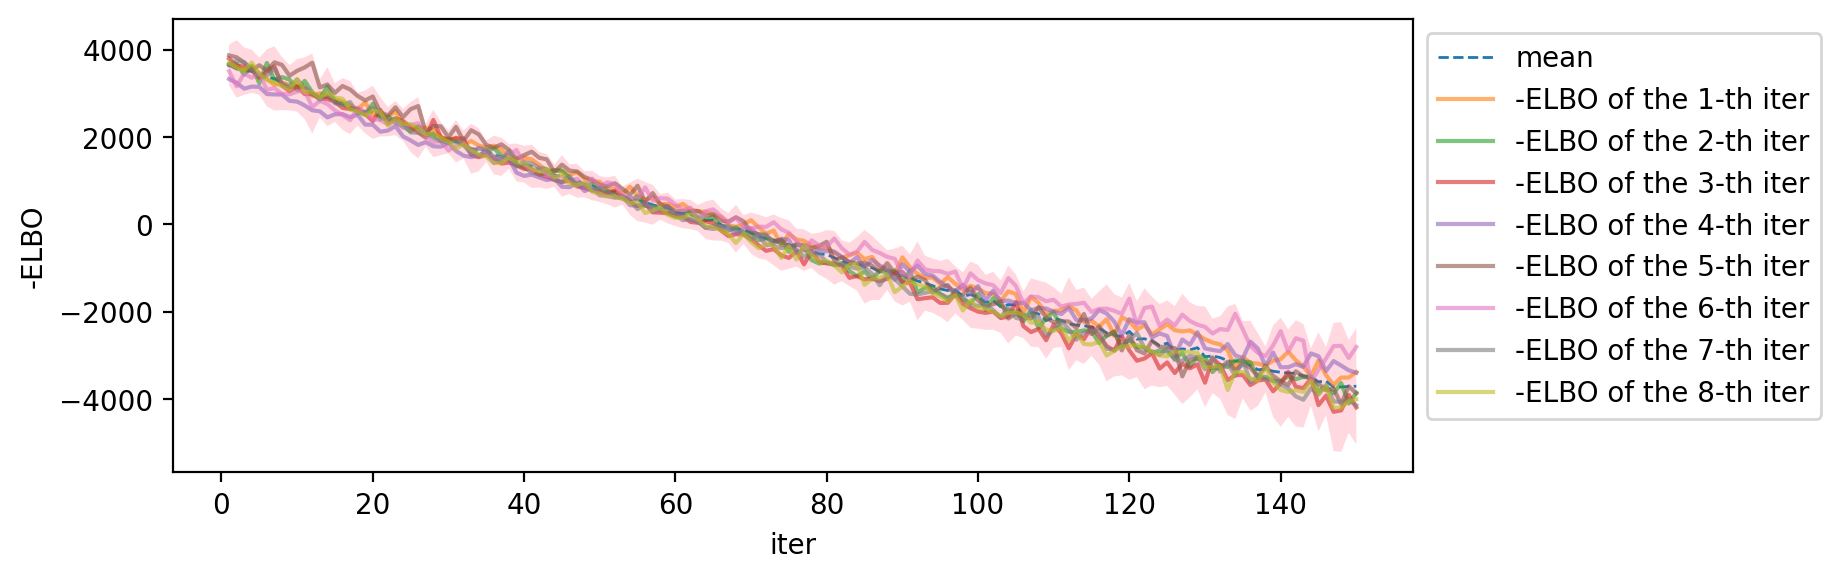

In [3]:
plt.figure(figsize=(8,3),dpi=200)
X = np.arange(1,len(info[0])+1,1)
mean = np.array(info).mean(axis=0).ravel()
mean = np.ones(shape=mean.shape)*mean
std = np.array(info).std(axis=0).ravel()
std = np.ones(shape=std.shape)*std
plt.plot(X,mean,'--',label='mean',lineWidth=1)
plt.fill_between(X,y1=mean+3*std,y2=mean-3*std,alpha=0.6,facecolor='pink')

for i in range(len(info)):
    plt.plot(X,info[i],label='-ELBO of the {}-th iter'.format(i+1),alpha=0.6)
plt.xlabel('iter')
plt.ylabel('-ELBO')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [4]:
def generate_incomplete_data(num_sample:int=10, time_horizon:float=5.0):
        gen = Logic_Model_Generator()
        data = gen.generate_data(num_sample=num_sample, time_horizon=time_horizon)
        action_history = {}
        for i in range(num_sample):
            action_history_ = dict([(key, data[i][key]) for key in [3,4,5,6]])
            action_history[i] = action_history_
        #NOTE: info
        print('[INFO] data has been generated!!!')
        return action_history

learn = Logic_Model_Incomplete_Data(time_horizon=0.5,action_history=action_history,hidden_size=(15,20),output_size=(20,4),batch_size=20,num_layers=(2,6))
info = []
times = 2
for time in range(times):
    action_history = generate_incomplete_data(num_sample=20,time_horizon=0.5)
    losses = learn.train_model(num_iter=100,lr=(0.01,0.01))
    info.append(losses)

[INFO] data has been generated!!!


  1%|          | 1/100 [00:01<01:49,  1.11s/it]

iter >> 1; loss >> [3677.5737]


  2%|▏         | 2/100 [00:02<01:57,  1.20s/it]

iter >> 2; loss >> [3580.9531]


  3%|▎         | 3/100 [00:03<01:45,  1.08s/it]

iter >> 3; loss >> [3287.5327]


  4%|▍         | 4/100 [00:04<01:38,  1.03s/it]

iter >> 4; loss >> [3481.4304]


  5%|▌         | 5/100 [00:05<01:38,  1.04s/it]

iter >> 5; loss >> [3540.275]


  6%|▌         | 6/100 [00:06<01:40,  1.07s/it]

iter >> 6; loss >> [3361.662]


  7%|▋         | 7/100 [00:07<01:42,  1.10s/it]

iter >> 7; loss >> [3175.128]


  8%|▊         | 8/100 [00:08<01:37,  1.06s/it]

iter >> 8; loss >> [3339.6238]


  9%|▉         | 9/100 [00:09<01:32,  1.01s/it]

iter >> 9; loss >> [3100.554]


 10%|█         | 10/100 [00:10<01:31,  1.02s/it]

iter >> 10; loss >> [2990.7473]


 11%|█         | 11/100 [00:11<01:29,  1.01s/it]

iter >> 11; loss >> [3066.6067]


 12%|█▏        | 12/100 [00:12<01:27,  1.01it/s]

iter >> 12; loss >> [3118.1943]


 13%|█▎        | 13/100 [00:13<01:24,  1.03it/s]

iter >> 13; loss >> [2919.3079]


 14%|█▍        | 14/100 [00:14<01:22,  1.05it/s]

iter >> 14; loss >> [2817.627]


 15%|█▌        | 15/100 [00:15<01:20,  1.05it/s]

iter >> 15; loss >> [2805.946]


 16%|█▌        | 16/100 [00:16<01:19,  1.05it/s]

iter >> 16; loss >> [2675.1191]


 17%|█▋        | 17/100 [00:17<01:19,  1.05it/s]

iter >> 17; loss >> [2808.6912]


 18%|█▊        | 18/100 [00:18<01:17,  1.05it/s]

iter >> 18; loss >> [2547.699]


 19%|█▉        | 19/100 [00:19<01:17,  1.05it/s]

iter >> 19; loss >> [2367.2632]


 20%|██        | 20/100 [00:20<01:17,  1.03it/s]

iter >> 20; loss >> [2528.746]


 21%|██        | 21/100 [00:21<01:16,  1.04it/s]

iter >> 21; loss >> [2455.2651]


 22%|██▏       | 22/100 [00:21<01:14,  1.05it/s]

iter >> 22; loss >> [2370.163]


 23%|██▎       | 23/100 [00:22<01:14,  1.03it/s]

iter >> 23; loss >> [2381.8438]


 24%|██▍       | 24/100 [00:23<01:13,  1.03it/s]

iter >> 24; loss >> [2247.2917]


 25%|██▌       | 25/100 [00:24<01:12,  1.04it/s]

iter >> 25; loss >> [2228.1594]


 26%|██▌       | 26/100 [00:25<01:11,  1.04it/s]

iter >> 26; loss >> [2120.7263]


 27%|██▋       | 27/100 [00:26<01:08,  1.06it/s]

iter >> 27; loss >> [2028.4434]


 28%|██▊       | 28/100 [00:27<01:07,  1.06it/s]

iter >> 28; loss >> [2055.3513]


 29%|██▉       | 29/100 [00:28<01:07,  1.05it/s]

iter >> 29; loss >> [1838.2306]


 30%|███       | 30/100 [00:29<01:06,  1.05it/s]

iter >> 30; loss >> [1943.1324]


 31%|███       | 31/100 [00:30<01:05,  1.05it/s]

iter >> 31; loss >> [1777.9762]


 32%|███▏      | 32/100 [00:31<01:05,  1.04it/s]

iter >> 32; loss >> [1714.0583]


 33%|███▎      | 33/100 [00:32<01:04,  1.05it/s]

iter >> 33; loss >> [1753.136]


 34%|███▍      | 34/100 [00:33<01:02,  1.06it/s]

iter >> 34; loss >> [1697.4706]


 35%|███▌      | 35/100 [00:34<01:01,  1.06it/s]

iter >> 35; loss >> [1732.6393]


 36%|███▌      | 36/100 [00:35<00:59,  1.07it/s]

iter >> 36; loss >> [1541.6875]


 37%|███▋      | 37/100 [00:36<00:59,  1.05it/s]

iter >> 37; loss >> [1592.4893]


 38%|███▊      | 38/100 [00:37<00:58,  1.05it/s]

iter >> 38; loss >> [1506.5953]


 39%|███▉      | 39/100 [00:38<00:57,  1.06it/s]

iter >> 39; loss >> [1393.1838]


 40%|████      | 40/100 [00:39<00:56,  1.06it/s]

iter >> 40; loss >> [1357.3158]


 41%|████      | 41/100 [00:40<00:55,  1.06it/s]

iter >> 41; loss >> [1419.2346]


 42%|████▏     | 42/100 [00:40<00:54,  1.06it/s]

iter >> 42; loss >> [1427.4548]


 43%|████▎     | 43/100 [00:41<00:53,  1.06it/s]

iter >> 43; loss >> [1363.1777]


 44%|████▍     | 44/100 [00:42<00:52,  1.07it/s]

iter >> 44; loss >> [1095.8967]


 45%|████▌     | 45/100 [00:43<00:51,  1.07it/s]

iter >> 45; loss >> [1106.4459]


 46%|████▌     | 46/100 [00:44<00:51,  1.04it/s]

iter >> 46; loss >> [1129.9688]


 47%|████▋     | 47/100 [00:45<00:50,  1.04it/s]

iter >> 47; loss >> [928.7701]


 48%|████▊     | 48/100 [00:46<00:48,  1.07it/s]

iter >> 48; loss >> [975.2551]


 49%|████▉     | 49/100 [00:47<00:47,  1.07it/s]

iter >> 49; loss >> [869.62213]


 50%|█████     | 50/100 [00:48<00:48,  1.04it/s]

iter >> 50; loss >> [854.88776]


 51%|█████     | 51/100 [00:49<00:47,  1.04it/s]

iter >> 51; loss >> [928.55444]


 52%|█████▏    | 52/100 [00:50<00:45,  1.05it/s]

iter >> 52; loss >> [640.98627]


 53%|█████▎    | 53/100 [00:51<00:44,  1.06it/s]

iter >> 53; loss >> [683.8341]


 54%|█████▍    | 54/100 [00:52<00:43,  1.05it/s]

iter >> 54; loss >> [549.8133]


 55%|█████▌    | 55/100 [00:53<00:42,  1.06it/s]

iter >> 55; loss >> [676.8255]


 56%|█████▌    | 56/100 [00:54<00:41,  1.06it/s]

iter >> 56; loss >> [644.96655]


 57%|█████▋    | 57/100 [00:55<00:39,  1.08it/s]

iter >> 57; loss >> [363.53928]


 58%|█████▊    | 58/100 [00:56<00:40,  1.04it/s]

iter >> 58; loss >> [348.5291]


 59%|█████▉    | 59/100 [00:57<00:39,  1.03it/s]

iter >> 59; loss >> [205.50015]


 60%|██████    | 60/100 [00:58<00:38,  1.05it/s]

iter >> 60; loss >> [238.89572]


 61%|██████    | 61/100 [00:58<00:36,  1.07it/s]

iter >> 61; loss >> [301.0956]


 62%|██████▏   | 62/100 [00:59<00:35,  1.06it/s]

iter >> 62; loss >> [156.62416]


 63%|██████▎   | 63/100 [01:00<00:34,  1.06it/s]

iter >> 63; loss >> [177.1923]


 64%|██████▍   | 64/100 [01:01<00:33,  1.08it/s]

iter >> 64; loss >> [130.04814]


 65%|██████▌   | 65/100 [01:02<00:33,  1.06it/s]

iter >> 65; loss >> [-83.12186]


 66%|██████▌   | 66/100 [01:03<00:32,  1.05it/s]

iter >> 66; loss >> [130.44514]


 67%|██████▋   | 67/100 [01:04<00:31,  1.06it/s]

iter >> 67; loss >> [91.187584]


 68%|██████▊   | 68/100 [01:05<00:30,  1.07it/s]

iter >> 68; loss >> [-213.29791]


 69%|██████▉   | 69/100 [01:06<00:28,  1.07it/s]

iter >> 69; loss >> [-189.40222]


 70%|███████   | 70/100 [01:07<00:28,  1.05it/s]

iter >> 70; loss >> [-155.78896]


 71%|███████   | 71/100 [01:08<00:27,  1.05it/s]

iter >> 71; loss >> [-111.80269]


 72%|███████▏  | 72/100 [01:09<00:26,  1.06it/s]

iter >> 72; loss >> [-293.7777]


 73%|███████▎  | 73/100 [01:10<00:25,  1.07it/s]

iter >> 73; loss >> [-393.12976]


 74%|███████▍  | 74/100 [01:11<00:24,  1.04it/s]

iter >> 74; loss >> [-317.20105]


 75%|███████▌  | 75/100 [01:12<00:24,  1.04it/s]

iter >> 75; loss >> [-403.23727]


 76%|███████▌  | 76/100 [01:13<00:22,  1.06it/s]

iter >> 76; loss >> [-339.68762]


 77%|███████▋  | 77/100 [01:14<00:21,  1.06it/s]

iter >> 77; loss >> [-581.38544]


 78%|███████▊  | 78/100 [01:15<00:20,  1.06it/s]

iter >> 78; loss >> [-572.82715]


 79%|███████▉  | 79/100 [01:15<00:19,  1.06it/s]

iter >> 79; loss >> [-709.0758]


 80%|████████  | 80/100 [01:16<00:18,  1.06it/s]

iter >> 80; loss >> [-768.52026]


 81%|████████  | 81/100 [01:17<00:17,  1.06it/s]

iter >> 81; loss >> [-845.1637]


 82%|████████▏ | 82/100 [01:18<00:17,  1.05it/s]

iter >> 82; loss >> [-852.2266]


 83%|████████▎ | 83/100 [01:19<00:15,  1.06it/s]

iter >> 83; loss >> [-628.73883]


 84%|████████▍ | 84/100 [01:20<00:15,  1.06it/s]

iter >> 84; loss >> [-948.05756]


 85%|████████▌ | 85/100 [01:21<00:14,  1.06it/s]

iter >> 85; loss >> [-673.37537]


 86%|████████▌ | 86/100 [01:22<00:13,  1.06it/s]

iter >> 86; loss >> [-972.96326]


 87%|████████▋ | 87/100 [01:23<00:12,  1.07it/s]

iter >> 87; loss >> [-915.6614]


 88%|████████▊ | 88/100 [01:24<00:11,  1.06it/s]

iter >> 88; loss >> [-1112.7551]


 89%|████████▉ | 89/100 [01:25<00:10,  1.05it/s]

iter >> 89; loss >> [-1070.1533]


 90%|█████████ | 90/100 [01:26<00:09,  1.05it/s]

iter >> 90; loss >> [-1287.4836]


 91%|█████████ | 91/100 [01:27<00:08,  1.06it/s]

iter >> 91; loss >> [-964.76575]


 92%|█████████▏| 92/100 [01:28<00:07,  1.03it/s]

iter >> 92; loss >> [-1204.6646]


 93%|█████████▎| 93/100 [01:29<00:06,  1.03it/s]

iter >> 93; loss >> [-1048.056]


 94%|█████████▍| 94/100 [01:30<00:05,  1.04it/s]

iter >> 94; loss >> [-1344.32]


 95%|█████████▌| 95/100 [01:31<00:04,  1.05it/s]

iter >> 95; loss >> [-1408.176]


 96%|█████████▌| 96/100 [01:32<00:03,  1.06it/s]

iter >> 96; loss >> [-1247.8197]


 97%|█████████▋| 97/100 [01:33<00:02,  1.06it/s]

iter >> 97; loss >> [-1548.526]


 98%|█████████▊| 98/100 [01:33<00:01,  1.08it/s]

iter >> 98; loss >> [-1448.0754]


 99%|█████████▉| 99/100 [01:34<00:00,  1.06it/s]

iter >> 99; loss >> [-1516.6356]


100%|██████████| 100/100 [01:35<00:00,  1.04it/s]


iter >> 100; loss >> [-1635.3867]
[INFO] data has been generated!!!


  1%|          | 1/100 [00:01<01:40,  1.01s/it]

iter >> 1; loss >> [-1600.5333]


  2%|▏         | 2/100 [00:01<01:34,  1.04it/s]

iter >> 2; loss >> [-1674.0674]


  3%|▎         | 3/100 [00:02<01:30,  1.08it/s]

iter >> 3; loss >> [-1807.0413]


  4%|▍         | 4/100 [00:03<01:29,  1.07it/s]

iter >> 4; loss >> [-1814.7935]


  5%|▌         | 5/100 [00:04<01:30,  1.05it/s]

iter >> 5; loss >> [-1905.4443]


  6%|▌         | 6/100 [00:05<01:29,  1.05it/s]

iter >> 6; loss >> [-2051.7317]


  7%|▋         | 7/100 [00:06<01:29,  1.04it/s]

iter >> 7; loss >> [-1953.2356]


  8%|▊         | 8/100 [00:07<01:28,  1.04it/s]

iter >> 8; loss >> [-1799.1102]


  9%|▉         | 9/100 [00:08<01:29,  1.02it/s]

iter >> 9; loss >> [-2000.126]


 10%|█         | 10/100 [00:09<01:27,  1.03it/s]

iter >> 10; loss >> [-2137.236]


 11%|█         | 11/100 [00:10<01:24,  1.05it/s]

iter >> 11; loss >> [-2082.6528]


 12%|█▏        | 12/100 [00:11<01:24,  1.05it/s]

iter >> 12; loss >> [-2244.7837]


 13%|█▎        | 13/100 [00:12<01:23,  1.04it/s]

iter >> 13; loss >> [-2346.2407]


 14%|█▍        | 14/100 [00:13<01:21,  1.06it/s]

iter >> 14; loss >> [-2334.9333]


 15%|█▌        | 15/100 [00:14<01:20,  1.06it/s]

iter >> 15; loss >> [-2354.4282]


 16%|█▌        | 16/100 [00:15<01:18,  1.06it/s]

iter >> 16; loss >> [-2266.8997]


 17%|█▋        | 17/100 [00:16<01:17,  1.07it/s]

iter >> 17; loss >> [-2457.5632]


 18%|█▊        | 18/100 [00:17<01:19,  1.04it/s]

iter >> 18; loss >> [-2277.2324]


 19%|█▉        | 19/100 [00:18<01:19,  1.02it/s]

iter >> 19; loss >> [-2357.341]


 20%|██        | 20/100 [00:19<01:17,  1.03it/s]

iter >> 20; loss >> [-2511.9917]


 21%|██        | 21/100 [00:20<01:18,  1.01it/s]

iter >> 21; loss >> [-2527.519]


 22%|██▏       | 22/100 [00:21<01:16,  1.02it/s]

iter >> 22; loss >> [-2545.6677]


 23%|██▎       | 23/100 [00:22<01:14,  1.03it/s]

iter >> 23; loss >> [-2727.4697]


 24%|██▍       | 24/100 [00:23<01:12,  1.04it/s]

iter >> 24; loss >> [-2727.3635]


 25%|██▌       | 25/100 [00:23<01:11,  1.05it/s]

iter >> 25; loss >> [-2847.7856]


 26%|██▌       | 26/100 [00:24<01:10,  1.05it/s]

iter >> 26; loss >> [-2582.1804]


 27%|██▋       | 27/100 [00:25<01:10,  1.04it/s]

iter >> 27; loss >> [-2522.8062]


 28%|██▊       | 28/100 [00:26<01:09,  1.04it/s]

iter >> 28; loss >> [-3006.79]


 29%|██▉       | 29/100 [00:27<01:09,  1.02it/s]

iter >> 29; loss >> [-2941.4902]


 30%|███       | 30/100 [00:28<01:08,  1.03it/s]

iter >> 30; loss >> [-3213.2373]


 31%|███       | 31/100 [00:29<01:07,  1.03it/s]

iter >> 31; loss >> [-3024.77]


 32%|███▏      | 32/100 [00:30<01:06,  1.03it/s]

iter >> 32; loss >> [-3239.6975]


 33%|███▎      | 33/100 [00:31<01:04,  1.04it/s]

iter >> 33; loss >> [-3404.5625]


 34%|███▍      | 34/100 [00:32<01:05,  1.01it/s]

iter >> 34; loss >> [-3057.1836]


 35%|███▌      | 35/100 [00:33<01:04,  1.02it/s]

iter >> 35; loss >> [-3399.8872]


 36%|███▌      | 36/100 [00:34<01:03,  1.01it/s]

iter >> 36; loss >> [-3330.7627]


 37%|███▋      | 37/100 [00:35<01:01,  1.03it/s]

iter >> 37; loss >> [-3408.958]


 38%|███▊      | 38/100 [00:36<00:59,  1.04it/s]

iter >> 38; loss >> [-2807.0974]


 39%|███▉      | 39/100 [00:37<00:58,  1.05it/s]

iter >> 39; loss >> [-3347.9954]


 40%|████      | 40/100 [00:38<00:56,  1.05it/s]

iter >> 40; loss >> [-2978.823]


 41%|████      | 41/100 [00:39<00:56,  1.05it/s]

iter >> 41; loss >> [-3464.2852]


 42%|████▏     | 42/100 [00:40<00:55,  1.05it/s]

iter >> 42; loss >> [-3717.5894]


 43%|████▎     | 43/100 [00:41<00:53,  1.06it/s]

iter >> 43; loss >> [-3642.908]


 44%|████▍     | 44/100 [00:42<00:52,  1.06it/s]

iter >> 44; loss >> [-3419.5586]


 45%|████▌     | 45/100 [00:43<00:52,  1.04it/s]

iter >> 45; loss >> [-3535.1108]


 46%|████▌     | 46/100 [00:44<00:51,  1.04it/s]

iter >> 46; loss >> [-3649.653]


 47%|████▋     | 47/100 [00:45<00:50,  1.04it/s]

iter >> 47; loss >> [-3842.3994]


 48%|████▊     | 48/100 [00:46<00:49,  1.05it/s]

iter >> 48; loss >> [-3835.4153]


 49%|████▉     | 49/100 [00:47<00:48,  1.06it/s]

iter >> 49; loss >> [-3623.1455]


 50%|█████     | 50/100 [00:48<00:48,  1.03it/s]

iter >> 50; loss >> [-3960.1396]


 51%|█████     | 51/100 [00:49<00:48,  1.02it/s]

iter >> 51; loss >> [-3850.3079]


 52%|█████▏    | 52/100 [00:50<00:46,  1.04it/s]

iter >> 52; loss >> [-3559.7693]


 53%|█████▎    | 53/100 [00:51<00:45,  1.03it/s]

iter >> 53; loss >> [-3764.6]


 54%|█████▍    | 54/100 [00:52<00:44,  1.03it/s]

iter >> 54; loss >> [-3779.4487]


 55%|█████▌    | 55/100 [00:52<00:43,  1.04it/s]

iter >> 55; loss >> [-3376.489]


 56%|█████▌    | 56/100 [00:53<00:41,  1.05it/s]

iter >> 56; loss >> [-4191.8086]


 57%|█████▋    | 57/100 [00:54<00:40,  1.06it/s]

iter >> 57; loss >> [-3956.609]


 58%|█████▊    | 58/100 [00:55<00:39,  1.06it/s]

iter >> 58; loss >> [-3960.6936]


 59%|█████▉    | 59/100 [00:56<00:39,  1.03it/s]

iter >> 59; loss >> [-3961.604]


 60%|██████    | 60/100 [00:57<00:38,  1.03it/s]

iter >> 60; loss >> [-4368.235]


 61%|██████    | 61/100 [00:58<00:36,  1.06it/s]

iter >> 61; loss >> [-4146.324]


 62%|██████▏   | 62/100 [00:59<00:36,  1.03it/s]

iter >> 62; loss >> [-3927.0457]


 63%|██████▎   | 63/100 [01:00<00:36,  1.02it/s]

iter >> 63; loss >> [-4233.8955]


 64%|██████▍   | 64/100 [01:01<00:34,  1.04it/s]

iter >> 64; loss >> [-4301.7095]


 65%|██████▌   | 65/100 [01:02<00:33,  1.05it/s]

iter >> 65; loss >> [-4564.005]


 66%|██████▌   | 66/100 [01:03<00:32,  1.05it/s]

iter >> 66; loss >> [-4175.733]


 67%|██████▋   | 67/100 [01:04<00:31,  1.04it/s]

iter >> 67; loss >> [-4290.1235]


 68%|██████▊   | 68/100 [01:05<00:30,  1.04it/s]

iter >> 68; loss >> [-4182.5063]


 69%|██████▉   | 69/100 [01:06<00:29,  1.05it/s]

iter >> 69; loss >> [-4091.933]


 70%|███████   | 70/100 [01:07<00:28,  1.05it/s]

iter >> 70; loss >> [-4381.9805]


 71%|███████   | 71/100 [01:08<00:27,  1.04it/s]

iter >> 71; loss >> [-4144.8096]


 72%|███████▏  | 72/100 [01:09<00:27,  1.02it/s]

iter >> 72; loss >> [-4723.2944]


 73%|███████▎  | 73/100 [01:10<00:26,  1.01it/s]

iter >> 73; loss >> [-4628.1035]


 74%|███████▍  | 74/100 [01:11<00:25,  1.02it/s]

iter >> 74; loss >> [-4579.1206]


 75%|███████▌  | 75/100 [01:12<00:24,  1.03it/s]

iter >> 75; loss >> [-4631.661]


 76%|███████▌  | 76/100 [01:13<00:22,  1.05it/s]

iter >> 76; loss >> [-4587.4814]


 77%|███████▋  | 77/100 [01:14<00:21,  1.06it/s]

iter >> 77; loss >> [-4706.613]


 78%|███████▊  | 78/100 [01:14<00:20,  1.07it/s]

iter >> 78; loss >> [-4066.6843]


 79%|███████▉  | 79/100 [01:15<00:19,  1.07it/s]

iter >> 79; loss >> [-4889.902]


 80%|████████  | 80/100 [01:16<00:19,  1.03it/s]

iter >> 80; loss >> [-4829.3467]


 81%|████████  | 81/100 [01:17<00:18,  1.03it/s]

iter >> 81; loss >> [-4731.448]


 82%|████████▏ | 82/100 [01:18<00:17,  1.03it/s]

iter >> 82; loss >> [-4700.9062]


 83%|████████▎ | 83/100 [01:19<00:16,  1.03it/s]

iter >> 83; loss >> [-4785.336]


 84%|████████▍ | 84/100 [01:20<00:15,  1.06it/s]

iter >> 84; loss >> [-5593.2227]


 85%|████████▌ | 85/100 [01:21<00:14,  1.06it/s]

iter >> 85; loss >> [-4865.236]


 86%|████████▌ | 86/100 [01:22<00:13,  1.06it/s]

iter >> 86; loss >> [-5060.569]


 87%|████████▋ | 87/100 [01:23<00:12,  1.06it/s]

iter >> 87; loss >> [-5270.541]


 88%|████████▊ | 88/100 [01:24<00:11,  1.05it/s]

iter >> 88; loss >> [-4698.5127]


 89%|████████▉ | 89/100 [01:25<00:10,  1.00it/s]

iter >> 89; loss >> [-5176.524]


 90%|█████████ | 90/100 [01:26<00:09,  1.01it/s]

iter >> 90; loss >> [-4558.9766]


 91%|█████████ | 91/100 [01:27<00:08,  1.03it/s]

iter >> 91; loss >> [-5033.5117]


 92%|█████████▏| 92/100 [01:28<00:07,  1.05it/s]

iter >> 92; loss >> [-4876.039]


 93%|█████████▎| 93/100 [01:29<00:06,  1.05it/s]

iter >> 93; loss >> [-5208.9707]


 94%|█████████▍| 94/100 [01:30<00:05,  1.05it/s]

iter >> 94; loss >> [-4800.1353]


 95%|█████████▌| 95/100 [01:31<00:04,  1.06it/s]

iter >> 95; loss >> [-4843.3555]


 96%|█████████▌| 96/100 [01:32<00:03,  1.05it/s]

iter >> 96; loss >> [-5018.3486]


 97%|█████████▋| 97/100 [01:33<00:02,  1.05it/s]

iter >> 97; loss >> [-5016.9697]


 98%|█████████▊| 98/100 [01:34<00:01,  1.02it/s]

iter >> 98; loss >> [-5382.334]


 99%|█████████▉| 99/100 [01:35<00:00,  1.02it/s]

iter >> 99; loss >> [-4498.974]


100%|██████████| 100/100 [01:36<00:00,  1.04it/s]

iter >> 100; loss >> [-4916.877]
